<a href="https://colab.research.google.com/github/NushratRia/Transformer_Based_Bangla_Chatbot/blob/main/Chatbot_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import sys

if 'google.colab' in sys.modules:
  %tensorflow_version 2.x
import tensorflow as tf

tf.random.set_seed(1234)
AUTO = tf.data.experimental.AUTOTUNE
import tensorflow_datasets as tfds

import os
import re
import numpy as np
from time import time
import matplotlib.pyplot as plt

print("Tensorflow version {}".format(tf.__version__))

Tensorflow version 2.2.0


In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU {}'.format(tpu.cluster_spec().as_dict()['worker']))
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: {}".format(strategy.num_replicas_in_sync))

REPLICAS: 1


In [ ]:
# Maximum sentence length
MAX_LENGTH = 40

# Maximum number of samples to preprocess
MAX_SAMPLES = 2000

# For tf.data.Dataset
BATCH_SIZE = 64 * strategy.num_replicas_in_sync
BUFFER_SIZE = 20000

# For Transformer
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

EPOCHS = 120

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
df=pd.read_excel("/content/drive/My Drive/Colab Notebooks/QA-Bangla-Dataset.xlsx",encoding='utf-8')

In [ ]:
df.head()

,QI,Context,Question,Answer
0,1,বাংলাদেশের সাংবিধানিক নাম গণপ্রজাতন্ত্রী বাংলাদেশ,বাংলাদেশের সাংবিধানিক নাম কী?,গণপ্রজাতন্ত্রী বাংলাদেশ
1,2,বরেন্দ্র মিউজিয়াম রাজশাহীতে অবস্থিত,বরেন্দ্র মিউজিয়াম কোথায় অবস্থিত?,রাজশাহীতে
2,3,বাংলাদেশের জাতীয় সংসদের আসন ৩৫০টি,বাংলাদেশের জাতীয় সংসদের আসন কয়টি?,৩৫০টি
3,4,বাংলাদেশের জাতীয় দিবস ২৬ মার্চ,বাংলাদেশের জাতীয় দিবস কবে?,২৬ মার্চ
4,5,বাংলাদেশের পোশাক খাতের প্রধান বৈদেশিক বাজার যু...,বাংলাদেশের পোশাক খাতের প্রধান বৈদেশিক বাজার কো...,যুক্তরাষ্ট্র


In [ ]:
df=df.drop(["QI","Context"],axis=1)

In [ ]:
df

,Question,Answer
0,বাংলাদেশের সাংবিধানিক নাম কী?,গণপ্রজাতন্ত্রী বাংলাদেশ
1,বরেন্দ্র মিউজিয়াম কোথায় অবস্থিত?,রাজশাহীতে
2,বাংলাদেশের জাতীয় সংসদের আসন কয়টি?,৩৫০টি
3,বাংলাদেশের জাতীয় দিবস কবে?,২৬ মার্চ
4,বাংলাদেশের পোশাক খাতের প্রধান বৈদেশিক বাজার কো...,যুক্তরাষ্ট্র
...,...,...
1995,জিম্বাবুয়ের মুদ্রার নাম কি?,জিম্বাবুয়ে ডলার
1996,জুটন আবিস্কার করেন কে?,ড. মোহাম্মদ সিদ্দিকুল্লাহ
1997,ক্ষতস্থান থেকে রক্ত পরা বন্ধ করে কোন ভিটামিন ?,ভিটামিন-কে
1998,সামাজিক চুক্তি মতবাদের প্রবক্তা কে?,জ্যাঁ জ্যাক রুশো


In [ ]:
questions=[]
answers=[]

for i in df.Question:
  questions.append(i)

for i in df.Answer:
  answers.append(i)

questions_eva=[]
answers_eva=[]

for i in df.Question:
  questions_eva.append(i)

for i in df.Answer:
  answers_eva.append(i)

In [ ]:
print('Sample question: {}'.format(questions[20]))
print('Sample answer: {}'.format(answers[20]))

Sample question: ডোনাল্ড ট্রাম্প যুক্তরাষ্ট্রের প্রেসিডেন্ট হিসেবে কবে শপথ নিয়েছেন?
Sample answer: ২০ জানুয়ারি ২০১৭


# Transformer

In [ ]:
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

# Define start and end token to indicate the start and end of a sentence
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# Vocabulary size plus start and end token
VOCAB_SIZE = tokenizer.vocab_size + 2

In [ ]:
print('Tokenized sample question: {}'.format(tokenizer.encode(questions[20])))

Tokenized sample question: [41, 13, 9, 1, 11, 2, 116, 24, 2, 7, 1, 17, 2, 101, 19, 15, 5, 2, 90, 1, 35, 2, 24, 2, 7, 3, 6, 18, 2, 7, 3, 10, 4, 41, 3, 9, 2, 53, 32, 4, 10, 3, 8, 16, 60, 16, 1425, 9, 4, 19, 94, 45, 3, 9, 2043]


In [ ]:
# Tokenize, filter and pad sentences
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    # tokenize sentence
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
    # check tokenized sentence max length
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)

  # pad tokenized sentences
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

  return tokenized_inputs, tokenized_outputs


questions, answers = tokenize_and_filter(questions, answers)

In [ ]:
print('Vocab size: {}'.format(VOCAB_SIZE))
print('Number of samples: {}'.format(len(questions)))

Vocab size: 2238
Number of samples: 1741


In [ ]:
# decoder inputs use the previous target as input
# remove START_TOKEN from targets
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
print(dataset)

<PrefetchDataset shapes: ({inputs: (None, 40), dec_inputs: (None, 39)}, {outputs: (None, 39)}), types: ({inputs: tf.int32, dec_inputs: tf.int32}, {outputs: tf.int32})>


In [ ]:
def scaled_dot_product_attention(query, key, value, mask):
  """Calculate the attention weights. """
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # scale matmul_qk
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # add the mask to zero out padding tokens
  if mask is not None:
    logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  output = tf.matmul(attention_weights, value)

  return output

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # split heads
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # scaled dot-product attention
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # concatenation of heads
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs

In [ ]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [ ]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


In [ ]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [ ]:

print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # apply sin to even index in the array
    sines = tf.math.sin(angle_rads[:, 0::2])
    # apply cos to odd index in the array
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

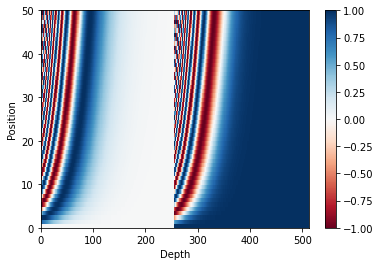

In [ ]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [ ]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

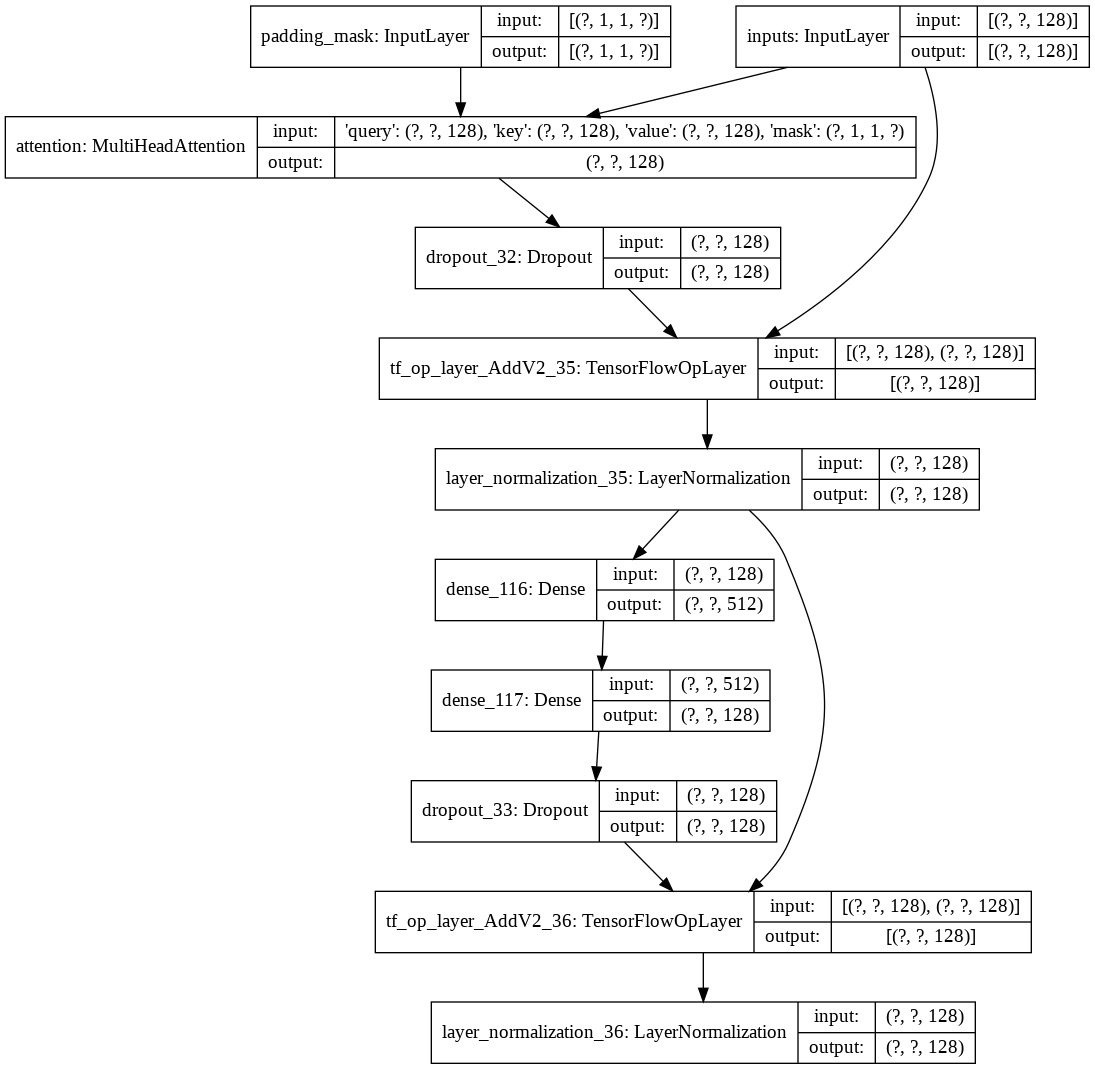

In [ ]:
sample_encoder_layer = encoder_layer(
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_encoder_layer")
tf.keras.utils.plot_model(
    sample_encoder_layer, to_file='encoder_layer.png', show_shapes=True)

In [ ]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

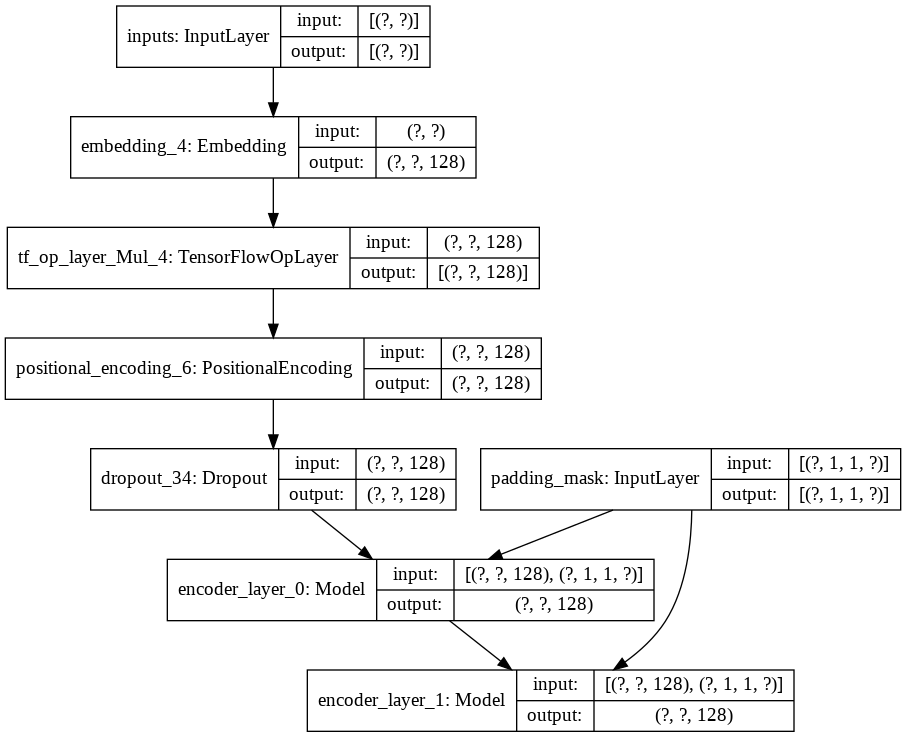

In [ ]:

sample_encoder = encoder(
    vocab_size=2238,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_encoder")

tf.keras.utils.plot_model(
   sample_encoder, to_file='encoder.png', show_shapes=True)

In [ ]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

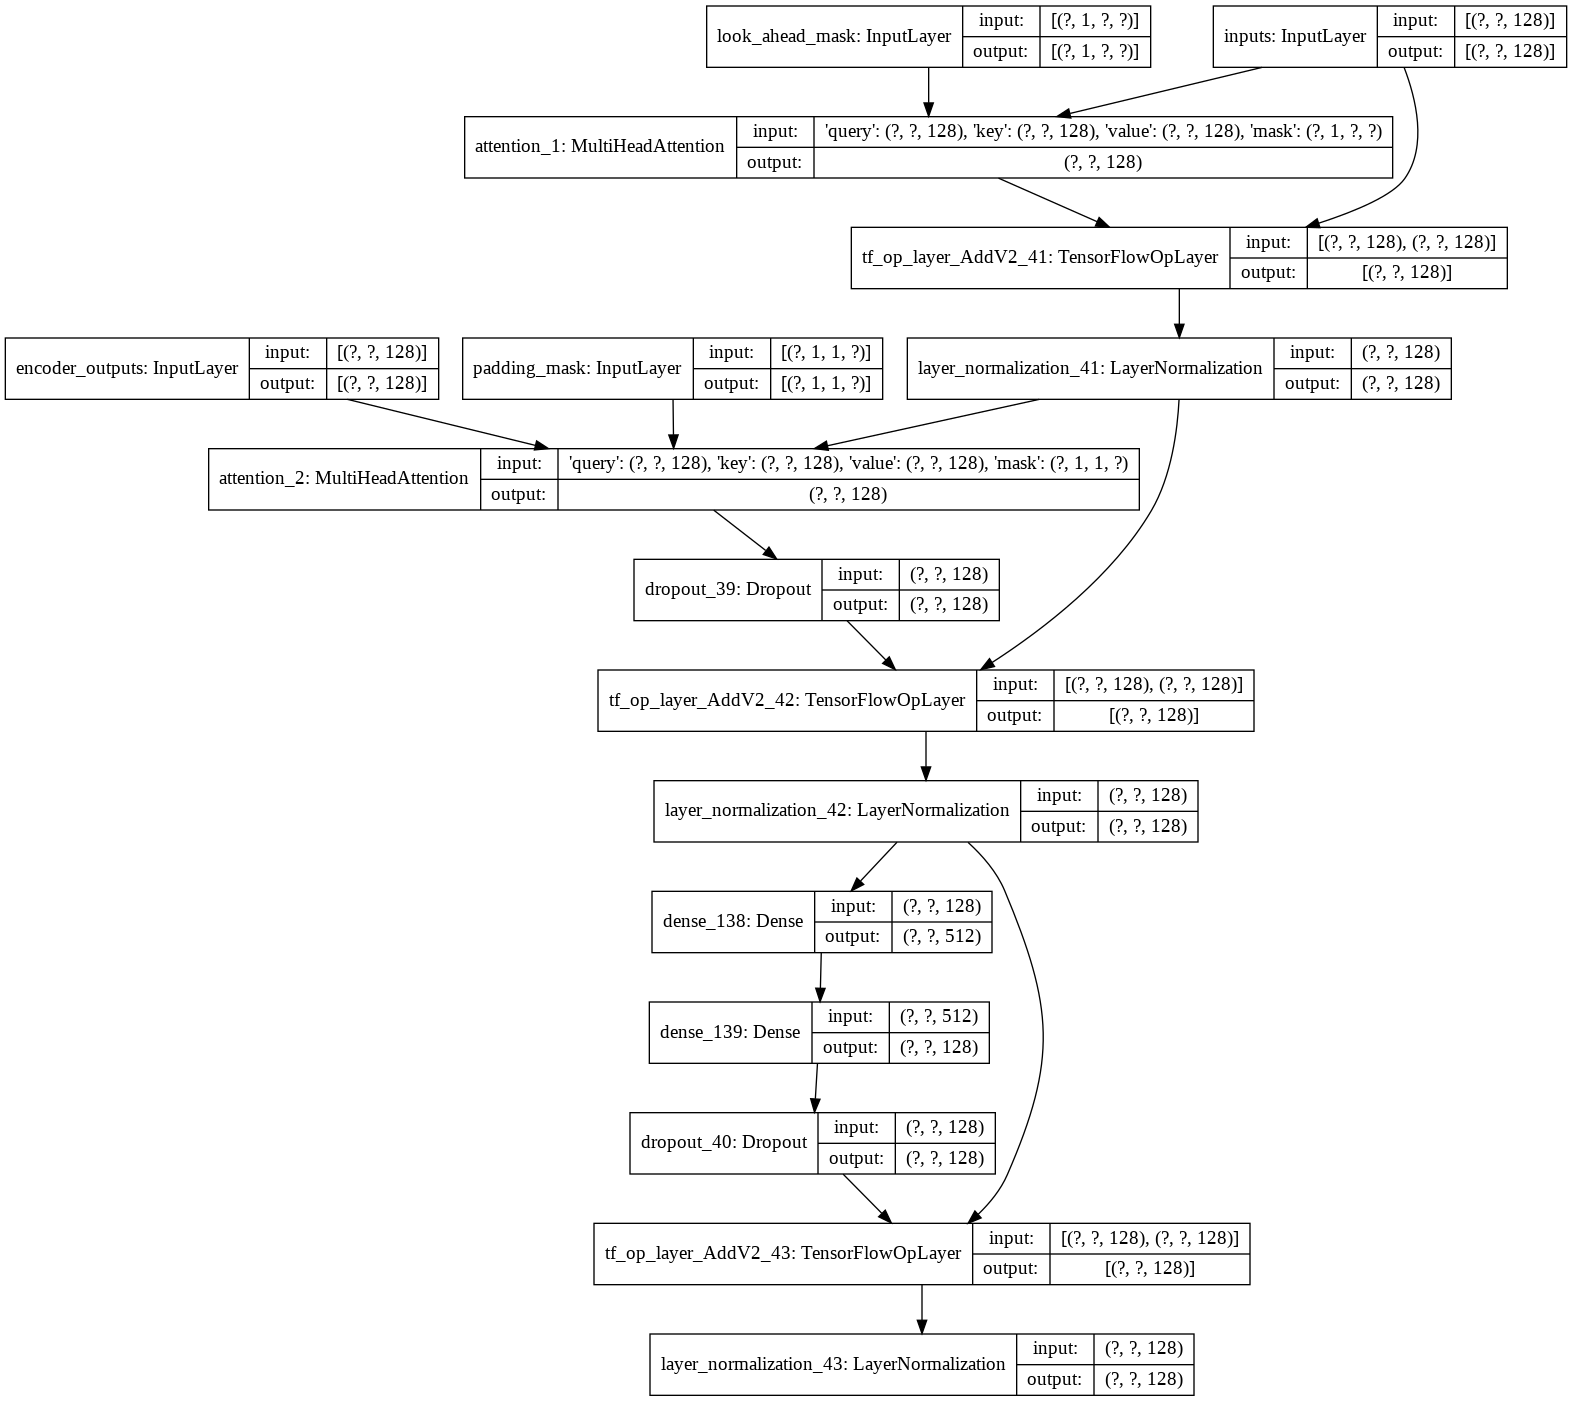

In [ ]:
sample_decoder_layer = decoder_layer(
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder_layer")

tf.keras.utils.plot_model(
    sample_decoder_layer, to_file='decoder_layer.png', show_shapes=True)

In [ ]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

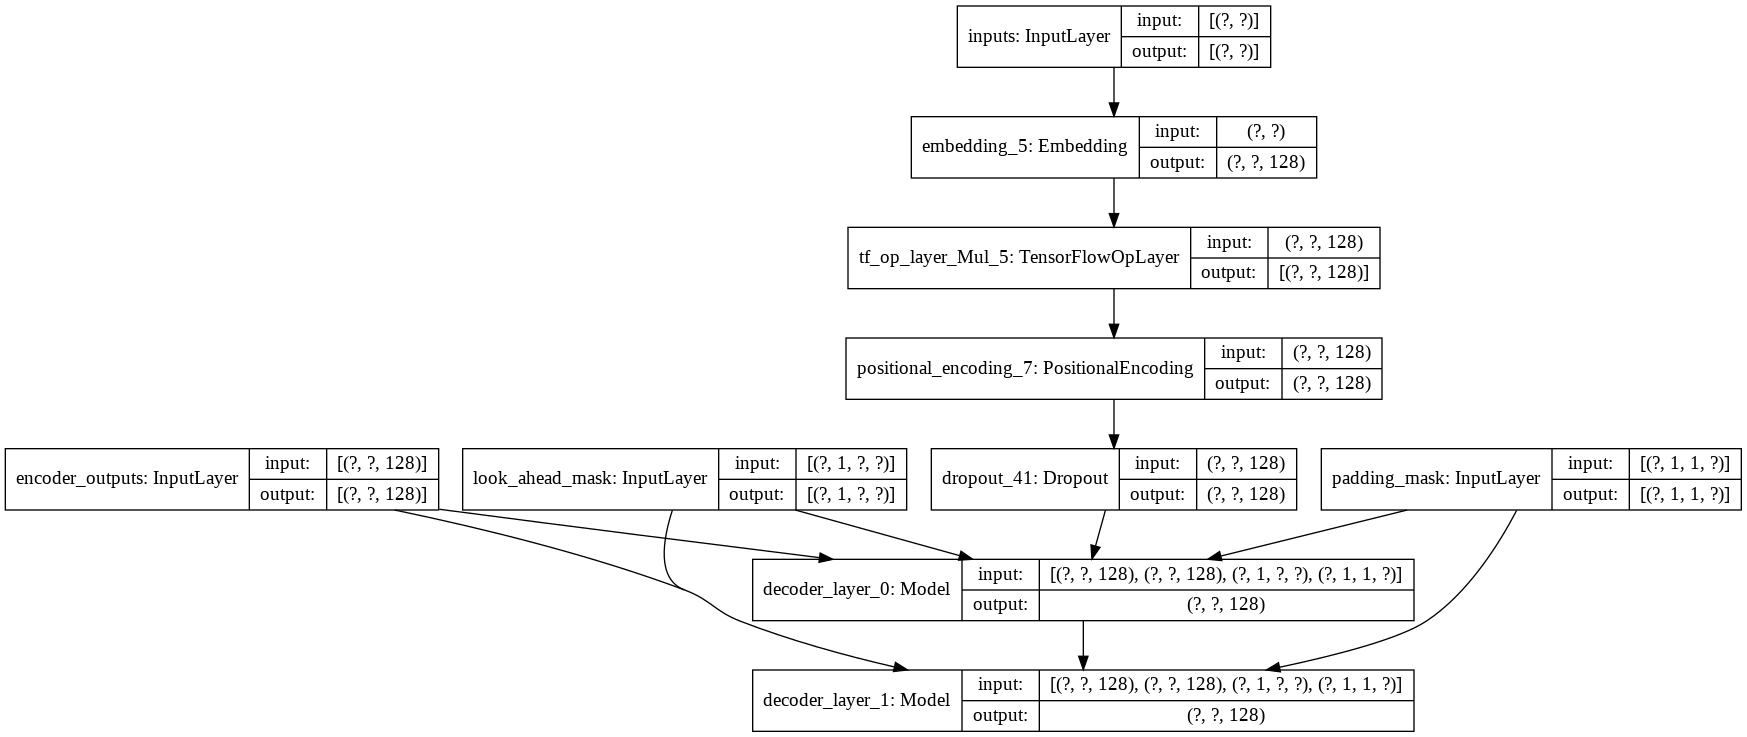

In [ ]:
sample_decoder = decoder(
    vocab_size=2238,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder")

tf.keras.utils.plot_model(
    sample_decoder, to_file='decoder.png', show_shapes=True)

In [ ]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)
  # mask the future tokens for decoder inputs at the 1st attention block
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)
  # mask the encoder outputs for the 2nd attention block
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

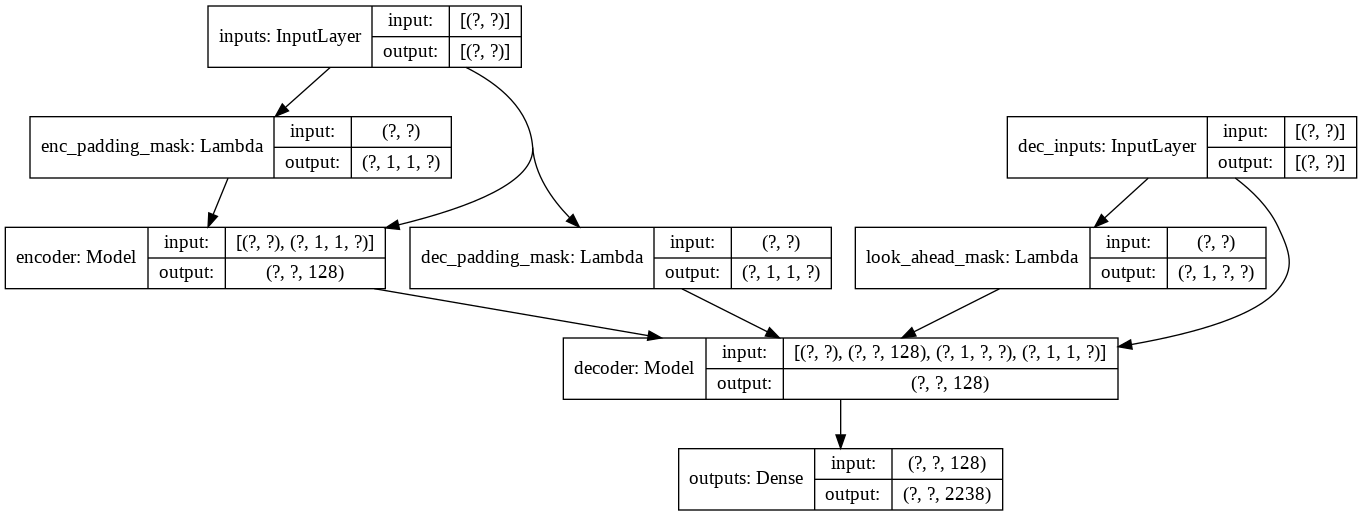

In [ ]:
sample_transformer = transformer(
    vocab_size=2238,
    num_layers=4,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_transformer")

tf.keras.utils.plot_model(
    sample_transformer, to_file='transformer.png', show_shapes=True)

In [ ]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [ ]:

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

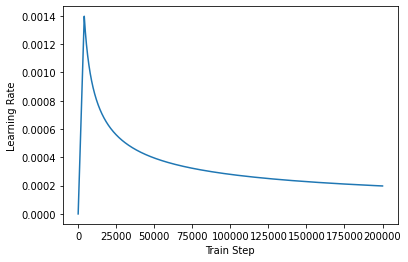

In [ ]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [ ]:

# clear backend
tf.keras.backend.clear_session()

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

# initialize and compile model within strategy scope
with strategy.scope():
  model = transformer(
      vocab_size=VOCAB_SIZE,
      num_layers=NUM_LAYERS,
      units=UNITS,
      d_model=D_MODEL,
      num_heads=NUM_HEADS,
      dropout=DROPOUT)

  model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Model)                 (None, None, 256)    1627136     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [ ]:
history=model.fit(dataset, epochs=EPOCHS)

Epoch 1/120
28/28 [==============================] - 3s 96ms/step - loss: 1.9960 - accuracy: 0.0019
Epoch 2/120
28/28 [==============================] - 3s 92ms/step - loss: 1.8922 - accuracy: 0.0171
Epoch 3/120
28/28 [==============================] - 3s 93ms/step - loss: 1.7563 - accuracy: 0.0256
Epoch 4/120
28/28 [==============================] - 3s 94ms/step - loss: 1.6552 - accuracy: 0.0295
Epoch 5/120
28/28 [==============================] - 3s 93ms/step - loss: 1.5761 - accuracy: 0.0342
Epoch 6/120
28/28 [==============================] - 3s 93ms/step - loss: 1.4997 - accuracy: 0.0354
Epoch 7/120
28/28 [==============================] - 3s 93ms/step - loss: 1.4186 - accuracy: 0.0363
Epoch 8/120
28/28 [==============================] - 3s 93ms/step - loss: 1.3354 - accuracy: 0.0371
Epoch 9/120
28/28 [==============================] - 3s 93ms/step - loss: 1.2573 - accuracy: 0.0378
Epoch 10/120
28/28 [==============================] - 3s 94ms/step - loss: 1.1897 - accuracy: 0.0392

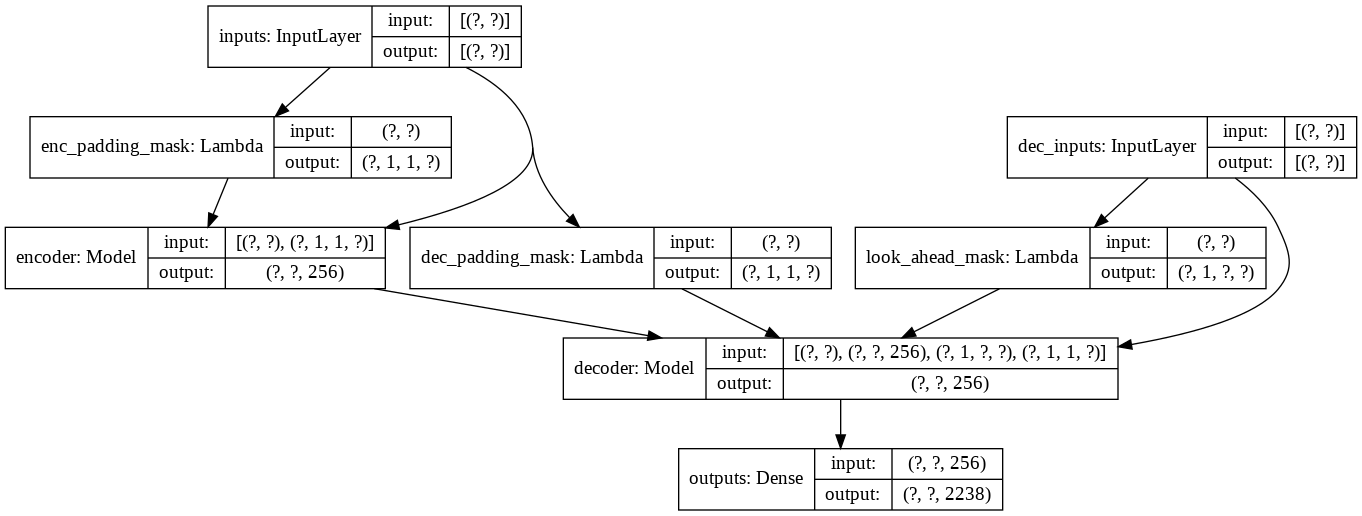

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
def evaluate(sentence):

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # select the last word from the seq_len dimension
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # return the result if the predicted_id is equal to the end token
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # concatenated the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)


def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence

In [ ]:
output = predict('ধান গাছের ক্রোমোসোম সংখ্যা কয়টি?')

Input: ধান গাছের ক্রোমোসোম সংখ্যা কয়টি?
Output: ২৪ টি


In [ ]:
sentence="বাংলাদেশের জাতীয় দিবস কবে?"
for _ in range(10):
  sentence = predict(sentence)
  print('')

Input: বাংলাদেশের জাতীয় দিবস কবে?
Output: ২৬ মার্চ

Input: ২৬ মার্চ
Output: নারী

Input: নারী
Output: উয়ান

Input: উয়ান
Output: নাইপিদো

Input: নাইপিদো
Output: চট্টগ্রামে

Input: চট্টগ্রামে
Output: ইসলামাবাদ

Input: ইসলামাবাদ
Output: সম্রাট হাঙামাটি

Input: সম্রাট হাঙামাটি
Output: অগ্নিটাট ন্গেট 

Input: অগ্নিটাট ন্গেট 
Output: সম্রাট হোম্মদ স

Input: সম্রাট হোম্মদ স
Output: স্দিকান



In [ ]:
import tqdm
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
X = questions_eva
Y = answers_eva

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
len (Y_test)

400

In [ ]:
fr_preds = []
for sentence in tqdm.tqdm(X_test):
    fr_pred = predict(sentence)
    fr_preds.append(fr_pred)

  0%|          | 1/400 [00:01<08:43,  1.31s/it]

Input: ডায়নামো কে আবিস্কার করেন ? 
Output: মাইকেল ফ্যারাডে


  0%|          | 2/400 [00:02<08:02,  1.21s/it]

Input: বাংলাদেশের মূল ভূ-খণ্ড থেকে সেন্ট মার্টিন দ্বীপের দূরত্ব কত ?
Output:  ৫ ডিসেম্বর


  1%|          | 3/400 [00:04<10:17,  1.56s/it]

Input: বিশ্বকাপে প্রথম পেনাল্টি থেকে গোল করতে ব্যর্থ হন কে?  
Output: আর্জেন্টিনার খাতেরনস্তার


  1%|          | 4/400 [00:05<09:03,  1.37s/it]

Input: ইবোলা ভাইরাসে এ পর্যন্ত সবচেয়ে ক্ষতিগ্রস্ত দেশ কোনটি?
Output:  লাইবেরিয়া


  1%|▏         | 5/400 [00:06<07:49,  1.19s/it]

Input: অ্যাঙ্গোলার প্রাচীন নাম কি?
Output: আফ্রিকা


  2%|▏         | 6/400 [00:07<08:23,  1.28s/it]

Input: বাংলা ভাষার প্রথম কাব্য সংকলন চর্যাপদ এর আবিষ্কারক কে?
Output: হরপ্রাসাদ শাস্ত্রী


  2%|▏         | 7/400 [00:09<08:14,  1.26s/it]

Input: বাংলাদেশ হাঁস-মুরগী গবেষণা ইনস্টিটিউট কোথায় অবস্থিত?
Output: নারায়ণগঞ্জ অবস্থিত


  2%|▏         | 8/400 [00:09<06:52,  1.05s/it]

Input: দ্বিতীয় বিশ্ব যুদ্ধ শেষ হয় কবে ?
Output: ১৯৪৫ সালে


  2%|▏         | 9/400 [00:10<06:11,  1.05it/s]

Input: বিশ্বের বৃহত্তম ব-দ্বীপ কোনটি?
Output: বাংলাদেশ


  2%|▎         | 10/400 [00:11<06:28,  1.00it/s]

Input: ঢাকা শহরের কোন এলাকায় বেনারসি শাড়ি তৈরি হয়?
Output: মিরপুর এলাকায়


  3%|▎         | 11/400 [00:11<05:15,  1.23it/s]

Input: টেস্ট ক্রিকেটে বর্তমান সদস্য সংখ্যা কত?
Output: ১২ টি


  3%|▎         | 12/400 [00:12<04:25,  1.46it/s]

Input: আলবেনিয়ার মুদ্রার নাম কি?
Output: লেক 


  3%|▎         | 13/400 [00:14<07:02,  1.09s/it]

Input: দীনবন্ধু মিত্রের কাব্যগুলো কি কি?
Output: সুরধুনী কাব্য ও দ্বাদশ কবিতা


  4%|▎         | 14/400 [00:15<06:51,  1.07s/it]

Input: বাংলাদেশের প্রথম নারী এভারেষ্ট জয়ী কে?
Output: নিশাত মজুমদার


  4%|▍         | 15/400 [00:16<07:22,  1.15s/it]

Input: হালদা ভ্যালি কোথায় অবস্থিত?
Output: খাগরাছড়িতে অবস্থিত


  4%|▍         | 16/400 [00:17<06:02,  1.06it/s]

Input: জনসংখ্যায় বৃহত্তম মহাদেশ কোনটি?
Output: এশিয়া


  4%|▍         | 17/400 [00:17<05:56,  1.08it/s]

Input: মৌলভীবাজার কোন নদীর তীরে অবস্থিত?
Output: মনু নদীর তীরে 


  4%|▍         | 18/400 [00:19<07:00,  1.10s/it]

Input: মংডু কোন দেশ দুটির সীমান্ত এলাকা ?
Output: বাংলাদেশ - মিয়ানমার


  5%|▍         | 19/400 [00:20<05:56,  1.07it/s]

Input: দুই জার্মানী একত্রিত হয় কবে ?
Output: ১৯৯০ সালে


  5%|▌         | 20/400 [00:20<05:30,  1.15it/s]

Input: বাংলাদেশের দীর্ঘতম গাছের নাম কি?
Output:  বৈলাম


  5%|▌         | 21/400 [00:21<04:40,  1.35it/s]

Input: কুষ্টিয়ার পুরোনো নাম কি ছিল?
Output: নদীয়া


  6%|▌         | 22/400 [00:22<05:30,  1.14it/s]

Input: বাংলা নাটকের জনক কে ?
Output:  দীনবন্ধু মিত্র


  6%|▌         | 23/400 [00:23<05:13,  1.20it/s]

Input: “ভূ-ত্বকে” কোন উপাদান সবচেয়ে কম?
Output: সোডিয়াম


  6%|▌         | 24/400 [00:23<05:13,  1.20it/s]

Input: ঢাকা কোন নদীর তীরে অবস্থিত?
Output: বুড়িগঙ্গা


  6%|▋         | 25/400 [00:24<04:25,  1.41it/s]

Input: আমেরিকার প্রমাণ সময় কয়টি?
Output: ৪ টি


  6%|▋         | 26/400 [00:24<04:07,  1.51it/s]

Input: কলম্বিয়ার গেরিলা সংস্থার নাম কী ?
Output: ফার্ক


  7%|▋         | 27/400 [00:25<03:23,  1.83it/s]

Input: বাংলাদেশে ডাক্তার প্রতি জনসংখ্যা কত?
Output: ২৬২৮ জন


  7%|▋         | 28/400 [00:26<04:43,  1.31it/s]

Input: " আগুনের পরশমণি" উপন্যাসের লেখক কে ?
Output: লেখক হুমায়ুন আহমেদ


  7%|▋         | 29/400 [00:27<04:50,  1.28it/s]

Input: বাংলাদেশ জাতীয় যাদুঘরের প্রথম মহাপরিচালক কে?
Output: মোঃ এনামুল হক


  8%|▊         | 30/400 [00:27<04:06,  1.50it/s]

Input: বিশ্বের বৃহত্তম দেশ(জনসংখ্যায়) কোনটি?
Output: চীন


  8%|▊         | 31/400 [00:28<04:42,  1.31it/s]

Input: গুগলের জনক কে?
Output: সার্জেই বিন


  8%|▊         | 32/400 [00:29<04:50,  1.27it/s]

Input: জার্মানির রাজধানীর নাম কি?
Output: বার্লিন  


  8%|▊         | 33/400 [00:30<05:28,  1.12it/s]

Input: প্রথম বাংলাদেশি কোন ক্রীড়াবিদ অলিম্পিকে সরাসরি অংশ নেওয়ার যোগ্যাতা অর্জন করে?
Output: মাইকেল ফ্যারি


  8%|▊         | 34/400 [00:32<06:22,  1.04s/it]

Input: করোনা ভাইরাস কোষের প্রস্থ কত মাইক্রোমিটার?
Output: ৪০০-৫০০ মাইক্রোমিটার


  9%|▉         | 35/400 [00:32<04:57,  1.23it/s]

Input: সুন্দরবনে বর্তমানে বাঘের সংখ্যা কতটি ?
Output: ১১৪টি


  9%|▉         | 36/400 [00:33<06:02,  1.00it/s]

Input: বিশ্বের সবচেয়ে ক্ষমতাধর ব্যক্তি কে?
Output: ভ্লাদিমির পুতিন


  9%|▉         | 37/400 [00:34<05:42,  1.06it/s]

Input: সার্কভূক্ত দেশ গুলোর মধ্যে মাথাপিছু আয় সবচেয়ে বেশী কোন দেশের? 
Output:  বাংলাদেশ


 10%|▉         | 38/400 [00:35<05:05,  1.18it/s]

Input: কয়টি দেশকে উঠতি অর্থনৈতিক শক্তির দেশ হিসেবে বিবেচনা করা হচ্ছে?
Output: আমিয়ার


 10%|▉         | 39/400 [00:35<05:01,  1.20it/s]

Input: মাস্টারদা সূর্যসেনের ফাঁসিকার্যকর হয় কোথায়?
Output: চট্টগ্রামে


 10%|█         | 40/400 [00:36<05:07,  1.17it/s]

Input: আল শাবাব কোন দেশের সংগঠন?
Output: সোমালিয়ার


 10%|█         | 41/400 [00:38<06:21,  1.06s/it]

Input: সংবিধানের কোন অনুচ্ছেদ অনুযায়ী ‘ঢাকা ‘ বাংলাদেশের রাজধানী?
Output: শাহ মুবাহিম্মদ সগীর


 10%|█         | 42/400 [00:39<05:56,  1.00it/s]

Input: বাংলাদেশের কোন অঞ্চলে সবচেয়ে বেশি বৃষ্টিপাত হয়?
Output: সিলেট অঞ্চল


 11%|█         | 43/400 [00:40<05:46,  1.03it/s]

Input: বাংলাদেশে দারিদ্র্যের হার সবচেয়ে কম কোন জেলায়?
Output: নারায়ণগঞ্জ


 11%|█         | 44/400 [00:40<04:55,  1.21it/s]

Input: বাংলাদেশ থেকে কোন দেশে সর্বাধিক জনশক্তি রপ্তানি করা হয় ?
Output: ৌদি আরব


 11%|█▏        | 45/400 [00:41<04:45,  1.24it/s]

Input: পঞ্চম স্বর এর অর্থ কি?
Output: পায়ের তলা


 12%|█▏        | 46/400 [00:42<04:29,  1.31it/s]

Input: সুচিত্রা সেনের পৈতৃক নিবাস কোথায় ?
Output: পাবনায়


 12%|█▏        | 47/400 [00:42<04:14,  1.39it/s]

Input: বাংলা ভাষাকে দেশের দ্বিতীয় ভাষার মর্যাদা দিয়েছে কোন দেশ?
Output: ৯ মিটার


 12%|█▏        | 48/400 [00:43<03:58,  1.47it/s]

Input: দেশের প্রথম ইকোপার্ক ও বোটানিক্যাল গার্ডেন কবে কোথায় উদ্ধোধন করা হয় ?
Output: আমু সাল


 12%|█▏        | 49/400 [00:44<04:01,  1.45it/s]

Input: বিশ্বের বৃহত্তম প্রাণী কোনটি?
Output: নীল তিমি


 12%|█▎        | 50/400 [00:44<03:46,  1.55it/s]

Input: রেডক্রস কবে প্রতিষ্ঠিত হয় ?
Output: ১৮৬৩ সালে


 13%|█▎        | 51/400 [00:45<04:13,  1.38it/s]

Input: বিবিসি ওয়ার্ল্ড সার্ভিসে নতুন করে কতটি ভাষা সংযোজন করছে?
Output: সব্টি ছেলাইক


 13%|█▎        | 52/400 [00:46<04:43,  1.23it/s]

Input: "থিউরি অব রিলেটিভিটি" এর উদ্ভাবক কে ?
Output: আলবার্ট আইনস্টাইন


 13%|█▎        | 53/400 [00:47<05:12,  1.11it/s]

Input: “কবর” নাটক কার রচনা ?
Output: মুনির চৌধুরি


 14%|█▎        | 54/400 [00:48<04:56,  1.17it/s]

Input: আর্য জাতি কোন দেশ থেকে এসেছিল?
Output: ইরান থেকে


 14%|█▍        | 55/400 [00:49<05:11,  1.11it/s]

Input: প্রোটন কে আবিস্কার করেন ? 
Output:  রাদারফোর্ড


 14%|█▍        | 56/400 [00:50<04:53,  1.17it/s]

Input: আকৃতি, অবস্থান ও কাজের ভিত্তিতে আবরণী টিস্যু কত প্রকার ?
Output: ৩ প্রকার


 14%|█▍        | 57/400 [00:51<06:31,  1.14s/it]

Input: ডেঙ্গু জ্বরের ফলে শরীরে কি হয়?
Output: রক্তের প্লাটিলেট কমে যায়


 14%|█▍        | 58/400 [00:53<07:57,  1.40s/it]

Input: “বঙ্গদর্শন” পত্রিকার প্রথম সম্পাদক কে ছিলেন ?
Output:  বঙ্কিম চন্দ্র চট্রপাধ্যায়


 15%|█▍        | 59/400 [00:54<06:39,  1.17s/it]

Input: বাংলাদশের প্রথম হস্তলেখা সংবিধানের মূল লেখক কে?
Output: আবদুর রাউফ


 15%|█▌        | 60/400 [00:55<05:25,  1.04it/s]

Input: তাইওয়ানের রাজধানীর নাম কি?
Output: তাইপে


 15%|█▌        | 61/400 [00:55<05:27,  1.04it/s]

Input: শেরপুর কোন নদীর তীরে অবস্থিত?
Output: কংশ নদীর তীরে


 16%|█▌        | 62/400 [00:56<04:44,  1.19it/s]

Input: বিশ্বকাপ ক্রিকেট শুরু হয় কখন?
Output: ১৯৭৫ সালে 


 16%|█▌        | 63/400 [00:57<05:09,  1.09it/s]

Input: সিএফসি গ্যাস কে আবিষ্কার করেন?
Output: প্রফেসর টি. মিজলে


 16%|█▌        | 64/400 [00:59<06:59,  1.25s/it]

Input: আইইডিসিআর এর মহাপরিচালক কে?
Output: মীরজাদী সেব্রিনা ফ্লোরা


 16%|█▋        | 65/400 [01:00<06:17,  1.13s/it]

Input: ডব্লুএইচও এর সদর দপ্তর কোন শহরে?
Output: জেনেভায়


 16%|█▋        | 66/400 [01:01<05:39,  1.02s/it]

Input: হাঙ্গেরীর মুদ্রার নাম কি?
Output: ফোরিন্ট 


 17%|█▋        | 67/400 [01:02<05:40,  1.02s/it]

Input: বিশ্বের সর্ববৃহৎ ক্রীড়া অনুষ্ঠান কোনটি?
Output: অলিম্পিক গেমস 


 17%|█▋        | 68/400 [01:03<05:21,  1.03it/s]

Input: সেন্টমার্টিন দ্বীপে কত প্রজাতির উভচর রয়েছে?
Output: ৪ প্রজাতির


 17%|█▋        | 69/400 [01:04<05:34,  1.01s/it]

Input: মাদারীপুর কোন নদীর তীরে অবস্থিত?
Output: পদ্মা নদীর তীরে


 18%|█▊        | 70/400 [01:05<06:16,  1.14s/it]

Input: বাংলাদেশের প্রথম টেস্ট অধিনায়ক কে?
Output: নাঈমুর রহমান দুর্জয়


 18%|█▊        | 71/400 [01:06<05:19,  1.03it/s]

Input: ফেসবুক প্রতিষ্ঠা করা হয় কত সালে?
Output: ২০০৪ সালে


 18%|█▊        | 72/400 [01:07<06:11,  1.13s/it]

Input: বাংলাদেশ স্কয়ার কোথায় অবস্থিত?
Output: লাইবেরিয়ায় অবস্থিত


 18%|█▊        | 73/400 [01:08<05:31,  1.01s/it]

Input: হুতি বিদ্রোহী সংগঠন কোন দেশের?
Output: ইয়েমেনের


 18%|█▊        | 74/400 [01:09<04:40,  1.16it/s]

Input: অ্যানেস্টি ইন্টারন্যাশনাল কত সালে শান্তিতে নোবেল পায় ?
Output: মেঘনা


 19%|█▉        | 75/400 [01:10<05:09,  1.05it/s]

Input: আয়তনে বিশ্বের বৃহত্তম মহাসাগর কোনটি?
Output: প্রশান্ত মহাসাগর


 19%|█▉        | 76/400 [01:11<06:20,  1.18s/it]

Input: সূর্যপৃষ্ঠের উত্তাপ কত?
Output: ৬০০০ ডিগ্রী সেন্টিগ্রেড


 19%|█▉        | 77/400 [01:12<05:27,  1.01s/it]

Input: চিকিৎসা বিজ্ঞানের জনক কে ?
Output: ইবনে সিনা


 20%|█▉        | 78/400 [01:13<05:24,  1.01s/it]

Input: বাংলাদেশে দীর্ঘতম রেলপথ কোনটি
Output: জয়দেবপুর-খুলনা


 20%|█▉        | 79/400 [01:13<04:24,  1.21it/s]

Input: বাংলাদেশের প্রথম খাদ্য প্রক্রিয়াজাত শিল্পাঞ্চল কোথায় হচ্ছে ?
Output: মিসর


 20%|██        | 80/400 [01:15<05:39,  1.06s/it]

Input: পূর্ব পাকিস্তানের নাম "বাংলাদেশ" করা হয় কবে?
Output: ৫ ডিসেম্বর ১৯৬৯ সালে


 20%|██        | 81/400 [01:16<05:06,  1.04it/s]

Input: কোন দেশের পরিবেশের ভারসাম্য রক্ষার জন্য বনাঞ্চল থাকা প্রয়োজন মোট ভুমির কত শতাংশ?
Output: মিনাজপুর


 20%|██        | 82/400 [01:16<04:26,  1.19it/s]

Input: জর্ডানের মুদ্রার নাম কি?
Output: দিনার


 21%|██        | 83/400 [01:17<04:24,  1.20it/s]

Input: জাতিসংঘ দিবস কত তারিখে পালিত হয়?
Output: ২৪ শে অক্টোবর


 21%|██        | 84/400 [01:18<03:47,  1.39it/s]

Input: মঙ্গলগ্রহে প্রেরিত নবযান কোনটি?
Output: ভাইকিং


 21%|██▏       | 85/400 [01:19<04:46,  1.10it/s]

Input: আর্কিমিডিস কোন দেশের অধিবাসী ছিলেন?
Output:  গ্রিস এর অধিবাসী


 22%|██▏       | 86/400 [01:20<05:28,  1.05s/it]

Input: পাকিস্তানের গেরিলা সংস্থার নাম কী ?
Output: ব্ল্যাক ডিসেম্বর


 22%|██▏       | 87/400 [01:21<04:40,  1.12it/s]

Input: ঘূর্ণিঝড় 'ফণী' বাংলাদেশে আঘাত হানে কবে ?
Output:  ৪ মে, ২০১৯


 22%|██▏       | 88/400 [01:21<03:50,  1.35it/s]

Input: মানবদেহ গঠনে কিসের প্রয়োজন বেশি?
Output: আমিষ 


 22%|██▏       | 89/400 [01:23<05:21,  1.03s/it]

Input: ভিওআইপি কী? 
Output: ভয়েস ওভার ইন্টারনেট প্রটোকল


 22%|██▎       | 90/400 [01:26<08:09,  1.58s/it]

Input: বিশ্বকাপ ইতিহাসে প্রথম অমীমাংসিত খেলা কোনটি?
Output: ১৯৩৪ সালের অস্ট্রিয়া-ফ্রান্সের খেলা 


 23%|██▎       | 91/400 [01:26<06:23,  1.24s/it]

Input: বাংলাদেশে বর্তমানে আবিষ্কৃত গ্যাসক্ষেত্র কত?
Output: ২৭ দিন


 23%|██▎       | 92/400 [01:27<06:18,  1.23s/it]

Input: বাংলাদেশের মুক্তিযুদ্ধের সময় ঢাকা কোন সেক্টরের অধীনে ছিলো?
Output: গৌমী সৈবী হাংলা


 23%|██▎       | 93/400 [01:28<05:12,  1.02s/it]

Input: কাতারের রাজধানীর নাম কি?
Output:  দোহা 


 24%|██▎       | 94/400 [01:29<05:04,  1.00it/s]

Input: ব্রিটেনের প্রশাসনিক সদর দপ্তরকে কি বলা হয়?
Output: হোয়াইট হল বলা হয়


 24%|██▍       | 95/400 [01:30<04:58,  1.02it/s]

Input: বাংলাদেশের প্রথম প্রধান বিচারপতি কে?
Output:  এ এস এম সায়েম


 24%|██▍       | 96/400 [01:30<04:25,  1.15it/s]

Input: স্টিফেন হকিং মারা যান কত বছর বয়সে?
Output: ৭৬ বছর বয়সে


 24%|██▍       | 97/400 [01:32<04:56,  1.02it/s]

Input: আলেপ্পো ,মসুল এবং রাক্কা শহরগুলো কোথায় অবস্থিত ?
Output: সিরিয়ায় অবস্থিত


 24%|██▍       | 98/400 [01:32<04:39,  1.08it/s]

Input: হাম্বানাতোতা বন্দরটি কোন সাগরের তীরে?
Output: ভারত মহাসাগর


 25%|██▍       | 99/400 [01:34<04:53,  1.03it/s]

Input: জোয়ারের কত সময় পর ভাঁটার সৃষ্টি হয় ?
Output: ৬ ঘণ্টা ১৩ মিনিট


 25%|██▌       | 100/400 [01:34<04:16,  1.17it/s]

Input: ইরানে ইসলামী বিপ্লব হয় কবে ?
Output: ১৯৭৯ সালে


 25%|██▌       | 101/400 [01:37<06:39,  1.33s/it]

Input: শেখ মুজিবুর রহমানকে ‘বঙ্গবন্ধু’ উপাধি কে দেন?
Output: তৎ​কালীন ডাকসুর ভিপি তোফায়েল আহমেদ


 26%|██▌       | 102/400 [01:38<06:20,  1.28s/it]

Input: টুঙ্গীপাড়া কোন নদীর তীরে অবস্থিত?
Output: মধুমতি নদীর তীরে


 26%|██▌       | 103/400 [01:39<06:10,  1.25s/it]

Input: ইন্দোনেশিয়া কার উপনিবেশ ছিল?
Output: নেদারল্যান্ডস এর


 26%|██▌       | 104/400 [01:40<05:15,  1.07s/it]

Input: ১৫ আগস্ট ১৯৭৫ বঙ্গবন্ধু সহ মোট কতজনকে খুন করা হয়?
Output: মোট ২২ জনকে


 26%|██▋       | 105/400 [01:41<06:04,  1.24s/it]

Input: চর্যাপদ আবিস্কৃত হয় কোথা থেকে?
Output: নেপালের রাজগ্রন্থশালা


 26%|██▋       | 106/400 [01:42<05:23,  1.10s/it]

Input: ২৩ জুন কী দিবস?
Output: পলাশী দিবস


 27%|██▋       | 107/400 [01:42<04:19,  1.13it/s]

Input: বিশ্ব ব্যাংকের বর্তমান সদস্য সংখ্যা কত?
Output: ১৮৬ টি


 27%|██▋       | 108/400 [01:43<04:11,  1.16it/s]

Input: বাংলার সর্বপ্রাচীন জনপদের নাম কি?
Output:  পুন্ড্র


 27%|██▋       | 109/400 [01:44<03:48,  1.27it/s]

Input: কোস্টারিকার রাজধানীর নাম কি?
Output: সানজোসে 


 28%|██▊       | 110/400 [01:44<03:13,  1.50it/s]

Input: বিশ্ব বাণিজ্য সংস্থার বর্তমান সদস্য কতটি ?
Output: ১৬৪ টি


 28%|██▊       | 111/400 [01:45<04:09,  1.16it/s]

Input: বাংলাদেশের প্রাচীন নাম কি?
Output: পূর্ব পাকিস্তান


 28%|██▊       | 112/400 [01:46<04:02,  1.19it/s]

Input: সর্বাধিক পামওয়েল উৎপাদনকারী দেশ কোনটি?
Output: মালয়েশিয়া


 28%|██▊       | 113/400 [01:48<05:18,  1.11s/it]

Input: বিশ্বের সবচেয়ে সুন্দর কাগুজে মুদ্রা কোনটি ?
Output: বাংলাদেশের ২ টাকার নোট


 28%|██▊       | 114/400 [01:49<05:05,  1.07s/it]

Input: মারমা উপজাতির লোকজন কোন ধর্মের অনুসারী?
Output:  বৌদ্ধ ধর্ম


 29%|██▉       | 115/400 [01:50<04:20,  1.09it/s]

Input: কর্ণাটকের প্রাচীন নাম কি?
Output: মহিশুর


 29%|██▉       | 116/400 [01:50<04:19,  1.09it/s]

Input: বাংলাদেশের কোন জেলাকে "হিমালয়ের কন্যা" বলা হয় ?
Output: পঞ্চগড় জেলাকে


 29%|██▉       | 117/400 [01:51<03:50,  1.23it/s]

Input: ইরাকের মুদ্রার নাম কি?
Output: দিনার


 30%|██▉       | 118/400 [01:52<03:31,  1.33it/s]

Input: আলোর তরঙ্গ তত্ত্ব উদ্ভাবন করেন কে?
Output: হাইগেন


 30%|██▉       | 119/400 [01:53<03:59,  1.18it/s]

Input: সম্রাট আকবরের সমাধি কোথায়?
Output: সেকান্দ্রায়


 30%|███       | 120/400 [01:54<04:03,  1.15it/s]

Input: আলু উৎপাদনে শীর্ষ জেলা কোনটি ?
Output: মুন্সিগঞ্জ


 30%|███       | 121/400 [01:55<04:46,  1.03s/it]

Input: বাংলাদেশ টেলিভিশন ২৪ ঘণ্টা সম্প্রচার শুরু করে কবে?
Output:  ৫ নভেম্বর ২০১২ তারিখে


 30%|███       | 122/400 [01:56<04:06,  1.13it/s]

Input: প্রবহমান দুটি নদীর মধ্যবর্তী ভূমিকে কী বলে?
Output: দোয়াব


 31%|███       | 123/400 [01:57<04:29,  1.03it/s]

Input: বিশ্বের বৃহত্তম মিষ্টি পানির হ্রদ কোনটি?
Output: সুপিরিয়র হ্রদ


 31%|███       | 124/400 [01:58<04:21,  1.05it/s]

Input: ফররুখ আহমেদ রচিত শিশুতোষ গ্রন্থের নাম কি ?
Output: পাখির বাসা


 31%|███▏      | 125/400 [01:59<04:59,  1.09s/it]

Input: দ্যা ব্লাড টেলিগ্রাম গ্রন্থটির লেখক কে ?
Output: লেখক গ্যারি জে বোস


 32%|███▏      | 126/400 [02:00<04:06,  1.11it/s]

Input: শ্রীলংকার রাজধানীর নাম কি?
Output: কলম্বো


 32%|███▏      | 127/400 [02:02<05:36,  1.23s/it]

Input: গরম পানির ঝরনা কোথায় অবস্থিত?
Output: সীতাকুন্ড পাহাড়ে অবস্থিত


 32%|███▏      | 128/400 [02:02<04:31,  1.00it/s]

Input: ত্বকের সাহায্যে শ্বাসকার্য চালায় কে?
Output: কেঁচো


 32%|███▏      | 129/400 [02:03<04:12,  1.07it/s]

Input: সার্কের সাংস্কৃতিক রাজধানী হিসেবে চূড়ান্ত স্বীকৃতি পেল বাংলাদেশের কোন প্রাচীন জনপদ?
Output: বাংলাদেশ


 32%|███▎      | 130/400 [02:04<04:32,  1.01s/it]

Input: ফুটবলের রাজপুত্র বলা হয় কাকে?
Output: ম্যারাডোনাকে


 33%|███▎      | 131/400 [02:05<04:30,  1.01s/it]

Input: ৭তম টি ২০ বিশ্বকাপ অনুষ্ঠিত হবে কোথায় ?
Output: অস্ট্রেলিয়া


 33%|███▎      | 132/400 [02:05<03:48,  1.17it/s]

Input: ভারত- মিয়ানমার উভয় দেশের সাথে সীমান্ত আছে বাংলাদেশের কোন জেলার ?
Output:  লিসবন 


 33%|███▎      | 133/400 [02:07<04:35,  1.03s/it]

Input: উদ্ভিদের পাতা হলদে হয়ে যায় কিসের অভাবে?
Output: নাইট্রোজেনের অভাবে


 34%|███▎      | 134/400 [02:08<04:13,  1.05it/s]

Input: সিরিয়ার রাজধানীর নাম কি?
Output: দামেল্ক 


 34%|███▍      | 135/400 [02:09<04:51,  1.10s/it]

Input: অমিত্রাক্ষর ছন্দের প্রবর্তক কে?
Output: মাইক্রেল মধুসূদন দত্ত


 34%|███▍      | 136/400 [02:10<05:08,  1.17s/it]

Input: বর্তমানে বাংলাদেশের সমুদ্রসীমা কত বর্গ কিমি?
Output: ১,১৮,৮১৩ বর্গ কিমি


 34%|███▍      | 137/400 [02:12<04:58,  1.14s/it]

Input: পাটের জিন বিন্যাস কে আবিষ্কার করেন?
Output: ড. মাকসুদুল আলম


 34%|███▍      | 138/400 [02:12<04:14,  1.03it/s]

Input: মঙ্গলকাব্যে কতজন কবির সন্ধান পাওয়া যায় ?
Output: ৬২ জন কবির


 35%|███▍      | 139/400 [02:13<04:22,  1.00s/it]

Input: সারদা কোন নদীর তীরে অবস্থিত?
Output: পদ্মা নদীর তীরে


 35%|███▌      | 140/400 [02:14<04:14,  1.02it/s]

Input: বাংলাদেশের প্রথম নারী সচিব কে?
Output: জাকিয়া আকতার


 35%|███▌      | 141/400 [02:16<04:54,  1.14s/it]

Input: আবোল তাবোল কার লেখা?
Output: সুকুমার রায়ের লেখা


 36%|███▌      | 142/400 [02:16<04:09,  1.03it/s]

Input: বাংলাদেশের সংবিধানে  চলাফেরার স্বাধীনতা দেয়া হয়েছে কোন অনুচ্ছেদে?
Output: ফরিদপুর


 36%|███▌      | 143/400 [02:17<03:36,  1.19it/s]

Input: বাংলাদেশের নদী গবেষণা ইনস্টিটিউট কোথায় ?
Output: ফরিদপুর


 36%|███▌      | 144/400 [02:17<03:13,  1.32it/s]

Input: বাংলাদেশের সাথে ভারতের সীমান কত?
Output: ৪১৫৬ কি.মি


 36%|███▋      | 145/400 [02:18<02:51,  1.48it/s]

Input: ওয়ানগালা কাদের উৎসব?
Output: গারো


 36%|███▋      | 146/400 [02:19<03:15,  1.30it/s]

Input: যে নারী প্রিয় কথা বলে তাকে কী বলে?
Output:  প্রিয়ংবদা


 37%|███▋      | 147/400 [02:20<03:43,  1.13it/s]

Input: ই বুকের জনক কে?
Output: মাইকেল এস হার্ট


 37%|███▋      | 148/400 [02:20<03:15,  1.29it/s]

Input: ঢাকা মোট কতবার বাংলার রাজধানী হয়?
Output:  ৪ বার


 37%|███▋      | 149/400 [02:22<03:40,  1.14it/s]

Input: বিশ্বের কোন দেশের স্বাক্ষরতার হার ১০০% ?
Output: স্লোভাকিয়ার


 38%|███▊      | 150/400 [02:23<03:58,  1.05it/s]

Input: বাতাসের আদ্রতা পরিমাপ যন্ত্র কি?
Output: হাইগ্রোমিটার


 38%|███▊      | 151/400 [02:24<04:00,  1.04it/s]

Input: বসন্তের টিকা কে আবিস্কার করেন ?
Output: এডওয়ার্ড জেনার


 38%|███▊      | 152/400 [02:24<03:22,  1.22it/s]

Input: কোন প্রনালি দ্বারা চীন ও তাইওয়ান পৃথক হয়েছে?
Output: তাইপে 


 38%|███▊      | 153/400 [02:25<03:54,  1.06it/s]

Input: ফিলিস্তিনকে স্বীকৃতিকারী সর্বশেষ দেশ কে?
Output: ভ্যাটিকান সিটি


 38%|███▊      | 154/400 [02:27<04:11,  1.02s/it]

Input: ফারাক্কা বাঁধ বাংলাদেশ সীমানা হতে কত দূরে অবস্থিত?
Output: ১৬.৫ কিলোমিটার


 39%|███▉      | 155/400 [02:28<04:12,  1.03s/it]

Input: চর কুকরি মুকরি কোথায় অবস্থিত?
Output: ভোলায় অবস্থিত


 39%|███▉      | 156/400 [02:28<03:29,  1.16it/s]

Input: ডাল রপ্তানিতে শীর্ষ দেশ কোনটি ?
Output: রত্নবতী


 39%|███▉      | 157/400 [02:29<03:32,  1.14it/s]

Input: হাজার হ্রদের দেশ কোনটি?
Output: ফিনল্যান্ড


 40%|███▉      | 158/400 [02:30<04:08,  1.03s/it]

Input: কত সাল থেকে বাংলাদেশ টেলিভিশনের কার্যক্রম শুরু হয়?
Output: ১৯৬৪ সালের ২৫ ডিসেম্বর


 40%|███▉      | 159/400 [02:31<03:26,  1.17it/s]

Input: বাংলাদেশের জাতীয় সংসদ ভবনের উচ্চতা কত?
Output: ১৫৫ ফুট


 40%|████      | 160/400 [02:32<03:10,  1.26it/s]

Input: জোহানেসবার্গ প্ল্যান অব ইম্পিমেন্টেশন সুশাসনের সঙ্গে কোন বিষয়টিকে গুরুত্ব দেয় ?
Output: ১৯৬০ সালে


 40%|████      | 161/400 [02:33<04:23,  1.10s/it]

Input: শ্রবণ ছাড়া কানের অন্যতম কাজ কি?
Output: দেহের ভারসাম্য রক্ষা করা


 40%|████      | 162/400 [02:35<04:31,  1.14s/it]

Input: ডুবোজাহাজ হতে পানির উপরে কোন বস্তু দেখার জন্য ব্যবহৃত হয় কি?
Output: সুধ গ্ত খাতারে


 41%|████      | 163/400 [02:36<04:27,  1.13s/it]

Input: বাংলাদেশের ‘জাতীয় গ্রন্থাগার’ কোথায় অবস্থিত?
Output: আগারগাঁও এ অবস্থিত


 41%|████      | 164/400 [02:36<03:51,  1.02it/s]

Input: পবিত্র কুরআনে দীর্ঘতম সূরার নাম কি?
Output: বাকারা


 41%|████▏     | 165/400 [02:37<03:39,  1.07it/s]

Input: বর্তমানে মুক্তিযোদ্ধার স্বীকৃতি পাওয়া মোট বীরাঙ্গনার সংখ্যা কত ?
Output: বাংলাদেশ ২য় 


 42%|████▏     | 166/400 [02:38<03:17,  1.19it/s]

Input: বাংলাদেশের প্রথম ভৌগোলিক নির্দেশক পণ্য কোনটি?
Output: জামদানি


 42%|████▏     | 167/400 [02:39<03:51,  1.01it/s]

Input: ফররুখ আহমেদকে কি বলা হয়?
Output: মুসলিম রেঁনেসার কবি


 42%|████▏     | 168/400 [02:40<03:25,  1.13it/s]

Input: বাংলাদেশের একমাত্র পাহাড় বিশিষ্ট দ্বীপ কোনটি ?
Output: মহেশখালী


 42%|████▏     | 169/400 [02:40<02:55,  1.32it/s]

Input: ব্রেটন উডস প্রতিষ্ঠান কয়টি?
Output:  ২ টি


 42%|████▎     | 170/400 [02:41<02:43,  1.41it/s]

Input: ডি ডি টি কে আবিস্কার করেন ? 
Output: জিডলার


 43%|████▎     | 171/400 [02:41<02:37,  1.45it/s]

Input: প্রাচীন নগরী 'পালমিরা' কোন দেশে অবস্থিত?
Output: সিরিয়া


 43%|████▎     | 172/400 [02:42<02:52,  1.32it/s]

Input: সংসদ সদস্যরা যে বিল উত্থাপন করেন তার নাম কি?
Output: বেসরকারি বিল


 43%|████▎     | 173/400 [02:45<04:41,  1.24s/it]

Input: ফয়’স লেক কোথায় অবস্থিত?
Output: চট্টগ্রামের পাহাড়তলীতে অবস্থিত


 44%|████▎     | 174/400 [02:45<03:47,  1.01s/it]

Input: জায়া ও পতি সমাস করলে কি হয়?
Output: দম্পতি


 44%|████▍     | 175/400 [02:45<02:57,  1.27it/s]

Input: ঢাকা বিভাগে জেলা কয়টি?
Output: ১৩টি


 44%|████▍     | 176/400 [02:47<04:01,  1.08s/it]

Input: বাংলাদেশ কলা গবেষণা ইনস্টিটিউট কোথায় অবস্থিত?
Output: রামপাল, বাগেরহাটে অবস্থিত


 44%|████▍     | 177/400 [02:49<04:53,  1.32s/it]

Input: পূর্ব পাকিস্তান আওয়ামী মুসলিম লীগ প্রতিষ্ঠা লাভ করলে শেখ মুজিবুর রহমান সেখানে কী পদ পান?
Output: আলেকজান্ডার স্তা মানিশা


 44%|████▍     | 178/400 [02:50<03:55,  1.06s/it]

Input: ঢাকা মোট কতবার রাজধানী হয়?
Output: ৫ বার


 45%|████▍     | 179/400 [02:50<03:25,  1.07it/s]

Input: বাংলাদেশের জাতীয় খেলা কি?
Output: কাবাডি


 45%|████▌     | 180/400 [02:52<03:57,  1.08s/it]

Input: পৃথিবীর গভীরতম খাতের নাম কী?
Output:  ম্যারিয়ানা খাত


 45%|████▌     | 181/400 [02:52<03:38,  1.00it/s]

Input: গতির সূত্র কে আবিস্কার করেন ? 
Output: আইজ্যাক নিউটন


 46%|████▌     | 182/400 [02:53<03:25,  1.06it/s]

Input: ১৯৩০ সালে প্রথম বিশ্বকাপ ফুটবল কোথাই অনুষ্ঠিত হয় ?
Output: উরুগুয়েতে


 46%|████▌     | 183/400 [02:54<03:40,  1.02s/it]

Input: স্বাধীনতার পর প্রথম ডাকটিকেটে কি ছবি ছিল ?
Output: শহীদ মিনারের ছবি


 46%|████▌     | 184/400 [02:56<03:55,  1.09s/it]

Input: রবি-১ কী ?
Output: উন্নত জাতের ধাতু 


 46%|████▋     | 185/400 [02:56<03:35,  1.00s/it]

Input: ইউরেনিয়াম কে আবিস্কার করেন ? 
Output:  ক্লাপ্রথ 


 46%|████▋     | 186/400 [02:57<03:22,  1.06it/s]

Input: মুক্তিযুদ্ধের সময় নৌ সেক্টর ছিল কত নং সেক্টর?
Output: ১০ নং সেক্টর


 47%|████▋     | 187/400 [02:58<03:31,  1.01it/s]

Input: জিডিপি-তে শীর্ষ দেশ কোনটি ?
Output: যুক্তরাষ্ট্র


 47%|████▋     | 188/400 [03:00<04:05,  1.16s/it]

Input: বাংলাদেশের ১ম 'বঙ্গবন্ধু মানমন্দির ' হচ্ছে কোথায়?
Output: ফরিদপুরের ভাঙা উপজেলায়


 47%|████▋     | 189/400 [03:01<04:06,  1.17s/it]

Input: অর্থনীতিতে ‘সেফ হ্যাভেন’ অর্থ কী? 
Output: নারাপদ বিনিয়োগ


 48%|████▊     | 190/400 [03:02<03:43,  1.06s/it]

Input: বলিভিয়ার মুদ্রার নাম কি?
Output: বলিভিয়ানো


 48%|████▊     | 191/400 [03:03<03:32,  1.02s/it]

Input: মোবাইল ব্যাংকিং এ বিশ্বে বাংলাদেশ কত?
Output:  দ্বিতীয়


 48%|████▊     | 192/400 [03:04<03:52,  1.12s/it]

Input: গায়ানার প্রাচীন নাম কি
Output:  ব্রিটিশ গিয়ানা


 48%|████▊     | 193/400 [03:06<04:24,  1.28s/it]

Input: প্রথম বাংলাদেশী হিসেবে কে আন্তর্জাতিক ক্রিকেটে ৪০০ উইকেট লাভ করে?
Output:  মার্সিল স্তু ুজাবি


 48%|████▊     | 194/400 [03:06<03:37,  1.06s/it]

Input: বাংলাদেশে কোথায় প্রথম তেলক্ষেত্র আবিষ্কৃত হয়?
Output: হরিপুর


 49%|████▉     | 195/400 [03:07<03:26,  1.01s/it]

Input: বাংলাদেশের প্রথম মানচিত্র অঙ্কন করেন কে?
Output: জেমন রেনেল


 49%|████▉     | 196/400 [03:09<03:48,  1.12s/it]

Input: বাংলাদেশের প্রথম ইপিজেড কোথায় গড়ে উঠেছে?
Output: চট্টগ্রামে গড়ে উঠেছে


 49%|████▉     | 197/400 [03:10<03:34,  1.06s/it]

Input: কোন প্রানী জিব্হা দিয়ে শুনে?
Output: সাপ জিব্হা


 50%|████▉     | 198/400 [03:11<03:37,  1.08s/it]

Input: কিসের অভাবে ফসলের পরিপক্কতা বিলম্বিত হয় ?
Output: সালফারের অভাবে


 50%|████▉     | 199/400 [03:12<03:33,  1.06s/it]

Input: লেবুতে কোন এসিড পাওয়া যায় ?
Output: সাইট্রিক এসিড


 50%|█████     | 200/400 [03:13<03:16,  1.02it/s]

Input: বিশ্বের প্রথম টেস্ট টিউব সন্তান কে?
Output: লুইস ব্রাউন


 50%|█████     | 201/400 [03:13<03:05,  1.07it/s]

Input: বিশ্বের সবচেয়ে দামি পাসপোর্টধারী দেশ কোনটি ?
Output: জার্মানি


 50%|█████     | 202/400 [03:14<02:36,  1.27it/s]

Input: হাজী মুহম্মদ মহসিনের বাড়ি কোথায়?
Output: হুগলী


 51%|█████     | 203/400 [03:15<02:35,  1.27it/s]

Input: বাংলাদেশের জুতা রপ্তানির সবচেয়ে বড় বাজার কোনটি? 
Output: ইউরোপীয় ইউনিয়ন


 51%|█████     | 204/400 [03:16<02:45,  1.19it/s]

Input: "ময়নামতির চর" কাব্যগ্রন্থ টি কে লিখেছেন ?
Output: বন্দে আলী মিয়া


 51%|█████▏    | 205/400 [03:16<02:47,  1.16it/s]

Input: কৃত্রিম তেজস্ক্রিয় মৌল কে আবিস্কার করেন ? 
Output: জুলিও কুরি


 52%|█████▏    | 206/400 [03:18<03:06,  1.04it/s]

Input: বাংলাদেশের প্রথম অস্থায়ী সরকার গঠিত হয় কবে?
Output: ১০ এপ্রিল , ১৯৭১ সালে


 52%|█████▏    | 207/400 [03:18<02:41,  1.19it/s]

Input: লেবাননের রাজধানীর নাম কি?
Output: বৈরুত 


 52%|█████▏    | 208/400 [03:19<03:01,  1.06it/s]

Input: বায়ু দূষণের জন্য প্রধানত দায়ী কে?
Output: কার্বন মনোক্সাইড


 52%|█████▏    | 209/400 [03:20<02:27,  1.29it/s]

Input: দেশে বর্তমানে মোট উপজেলা কতটি?
Output: ৪৯১ টি


 52%|█████▎    | 210/400 [03:21<02:38,  1.20it/s]

Input: বাংলাদেশে সর্বোচ্চ রাষ্ট্রীয় বীরত্বপূর্ণ পদক কোনটি?
Output:  বীরশ্রেষ্ঠ


 53%|█████▎    | 211/400 [03:22<02:42,  1.16it/s]

Input: টেস্ট ক্রিকেটের ১৩৬ বছরের ইতিহাসে এক ম্যাচে হ্যাটট্রিক ও সেঞ্চুরি কে করেন?
Output:  লিস্টারি


 53%|█████▎    | 212/400 [03:22<02:24,  1.30it/s]

Input: রণ সঙ্গীত বাংলা কত সালে প্রথম প্রকাশিত হয়?
Output: ১৩৩৫ সালে


 53%|█████▎    | 213/400 [03:23<02:31,  1.24it/s]

Input: মুক্তিযুদ্ধের সময় মুজিবনগর ছিল কত নং সেক্টর ?
Output:  ৮ নং সেক্টর


 54%|█████▎    | 214/400 [03:24<02:31,  1.22it/s]

Input: ভূগোলের জনক কে ?
Output: ইরাটস থেনিস


 54%|█████▍    | 215/400 [03:25<02:46,  1.11it/s]

Input: বঙ্গবন্ধু ১ স্যাটেলাইটটির ওজন কত?
Output: ৩ হাজার ৫০০ কেজি


 54%|█████▍    | 216/400 [03:26<02:25,  1.26it/s]

Input: বাংলাদেশ জাতিসংঘের কততম সদস্য ?
Output: ১৩৬ তম সদস্য 


 54%|█████▍    | 217/400 [03:26<01:55,  1.58it/s]

Input: মঙ্গলকাব্যের প্রধান শাখা কয়টি?
Output: ৩টি


 55%|█████▍    | 218/400 [03:27<02:24,  1.26it/s]

Input: যতীন্দ্রনাথ বাগচিকে কি বলা হয়?
Output: দুঃখবাদের কবি বলা হয়


 55%|█████▍    | 219/400 [03:29<03:08,  1.04s/it]

Input: রাঙামাটি কোন নদীর তীরে অবস্থিত?
Output: কর্ণফুলী ও শংখ নদীর তীরে


 55%|█████▌    | 220/400 [03:30<03:14,  1.08s/it]

Input: আর্জেন্টিনার রাজধানীর নাম কি?
Output: বুয়েন্স আয়ার্স 


 55%|█████▌    | 221/400 [03:32<03:52,  1.30s/it]

Input: বাংলাদেশের স্বাধীনতার স্থপতি তথা জাতির জনকের নাম কী?
Output: বঙ্গবন্ধু শেখ মুজিবুর রহমান


 56%|█████▌    | 222/400 [03:32<03:26,  1.16s/it]

Input: বাংলাদেশে বর্তমানে জিডিপিতে প্রবৃদ্ধির হার কত?
Output: ৮ দশমিক ১৩ শতাংশ


 56%|█████▌    | 223/400 [03:33<02:52,  1.02it/s]

Input: জীব বিজ্ঞানের জনক কে ?
Output: এরিস্টটল


 56%|█████▌    | 224/400 [03:33<02:21,  1.25it/s]

Input: ব্রিটিশ হাইকোর্টে প্রথম বাংলাদেশী হিসেবে বিচারপতি হয়েছেন কে?
Output: আমিষ


 56%|█████▋    | 225/400 [03:34<02:22,  1.23it/s]

Input: শ্রীকৃষ্ণকীর্তীন কাব্যের মোট কতটি খণ্ড পাওয়া যায়?
Output: মোট ১৩টি খণ্ড


 56%|█████▋    | 226/400 [03:36<03:08,  1.09s/it]

Input: বাংলাদেশের জাতীয় সংসদের প্রথম স্পিকার কে?
Output: স্পিকার মোহাম্মদ উলাহ


 57%|█████▋    | 227/400 [03:37<03:24,  1.18s/it]

Input: এক বছরে সর্বোচ্চ ছক্কা মারেন কোন খেলোয়াড়?
Output: এ বি ডি ভিলিয়ার্স


 57%|█████▋    | 228/400 [03:38<03:05,  1.08s/it]

Input: কোন গাছকে সূর্যের কন্যা বলা হয়?
Output: তুলা গাছকে


 57%|█████▋    | 229/400 [03:39<02:33,  1.12it/s]

Input: হিমালয়ের কন্যা বলা হয় কাকে?
Output: পঞ্চগড়কে


 57%|█████▊    | 230/400 [03:39<02:15,  1.26it/s]

Input: কাজী নজরুল ইসলাম কোন সালে মৃত্যুবরন করেন?
Output: ১৯৭৬ সালে


 58%|█████▊    | 231/400 [03:40<02:36,  1.08it/s]

Input: টাঙ্গাইল কোন নদীর তীরে অবস্থিত?
Output: যমুনা নদীর তীরে


 58%|█████▊    | 232/400 [03:41<02:35,  1.08it/s]

Input: ভারতের কোন রাজ্যে সাঁওতালদের বসবাস করতে দেখা যায়?
Output:  পশ্চিমবঙ্গ 


 58%|█████▊    | 233/400 [03:43<03:11,  1.15s/it]

Input: পৃথিবীর সবচেয়ে বেশি সংখ্যক লোক কোন ভাষায় কথা বলে?
Output: ম্যান্ডারিন ভাষায়


 58%|█████▊    | 234/400 [03:44<03:23,  1.23s/it]

Input: ইউরো কবে থেকে মুদ্রা ও নোট হিসেবে বাজারে চালু হয়?
Output: জানুয়ারী, ২০০২ থেকে


 59%|█████▉    | 235/400 [03:45<02:45,  1.00s/it]

Input: ফুটবলের জন্ম কোন দেশে?
Output: চীনে


 59%|█████▉    | 236/400 [03:46<02:23,  1.14it/s]

Input: ওয়ান ডে ম্যাচ শুরু হয় কবে?
Output: ১৯৭১ সালে 


 59%|█████▉    | 237/400 [03:46<02:08,  1.27it/s]

Input: বিদ্যাসাগর কোন সালে জন্মগ্রহন করেন?
Output: ১৮২০ সালে


 60%|█████▉    | 238/400 [03:48<02:57,  1.10s/it]

Input: বাংলাদেশ গণপরিষদের প্রথম স্পিকার কে?
Output: স্পিকার শাহ আবদুল হামিদ


 60%|█████▉    | 239/400 [03:49<02:36,  1.03it/s]

Input: বরেন্দ্র ভুমিতে কোন গাছ সবচেয়ে বেশি ?
Output: শাল গাছ


 60%|██████    | 240/400 [03:49<02:13,  1.20it/s]

Input: ভূ প্রকৃতি অনুযায়ী বাংলাদেশকে কয় ভাগে ভাগ করা হয়েছে?
Output: ৩ ভাগ


 60%|██████    | 241/400 [03:53<04:21,  1.64s/it]

Input: আগরতলা ষড়যন্ত্র মামলা কী নামে দায়ের করা হয়েছিল?
Output: রাষ্ট্রদ্রোহীতা বনাম শেখ মুজিব ও অন্যান্য 


 60%|██████    | 242/400 [03:54<03:56,  1.50s/it]

Input: দিল্লির সিংহাসনে আহোরণকারী প্রথম নারী মুসলমান শাসক কে ?
Output: সুলতানা রাজিয়া


 61%|██████    | 243/400 [03:54<03:17,  1.26s/it]

Input: বাংলাদেশের জাতীয় সংসদের প্রতীক কি?
Output: শাপলা ফুল


 61%|██████    | 244/400 [03:55<02:54,  1.12s/it]

Input: চলচ্চিত্র যন্ত্র কে আবিস্কার করেন ? 
Output: টমাস আলভা এডিসন


 61%|██████▏   | 245/400 [03:56<02:43,  1.06s/it]

Input: মুজিবনগর সরকারের রাষ্ট্রপতির অনুপস্থিতিতে কে অস্থায়ী রাষ্ট্রপতির দায়িত্ব পালন করেন?
Output:  সৈয়দ আলী আহসান


 62%|██████▏   | 246/400 [03:57<02:51,  1.11s/it]

Input: এককালীন শান্তি সম্ভব নয়,সঙ্গতও নয় কে বলেছেন?
Output: মুসোলিনী বলেছেন


 62%|██████▏   | 247/400 [03:59<02:58,  1.17s/it]

Input: কাপ্তাই কোন নদীর তীরে অবস্থিত?
Output: কর্ণফুলী নদীর তীরে


 62%|██████▏   | 248/400 [03:59<02:28,  1.02it/s]

Input: নোবেল পুরষ্কার চালু হয় কবে?
Output: ১৯০১ সালে


 62%|██████▏   | 249/400 [04:00<02:22,  1.06it/s]

Input: বাংলাদেশের ক্রীড়া সংগীতের রচয়িতা কে ?
Output: সেলিমা রহমান


 62%|██████▎   | 250/400 [04:02<02:54,  1.17s/it]

Input: বিশ্বের সবচেয়ে ব্যয়বহুল শহর কোনটি ?
Output: লুয়ান্ডা ,অ্যাঙ্গোলা


 63%|██████▎   | 251/400 [04:03<02:50,  1.14s/it]

Input: ঝিনাইদহ কোন নদীর তীরে অবস্থিত?
Output: নবগঙ্গা নদীর তীরে


 63%|██████▎   | 252/400 [04:04<02:38,  1.07s/it]

Input: বাংলাদেশ ডাক বিভাগের শ্লোগান কোনটি?
Output: সেবাই আদর্শ


 63%|██████▎   | 253/400 [04:05<02:37,  1.07s/it]

Input: তাপে কোন ভিটামিন নষ্ট হয়?
Output:  ভিটামিন ‘সি’


 64%|██████▎   | 254/400 [04:06<02:35,  1.07s/it]

Input: কনফুসিয়াস কে?
Output: চীনা দার্শনিক


 64%|██████▍   | 255/400 [04:06<02:12,  1.10it/s]

Input: আপদ বা হ্যাজার্ড এর প্রত্যক্ষ প্রভাব কি?
Output: পরিবেশগত


 64%|██████▍   | 256/400 [04:07<01:55,  1.24it/s]

Input: ব্রাজিলের মুদ্রার নাম কি?
Output: রিয়েল


 64%|██████▍   | 257/400 [04:08<01:47,  1.33it/s]

Input: দ্বিতীয় বিশ্ব যুদ্ধ শুরু হয় কবে ?
Output:  ১৯৩৯ সালে


 64%|██████▍   | 258/400 [04:09<02:00,  1.18it/s]

Input: সংক্রামক রোগীদের জন্য পৃথক ব্যবস্থাকে কী বলা হয়? 
Output: ‘আইসোলেশন ইউনিট’ 


 65%|██████▍   | 259/400 [04:09<01:47,  1.31it/s]

Input: মুসলমান প্রধান না হয়েও কোন দেশটি ইসলামী সম্মেলন সংস্থার সদস্য ?
Output: বালেট


 65%|██████▌   | 260/400 [04:10<01:37,  1.43it/s]

Input: প্রথম বিশ্ব যুদ্ধ শেষ হয় কবে ?
Output: ১৯১৯ সালে


 65%|██████▌   | 261/400 [04:11<02:04,  1.12it/s]

Input: ‘জীবন তরী’ কী?
Output: একটি ভাসমান হাসপাতাল


 66%|██████▌   | 262/400 [04:12<02:18,  1.00s/it]

Input: ইনানি বিচ কোথায় অবস্থিত?
Output: কক্সবাজারে অবস্থিত


 66%|██████▌   | 263/400 [04:13<01:53,  1.20it/s]

Input: আর্জেন্টিনার মুদ্রার নাম কি?
Output: পেসো


 66%|██████▌   | 264/400 [04:13<01:33,  1.45it/s]

Input: কাজের একক কোনটি ?
Output: জুল


 66%|██████▋   | 265/400 [04:14<01:42,  1.32it/s]

Input: খুলনার পুরোনো নাম কি ছিল?
Output: জাহানাবাদ


 66%|██████▋   | 266/400 [04:15<01:59,  1.12it/s]

Input: কম্পিউটার মাউসের জনক কে ?
Output: ডগলাস এঙ্গেলবার্ট


 67%|██████▋   | 267/400 [04:16<02:06,  1.05it/s]

Input: বিশ্বের বৃহত্তম দ্বীপ কোনটি?
Output: গ্রীনল্যান্ড


 67%|██████▋   | 268/400 [04:17<01:41,  1.30it/s]

Input: দক্ষিণ কোরিয়ার রাজধানীর নাম কি?
Output: সিউল 


 67%|██████▋   | 269/400 [04:18<01:39,  1.32it/s]

Input: সম্প্রতি ইংল্যান্ডের কোন ক্রিকেটার নাইটহুড উপাধি পেয়েছেন?
Output: মোট ৪৬৮২ দিন


 68%|██████▊   | 270/400 [04:18<01:23,  1.56it/s]

Input: বাংলাদেশের রাষ্ট্রপতি হওয়ার জন্য ন্যূনতম তম বয়স কত দরকার?
Output: ৩৫ বছর বয়স 


 68%|██████▊   | 271/400 [04:19<01:36,  1.34it/s]

Input: উগান্ডার মুদ্রার নাম কি?
Output: উগান্ডা সিলিং 


 68%|██████▊   | 272/400 [04:22<02:53,  1.36s/it]

Input: বাংলাদেশের একমাত্র সাফারি পার্কের নাম কী ?
Output: বঙ্গবন্ধু শেখ মুজিব সাফাবি পার্ব সার্য


 68%|██████▊   | 273/400 [04:23<02:46,  1.31s/it]

Input: বিবিসি এর জরিপে সেরা বাংলা গান কোনটি ?
Output: আমার সোনার বাংলা


 68%|██████▊   | 274/400 [04:24<02:25,  1.15s/it]

Input: বর্তমানে বাংলাদেশের কৃষিপণ্য বিশ্বের কতটি দেশে রফতানি হচ্ছে?
Output:  মাংলাদেশ


 69%|██████▉   | 275/400 [04:25<02:24,  1.16s/it]

Input: হুতোমি গদ্যের লেখক কে ?
Output: কালীপ্রসন্ন সিংহ


 69%|██████▉   | 276/400 [04:25<02:01,  1.02it/s]

Input: নকসী কাঁথার মাঠ কাব্যগ্রন্থটির ইংরেজি অনুবাদকের নাম কি?
Output: ১৯২৯ সালে


 69%|██████▉   | 277/400 [04:26<01:53,  1.08it/s]

Input: দ্য গল কোন দেশের প্রাচীন নাম?
Output: ফ্রান্স এর


 70%|██████▉   | 278/400 [04:27<01:42,  1.19it/s]

Input: ইসরাইলের মুদ্রার নাম কি?
Output:  শেকেল


 70%|██████▉   | 279/400 [04:28<01:46,  1.14it/s]

Input: ক্রিকেটে সর্বশেষ ওয়ানডে স্ট্যাটাস প্রাপ্ত দেশের নাম কী?
Output: নায়ার্রদুরি


 70%|███████   | 280/400 [04:29<01:45,  1.13it/s]

Input: জিম্বাবুয়ের রাজধানীর নাম কি?
Output:  হারারারে 


 70%|███████   | 281/400 [04:30<01:49,  1.09it/s]

Input: মানুষের দর্শনাভূতির স্তায়িত্ব কাল কত সেকেন্ড ?
Output: ০.১ সেকেন্ড


 70%|███████   | 282/400 [04:31<01:58,  1.00s/it]

Input: সীমান্ত ব্যাংক বাংলাদেশের কততম তফসিলি ব্যাংক?
Output: ৫৭ তম তফসিলি ব্যাংক


 71%|███████   | 283/400 [04:31<01:34,  1.24it/s]

Input: গম উৎপাদনে শীর্ষ দেশ কোনটি ?
Output: চীন


 71%|███████   | 284/400 [04:33<01:55,  1.00it/s]

Input: এপিকালচার কি?
Output: মৌমাছি পালন বিদ্যা


 71%|███████▏  | 285/400 [04:34<02:07,  1.11s/it]

Input: পঁচা ডিমের গন্ধের জন্য দায়ী কোনটি?
Output: হাইড্রোজেন সালফাইড


 72%|███████▏  | 286/400 [04:35<01:58,  1.04s/it]

Input: পানির গভীরতা মাপার একক কী? 
Output: ফ্যাদমিটার 


 72%|███████▏  | 287/400 [04:36<01:43,  1.09it/s]

Input: প্রতি সিগারেট গ্রহনে আয়ুকাল কমে কত মিনিট?
Output: ৫ মিনিট


 72%|███████▏  | 288/400 [04:36<01:30,  1.24it/s]

Input: ফিফা প্রতিষ্ঠিত হয় কত সালে?
Output: ১৯০৪ সালে


 72%|███████▏  | 289/400 [04:37<01:37,  1.13it/s]

Input: সূর্য থেকে শুক্রের দূরত্ব কত?
Output: ১০.৮ কোটি কি.মি.


 72%|███████▎  | 290/400 [04:38<01:22,  1.34it/s]

Input: শেরে বাংলা নগরের পুরোনো নাম কি ছিল?
Output: আইয়ুব নগর


 73%|███████▎  | 291/400 [04:38<01:18,  1.39it/s]

Input: সমুদ্র পৃষ্ঠ ৪৫সে.মি. বৃদ্ধি পেলে ২০৫০ সাল নাগাদ বাংলাদেশে ক্লাইমেট শরণার্থী হবে ?
Output:  ১৯৮২ সালে


 73%|███████▎  | 292/400 [04:39<01:26,  1.25it/s]

Input: ইতালির প্রধানমন্ত্রীর সরকারি বাসভবনের নাম কি?
Output: পালাজো চিগি


 73%|███████▎  | 293/400 [04:40<01:24,  1.27it/s]

Input: বাংলাদেশের সংবিধানে চিন্তা ও বিবেকের স্বাধীনতা দেয়া হয়েছে কোন অনুচ্ছেদে?
Output: বাংলাদেশ


 74%|███████▎  | 294/400 [04:40<01:09,  1.52it/s]

Input: আয়তনে দক্ষিণ এশিয়ার বৃহত্তম দেশ কোনটি?
Output: ভারত


 74%|███████▍  | 295/400 [04:41<01:04,  1.62it/s]

Input: বাংলাদেশ প্রথম স্যাটেলাইট নিয়ে কাজ শুরু করে কবে?
Output: ২০০৭ সালে


 74%|███████▍  | 296/400 [04:42<01:24,  1.24it/s]

Input: বায়ুমণ্ডলের কোন স্তরে বেতার তরঙ্গ প্রতিফলিত হয়?
Output: আয়নোস্তরেয়ার স্তরে


 74%|███████▍  | 297/400 [04:43<01:14,  1.38it/s]

Input: মেঘনাদবধ কাব্যের উৎস কী?
Output: রামায়ণ


 74%|███████▍  | 298/400 [04:43<01:05,  1.55it/s]

Input: বাংলাদেশ সংবিধানের কোন ভাগে মৌলিক অধিকারের কথা বলা হয়েছে?
Output:  আমের


 75%|███████▍  | 299/400 [04:44<01:07,  1.50it/s]

Input: সবচাইতে ভারী মৌল কী?
Output: ইউরেনিয়াম


 75%|███████▌  | 300/400 [04:45<01:32,  1.08it/s]

Input: জাতীয় নাট্যশালা কোথায় অবস্থিত ?
Output: সেগুনবাগিচায় অবস্থিত 


 75%|███████▌  | 301/400 [04:46<01:15,  1.32it/s]

Input: কুরআন দিবস কবে ?
Output: ১১ মে


 76%|███████▌  | 302/400 [04:46<01:05,  1.49it/s]

Input: বাংলাদেশের দ্বিতীয় বৃহত্তম উপজাতি কে ?
Output: মারমা


 76%|███████▌  | 303/400 [04:48<01:30,  1.07it/s]

Input: গ্যালভানোমিটার কে আবিস্কার করেন ?
Output: আন্ডার মেরি আম্পিয়ার


 76%|███████▌  | 304/400 [04:49<01:31,  1.05it/s]

Input: বাংলাদেশের সর্বোচ্চ ওয়াচ টাওয়ারের নাম কি?
Output: জ্যাকব টাওয়ার


 76%|███████▋  | 305/400 [04:50<01:43,  1.09s/it]

Input: মংলা সমুদ্র বন্দর কোথায় অবস্থিত?
Output: পশুর নদীর তীরে অবস্থিত


 76%|███████▋  | 306/400 [04:50<01:19,  1.19it/s]

Input: বাংলাদেশের জাতীয় সংসদে সরাসরি ভোটে নির্বাচিত আসন কতটি ?
Output: ১২টি


 77%|███████▋  | 307/400 [04:52<01:26,  1.08it/s]

Input: মিয়ানমার বাংলাদেশের কোনদিকে অবস্থিত?
Output: দক্ষিণপূর্ব দিক


 77%|███████▋  | 308/400 [04:53<01:26,  1.06it/s]

Input: প্রকৃতি কন্যা বলা হয় কাকে?
Output: জাফলং, সিলেটকে


 77%|███████▋  | 309/400 [04:53<01:12,  1.26it/s]

Input: সিন্ধু নদীর গিরিখাতটি কত মি. গভীর?
Output:  ৫১৮ মি.


 78%|███████▊  | 310/400 [04:54<01:28,  1.02it/s]

Input: বাংলাদেশের একমাত্র অপটিক্যাল ফাইবার প্রস্তুতকারী প্রতিষ্ঠান কোথায় অবস্থিত?
Output:  ব্রাজিল্যাকব টান


 78%|███████▊  | 311/400 [04:55<01:08,  1.30it/s]

Input: এডভোকেট আবদুল হামিদ বাংলাদেশের কততম প্রেসিডেন্ট?
Output: ২০ তম


 78%|███████▊  | 312/400 [04:55<01:01,  1.44it/s]

Input: বিশ্বের সর্বকনিষ্ঠ টেস্ট সেঞ্চুরীয়ান কে?
Output: আশরাফুল 


 78%|███████▊  | 313/400 [04:56<01:07,  1.28it/s]

Input: মংলা কোন নদীর তীরে অবস্থিত?
Output: পশুর নদীর তীরে


 78%|███████▊  | 314/400 [04:57<00:56,  1.52it/s]

Input: ধান / চাল রপ্তানিতে শীর্ষ দেশ কোনটি ?
Output: ভারত


 79%|███████▉  | 315/400 [04:57<01:00,  1.41it/s]

Input: রাজেন্দ্রপুর সেনানিবাসে অবস্থিত মুক্তিযুদ্ধের স্মৃতিস্তম্ভের নাম কি ?
Output: বাংলাদেশ ২য় 


 79%|███████▉  | 316/400 [05:00<01:39,  1.18s/it]

Input: গ্রীন হাউজে গাছ লাগানো হয় কেন?
Output: অত্যাধিক ঠাণ্ডা থেকে রক্ষার জন্য


 79%|███████▉  | 317/400 [05:02<01:56,  1.40s/it]

Input: পদ্মা সেতু প্রকল্পে মোট ব্যয় কত?
Output: ২৮ হাজার ৭৯৩ কোটি ৩৯ লাখ টাকা


 80%|███████▉  | 318/400 [05:03<01:44,  1.28s/it]

Input:  প্রধানমন্ত্রী শেখ হাসিনার জন্মদিন কবে?
Output: ২৮ সেপ্টেম্বর


 80%|███████▉  | 319/400 [05:04<01:42,  1.26s/it]

Input: ঢাকায় প্রথম রাজধানী স্থাপন করেন কে?
Output: সুবেদার ইসলাম খান


 80%|████████  | 320/400 [05:05<01:42,  1.28s/it]

Input: বিশ্বের দীর্ঘতম খাল কোনটি?
Output: গ্রান্ডখাল (চীন)


 80%|████████  | 321/400 [05:06<01:29,  1.13s/it]

Input: বাংলাদেশের জাতীয় সংগীতের ইংরেজি অনুবাদক কে?
Output: সৈয়দ আলী আহসান


 80%|████████  | 322/400 [05:07<01:34,  1.22s/it]

Input: সিস্মগ্রাফ কি?
Output: ভুমিকম্প মাপন যন্ত্র


 81%|████████  | 323/400 [05:08<01:13,  1.04it/s]

Input: বিশ্বের সবচেয়ে ছোট সংবিধান কোন দেশের?
Output: আমের


 81%|████████  | 324/400 [05:08<00:58,  1.29it/s]

Input: বাংলাদেশের পতাকার সাথে মিল রয়েছে কোন দেশের পতাকার ?
Output: আমির


 81%|████████▏ | 325/400 [05:08<00:48,  1.54it/s]

Input: বাংলাদেশে মোট থানা কতটি?
Output: ৬৪০ টি


 82%|████████▏ | 326/400 [05:09<00:39,  1.87it/s]

Input: বাংলাদেশের সংসদ সদস্য হতে হলে বয়স লাগে?
Output: ২৫ বছর


 82%|████████▏ | 327/400 [05:10<00:48,  1.50it/s]

Input: জাতিসংঘের কোন অঙ্গ সংস্থার কার্যক্রম অকার্যকর করা হয়েছে?
Output: ২৫ জুন্স ই সাগর


 82%|████████▏ | 328/400 [05:10<00:48,  1.48it/s]

Input: ১১৮ তম মৌলের নাম কি?
Output: অগ্যানিসন


 82%|████████▏ | 329/400 [05:11<00:44,  1.58it/s]

Input: পৃথিবীর পূর্ণ আবর্তনের সময়কে কী বলে?
Output: সৌরদিন


 82%|████████▎ | 330/400 [05:12<00:52,  1.32it/s]

Input: নড়াইল কোন নদীর তীরে অবস্থিত?
Output: মধুমতি নদীর তীরে


 83%|████████▎ | 331/400 [05:13<01:08,  1.01it/s]

Input: বিশ্বের বৃহত্তম বাঁধ(আয়তনে)কোনটি?
Output: তারবেলা(পাকিস্তান)


 83%|████████▎ | 332/400 [05:14<00:52,  1.29it/s]

Input: সুষম খাদ্যের উপাদান কয়টি?
Output: ৬টি


 83%|████████▎ | 333/400 [05:14<00:51,  1.30it/s]

Input: বাংলাদেশের নদীর সংখ্যা প্রায় কত?
Output: প্রায় ৭০০


 84%|████████▎ | 334/400 [05:15<00:42,  1.55it/s]

Input: কোন গ্রহে বায়ুমণ্ডল নেই?
Output: বুধ 


 84%|████████▍ | 335/400 [05:16<00:43,  1.50it/s]

Input: বুকার কোন দেশের শ্রেষ্ঠ সাহিত্য পুরস্কার?
Output: বৃটেনের


 84%|████████▍ | 336/400 [05:16<00:41,  1.53it/s]

Input: বখতিয়ার খলজি বাংলা জয় করেন কত সালে?
Output:  ১২০৪ সালে


 84%|████████▍ | 337/400 [05:18<01:03,  1.01s/it]

Input: বিশ্বের বৃহত্তম গ্রন্থাগার কোনটি?
Output: লাইব্রেরি অব দি দি কংগ্রেস


 84%|████████▍ | 338/400 [05:18<00:52,  1.19it/s]

Input: বিশ্বের বৃহত্তম পাখি(ওজনে) কোনটি?
Output: উটপাখি 


 85%|████████▍ | 339/400 [05:19<00:49,  1.23it/s]

Input: ভাটার সময় সেন্টমার্টিন থেকে কোন দ্বীপে হেটে যাওয়া যায় ?
Output: মেঘন্টার


 85%|████████▌ | 340/400 [05:20<00:52,  1.15it/s]

Input: টেলিভিশন কে আবিস্কার করেন ? 
Output: জন লজি বেয়ার্ড


 85%|████████▌ | 341/400 [05:21<00:42,  1.40it/s]

Input: জাপানের মুদ্রার নাম কি?
Output: ইয়েন


 86%|████████▌ | 342/400 [05:21<00:44,  1.29it/s]

Input: পন্ডিতজী কাকে বলা হয়?
Output: জওহরলাল নেহেরু


 86%|████████▌ | 343/400 [05:22<00:49,  1.16it/s]

Input: চর মানিক ও চর জব্বার কোথায় অবস্থিত?
Output: ভোলায় অবস্থিত


 86%|████████▌ | 344/400 [05:24<00:58,  1.05s/it]

Input: জাপানী ভাষায় ‘‘অসমাপ্ত আত্মজীবনী’’ গ্রন্থটির অনুবাদক কে?
Output: কাজুহিরো ওয়াতানাবে


 86%|████████▋ | 345/400 [05:26<01:05,  1.20s/it]

Input: গ্রে উলফ কাকে বলা হয়?
Output: কমার্শাল আতাতুর্কায়


 86%|████████▋ | 346/400 [05:26<00:55,  1.02s/it]

Input: বাংলাদেশের জাতীয় সংসদ ভবনের ভিত্তিপ্রস্তর কবে স্থাপন করা হয়?
Output:  ১৯১৯ সালে


 87%|████████▋ | 347/400 [05:27<00:56,  1.06s/it]

Input:  ১৫ আগস্ট কী দিবস?
Output: জাতীয় শোক দিবস


 87%|████████▋ | 348/400 [05:28<00:49,  1.05it/s]

Input: বঙ্গবন্ধুর আত্মজীবনীমূলক গ্রন্থ “অসমাপ্ত আত্মজীবনী’ সর্বশেষ কোন ভাষায় অনূদিত হয়েছে?
Output: আমের সৈন


 87%|████████▋ | 349/400 [05:29<00:55,  1.09s/it]

Input: বিদ্যাসাগর উপাধি দেয়া হয় কোথা থেকে?
Output: সংসস্কৃত কলেজ থেকে


 88%|████████▊ | 350/400 [05:30<00:47,  1.05it/s]

Input: মিয়ানমারে রোহিঙ্গারা তাদের নাগরিকত্ব হারায় কবে ?
Output:  ১৯৮২ সালে


 88%|████████▊ | 351/400 [05:31<00:40,  1.21it/s]

Input: প্রাচীন বাংলার প্রথম বিখ্যাত নৃপতি ছিলেন কে?
Output: শশাঙ্ক


 88%|████████▊ | 352/400 [05:31<00:34,  1.40it/s]

Input: আসিয়ান রিজিওনাল ফোরামের সদস্য কত ?
Output: সদস্য ২৭ 


 88%|████████▊ | 353/400 [05:32<00:32,  1.46it/s]

Input: আন্তর্জাতিক মানব পাচার প্রতিরোধ দিবস কত তারিখে ?
Output: ৩০ জুলাই


 88%|████████▊ | 354/400 [05:32<00:32,  1.44it/s]

Input: মানবদেহে খণিজ লবণের পরিমাণ কত?
Output: পরিমাণ ৪%


 89%|████████▉ | 355/400 [05:33<00:29,  1.54it/s]

Input: মায়ানমারের মুদ্রার নাম কি?
Output: কিয়াত


 89%|████████▉ | 356/400 [05:34<00:36,  1.21it/s]

Input: নাপিত খালি ভ্যালি কোথায় অবস্থিত?
Output: কক্সবাজারে অবস্থিত


 89%|████████▉ | 357/400 [05:35<00:41,  1.03it/s]

Input: বিশ্বের সবচেয়ে কম ব্যয়বহুল শহর কোনটি ?
Output: তিউনত্ডা ,অ্যান্ড


 90%|████████▉ | 358/400 [05:36<00:37,  1.12it/s]

Input: ভুটানের মুদ্রার নাম কি?
Output: গুলড্রাম


 90%|████████▉ | 359/400 [05:37<00:41,  1.02s/it]

Input: ‘‘আমি হিমালয় দেখিনি মুজিব দেখেছি’’ উক্তটি কার?
Output: ফিদেল কাস্ট্রোর


 90%|█████████ | 360/400 [05:38<00:37,  1.07it/s]

Input: কায়কোবাদের রচিত কবিতার নাম কি?
Output: বাংলা আমার


 90%|█████████ | 361/400 [05:39<00:32,  1.20it/s]

Input: বাংলাদেশের জাতীয় পাখি কি?
Output: দোয়েল


 90%|█████████ | 362/400 [05:40<00:34,  1.11it/s]

Input: অংকের জনক কে ?
Output: আর্কিমিডিয়ার


 91%|█████████ | 363/400 [05:41<00:36,  1.00it/s]

Input: ৭৫ বছর পূর্তিকে কি বলা হয়?
Output: প্লাটিনাম জয়ন্তী


 91%|█████████ | 364/400 [05:42<00:36,  1.01s/it]

Input: ডটার অব দা ইস্ট কাকে বলা হয়?
Output: বেনজীর ভুট্রটো


 91%|█████████▏| 365/400 [05:43<00:35,  1.01s/it]

Input: আলাওলে ’তোহফা ‘ কোন ধরণের কাব্য ?
Output: নীতিকাব্য  


 92%|█████████▏| 366/400 [05:44<00:29,  1.16it/s]

Input: চিরস্থায়ী বন্দোবস্ত প্রবর্তিত হয় কবে?
Output: ১৭৯৩ সালে


 92%|█████████▏| 367/400 [05:44<00:27,  1.20it/s]

Input: পর্বত কয় প্রকার?
Output:  ৪ প্রকার


 92%|█████████▏| 368/400 [05:45<00:22,  1.40it/s]

Input: ওশেনিয়ার সবচেয়ে ছোট দেশ কোনটি?
Output: নাউরু


 92%|█████████▏| 369/400 [05:46<00:26,  1.18it/s]

Input: ভারতের গেরিলা সংস্থার নাম কী ?
Output:  ব্ল্যাকক্যাট


 92%|█████████▎| 370/400 [05:47<00:22,  1.34it/s]

Input: ১৯৬৪ সালে বঙ্গবন্ধুর নেতৃত্বে গঠন করা সম্মিলিত বিরোধী দলটির নাম কী?
Output:  আমের


 93%|█████████▎| 371/400 [05:48<00:24,  1.18it/s]

Input: দেশের প্রথম কৃত্রিম উপগ্রহের নাম কী ?
Output: স্যাটেলাইট -১


 93%|█████████▎| 372/400 [05:49<00:26,  1.05it/s]

Input: আওয়ামী লীগের কাউন্সিল অধিবেশনে ৬ দফা গৃহীত হয় কত সালে?
Output: ১৯৬৬ সালের ১৮ মার্চ


 93%|█████████▎| 373/400 [05:49<00:20,  1.29it/s]

Input: পৃথিবীতে সবচেয়ে শক্ত পদার্থ কী ?
Output: হীরক


 94%|█████████▎| 374/400 [05:50<00:18,  1.37it/s]

Input: বাংলাদেশে বর্তমানে দারিদ্র্যের হার কত?
Output: ২০.৫ শতাংশ 


 94%|█████████▍| 375/400 [05:50<00:16,  1.55it/s]

Input: সুলতান মাহমুদ কতবার ভারতবর্ষ আক্রমণ করেন ?
Output: ১৭ বার


 94%|█████████▍| 376/400 [05:51<00:13,  1.75it/s]

Input: আন্তর্জাতিক ক্রিকেট কাউন্সিল এর বর্তমান সদস্য দেশ কয়টি?
Output: ৫ টি


 94%|█████████▍| 377/400 [05:51<00:13,  1.76it/s]

Input: বাংলা ভাষার প্রথম সাময়িক পত্র কোনটি ?
Output: দিকদর্শন


 94%|█████████▍| 378/400 [05:52<00:13,  1.64it/s]

Input: বঙ্গবন্ধু শেখ মুজিবুর রহমান রচিত বই ‘আমার দেখা নয়াচীন’ কখন রচনা করেন?
Output: মোরায়াদ


 95%|█████████▍| 379/400 [05:53<00:13,  1.53it/s]

Input: বাংলাদেশের বাণিজ্যিক রাজধানীর নাম কি?
Output: চট্টগ্রাম


 95%|█████████▌| 380/400 [05:53<00:13,  1.49it/s]

Input: বঙ্গবন্ধু কত সালে হোসেন শহীদ সোহরাওয়ার্দীর সহকারী নিযুক্ত হন?
Output: মিনার্স


 95%|█████████▌| 381/400 [05:54<00:14,  1.30it/s]

Input: পৃথিবীর জনশূন্য মহাদেশ কোনটি?
Output: এন্টার্কটিকা


 96%|█████████▌| 382/400 [05:55<00:14,  1.27it/s]

Input: কার উপর আদালতের কোন এখতিয়ার নেই?
Output: রাষ্ট্রপতি


 96%|█████████▌| 383/400 [05:56<00:15,  1.11it/s]

Input: রবীন্দ্রনাথের অতিপ্রাকৃত গল্প কোনটি ?
Output: ক্ষুধিত পাষাণ


 96%|█████████▌| 384/400 [05:57<00:11,  1.40it/s]

Input: স্লোভাকিয়ার মুদ্রার নাম কি?
Output: ইউরো 


 96%|█████████▋| 385/400 [05:58<00:15,  1.03s/it]

Input: কোন দেশের মহিলারা সর্বপ্রথম ভোটাধিকার লাভ করেন ?
Output: নিউজিল্যান্ডের মহিলারা


 96%|█████████▋| 386/400 [06:00<00:15,  1.09s/it]

Input: প্রাচীনতম বাঙালী কবি কে?
Output: শাহ মুহাম্মদ সগীর


 97%|█████████▋| 387/400 [06:01<00:14,  1.08s/it]

Input: রাজশাহী কোন নদীর তীরে অবস্থিত?
Output: পদ্মা নদীর তীরে


 97%|█████████▋| 388/400 [06:01<00:11,  1.09it/s]

Input: মাদার তেরেসার নোবেল লাভ করেন কবে ?
Output: ১৯৭৯ সালে


 97%|█████████▋| 389/400 [06:03<00:13,  1.23s/it]

Input: বাংলাদেশ বিজিবি ট্রেনিং একাডেমী কোথায় অবস্থিত?
Output: বাইতুল ইজ্জত, চট্টগ্রাম অবস্থিত


 98%|█████████▊| 390/400 [06:04<00:11,  1.19s/it]

Input: আন্তর্জাতিক ক্রিকেট ইতিহাসে কয়জন বোলার একই ভেন্যুতে ১০০টি ওডিআই উইকেট নিয়েছেন?
Output: মেঘনার মোহনায়


 98%|█████████▊| 391/400 [06:05<00:09,  1.04s/it]

Input: বেলিজের প্রাচীন নাম কি?
Output: হন্ডুরাস


 98%|█████████▊| 392/400 [06:05<00:06,  1.20it/s]

Input: বাংলাদেশে ক্যাডেট কলেজ কতটি ?
Output: ১২ টি


 98%|█████████▊| 393/400 [06:06<00:05,  1.26it/s]

Input: রাষ্ট্রপতি নিজে যে আইন জারি করেন তার নাম কি?
Output: অধ্যাদেশ


 98%|█████████▊| 394/400 [06:07<00:04,  1.35it/s]

Input: বাংলাদেশে বর্তমানে গড় মুদ্রাস্ফীতির হার কত?
Output: ৫.৫ শতাংশ


 99%|█████████▉| 395/400 [06:08<00:04,  1.23it/s]

Input: বিশ্বের বৃহত্তম মুসলিম দেশ(জনসংখ্যায়) কোনটি?
Output: ইন্দোনেশিয়া


 99%|█████████▉| 396/400 [06:09<00:03,  1.13it/s]

Input: হিউয়েন সাং কত শতাব্দীতে বাংলাদেশে আসেন?
Output:  সপ্তম শতাব্দী


 99%|█████████▉| 397/400 [06:09<00:02,  1.25it/s]

Input: শনি গ্রহের সবচেয়ে বড় উপগ্রহ কোনটি?
Output: টাইটান


100%|█████████▉| 398/400 [06:10<00:01,  1.20it/s]

Input: বর্ষাকালে কেমন বায়ু প্রবাহিত হয়?
Output: মৌসী বায়ু 


100%|█████████▉| 399/400 [06:11<00:00,  1.28it/s]

Input: ফুয়েরার কাকে বলা হয়?
Output: এডলফ হিটলার


100%|██████████| 400/400 [06:12<00:00,  1.07it/s]

Input: ঢাকা যাদুঘর কবে প্রতিষ্টিত হয়?
Output: ১৯১৩ সালের ৭ আগস্ট



  0%|          | 1/400 [00:01<08:43,  1.31s/it]

Input: ডায়নামো কে আবিস্কার করেন ? 
Output: মাইকেল ফ্যারাডে


  0%|          | 2/400 [00:02<08:02,  1.21s/it]

Input: বাংলাদেশের মূল ভূ-খণ্ড থেকে সেন্ট মার্টিন দ্বীপের দূরত্ব কত ?
Output:  ৫ ডিসেম্বর


  1%|          | 3/400 [00:04<10:17,  1.56s/it]

Input: বিশ্বকাপে প্রথম পেনাল্টি থেকে গোল করতে ব্যর্থ হন কে?  
Output: আর্জেন্টিনার খাতেরনস্তার


  1%|          | 4/400 [00:05<09:03,  1.37s/it]

Input: ইবোলা ভাইরাসে এ পর্যন্ত সবচেয়ে ক্ষতিগ্রস্ত দেশ কোনটি?
Output:  লাইবেরিয়া


  1%|▏         | 5/400 [00:06<07:49,  1.19s/it]

Input: অ্যাঙ্গোলার প্রাচীন নাম কি?
Output: আফ্রিকা


  2%|▏         | 6/400 [00:07<08:23,  1.28s/it]

Input: বাংলা ভাষার প্রথম কাব্য সংকলন চর্যাপদ এর আবিষ্কারক কে?
Output: হরপ্রাসাদ শাস্ত্রী


  2%|▏         | 7/400 [00:09<08:14,  1.26s/it]

Input: বাংলাদেশ হাঁস-মুরগী গবেষণা ইনস্টিটিউট কোথায় অবস্থিত?
Output: নারায়ণগঞ্জ অবস্থিত


  2%|▏         | 8/400 [00:09<06:52,  1.05s/it]

Input: দ্বিতীয় বিশ্ব যুদ্ধ শেষ হয় কবে ?
Output: ১৯৪৫ সালে


  2%|▏         | 9/400 [00:10<06:11,  1.05it/s]

Input: বিশ্বের বৃহত্তম ব-দ্বীপ কোনটি?
Output: বাংলাদেশ


  2%|▎         | 10/400 [00:11<06:28,  1.00it/s]

Input: ঢাকা শহরের কোন এলাকায় বেনারসি শাড়ি তৈরি হয়?
Output: মিরপুর এলাকায়


  3%|▎         | 11/400 [00:11<05:15,  1.23it/s]

Input: টেস্ট ক্রিকেটে বর্তমান সদস্য সংখ্যা কত?
Output: ১২ টি


  3%|▎         | 12/400 [00:12<04:25,  1.46it/s]

Input: আলবেনিয়ার মুদ্রার নাম কি?
Output: লেক 


  3%|▎         | 13/400 [00:14<07:02,  1.09s/it]

Input: দীনবন্ধু মিত্রের কাব্যগুলো কি কি?
Output: সুরধুনী কাব্য ও দ্বাদশ কবিতা


  4%|▎         | 14/400 [00:15<06:51,  1.07s/it]

Input: বাংলাদেশের প্রথম নারী এভারেষ্ট জয়ী কে?
Output: নিশাত মজুমদার


  4%|▍         | 15/400 [00:16<07:22,  1.15s/it]

Input: হালদা ভ্যালি কোথায় অবস্থিত?
Output: খাগরাছড়িতে অবস্থিত


  4%|▍         | 16/400 [00:17<06:02,  1.06it/s]

Input: জনসংখ্যায় বৃহত্তম মহাদেশ কোনটি?
Output: এশিয়া


  4%|▍         | 17/400 [00:17<05:56,  1.08it/s]

Input: মৌলভীবাজার কোন নদীর তীরে অবস্থিত?
Output: মনু নদীর তীরে 


  4%|▍         | 18/400 [00:19<07:00,  1.10s/it]

Input: মংডু কোন দেশ দুটির সীমান্ত এলাকা ?
Output: বাংলাদেশ - মিয়ানমার


  5%|▍         | 19/400 [00:20<05:56,  1.07it/s]

Input: দুই জার্মানী একত্রিত হয় কবে ?
Output: ১৯৯০ সালে


  5%|▌         | 20/400 [00:20<05:30,  1.15it/s]

Input: বাংলাদেশের দীর্ঘতম গাছের নাম কি?
Output:  বৈলাম


  5%|▌         | 21/400 [00:21<04:40,  1.35it/s]

Input: কুষ্টিয়ার পুরোনো নাম কি ছিল?
Output: নদীয়া


  6%|▌         | 22/400 [00:22<05:30,  1.14it/s]

Input: বাংলা নাটকের জনক কে ?
Output:  দীনবন্ধু মিত্র


  6%|▌         | 23/400 [00:23<05:13,  1.20it/s]

Input: “ভূ-ত্বকে” কোন উপাদান সবচেয়ে কম?
Output: সোডিয়াম


  6%|▌         | 24/400 [00:23<05:13,  1.20it/s]

Input: ঢাকা কোন নদীর তীরে অবস্থিত?
Output: বুড়িগঙ্গা


  6%|▋         | 25/400 [00:24<04:25,  1.41it/s]

Input: আমেরিকার প্রমাণ সময় কয়টি?
Output: ৪ টি


  6%|▋         | 26/400 [00:24<04:07,  1.51it/s]

Input: কলম্বিয়ার গেরিলা সংস্থার নাম কী ?
Output: ফার্ক


  7%|▋         | 27/400 [00:25<03:23,  1.83it/s]

Input: বাংলাদেশে ডাক্তার প্রতি জনসংখ্যা কত?
Output: ২৬২৮ জন


  7%|▋         | 28/400 [00:26<04:43,  1.31it/s]

Input: " আগুনের পরশমণি" উপন্যাসের লেখক কে ?
Output: লেখক হুমায়ুন আহমেদ


  7%|▋         | 29/400 [00:27<04:50,  1.28it/s]

Input: বাংলাদেশ জাতীয় যাদুঘরের প্রথম মহাপরিচালক কে?
Output: মোঃ এনামুল হক


  8%|▊         | 30/400 [00:27<04:06,  1.50it/s]

Input: বিশ্বের বৃহত্তম দেশ(জনসংখ্যায়) কোনটি?
Output: চীন


  8%|▊         | 31/400 [00:28<04:42,  1.31it/s]

Input: গুগলের জনক কে?
Output: সার্জেই বিন


  8%|▊         | 32/400 [00:29<04:50,  1.27it/s]

Input: জার্মানির রাজধানীর নাম কি?
Output: বার্লিন  


  8%|▊         | 33/400 [00:30<05:28,  1.12it/s]

Input: প্রথম বাংলাদেশি কোন ক্রীড়াবিদ অলিম্পিকে সরাসরি অংশ নেওয়ার যোগ্যাতা অর্জন করে?
Output: মাইকেল ফ্যারি


  8%|▊         | 34/400 [00:32<06:22,  1.04s/it]

Input: করোনা ভাইরাস কোষের প্রস্থ কত মাইক্রোমিটার?
Output: ৪০০-৫০০ মাইক্রোমিটার


  9%|▉         | 35/400 [00:32<04:57,  1.23it/s]

Input: সুন্দরবনে বর্তমানে বাঘের সংখ্যা কতটি ?
Output: ১১৪টি


  9%|▉         | 36/400 [00:33<06:02,  1.00it/s]

Input: বিশ্বের সবচেয়ে ক্ষমতাধর ব্যক্তি কে?
Output: ভ্লাদিমির পুতিন


  9%|▉         | 37/400 [00:34<05:42,  1.06it/s]

Input: সার্কভূক্ত দেশ গুলোর মধ্যে মাথাপিছু আয় সবচেয়ে বেশী কোন দেশের? 
Output:  বাংলাদেশ


 10%|▉         | 38/400 [00:35<05:05,  1.18it/s]

Input: কয়টি দেশকে উঠতি অর্থনৈতিক শক্তির দেশ হিসেবে বিবেচনা করা হচ্ছে?
Output: আমিয়ার


 10%|▉         | 39/400 [00:35<05:01,  1.20it/s]

Input: মাস্টারদা সূর্যসেনের ফাঁসিকার্যকর হয় কোথায়?
Output: চট্টগ্রামে


 10%|█         | 40/400 [00:36<05:07,  1.17it/s]

Input: আল শাবাব কোন দেশের সংগঠন?
Output: সোমালিয়ার


 10%|█         | 41/400 [00:38<06:21,  1.06s/it]

Input: সংবিধানের কোন অনুচ্ছেদ অনুযায়ী ‘ঢাকা ‘ বাংলাদেশের রাজধানী?
Output: শাহ মুবাহিম্মদ সগীর


 10%|█         | 42/400 [00:39<05:56,  1.00it/s]

Input: বাংলাদেশের কোন অঞ্চলে সবচেয়ে বেশি বৃষ্টিপাত হয়?
Output: সিলেট অঞ্চল


 11%|█         | 43/400 [00:40<05:46,  1.03it/s]

Input: বাংলাদেশে দারিদ্র্যের হার সবচেয়ে কম কোন জেলায়?
Output: নারায়ণগঞ্জ


 11%|█         | 44/400 [00:40<04:55,  1.21it/s]

Input: বাংলাদেশ থেকে কোন দেশে সর্বাধিক জনশক্তি রপ্তানি করা হয় ?
Output: ৌদি আরব


 11%|█▏        | 45/400 [00:41<04:45,  1.24it/s]

Input: পঞ্চম স্বর এর অর্থ কি?
Output: পায়ের তলা


 12%|█▏        | 46/400 [00:42<04:29,  1.31it/s]

Input: সুচিত্রা সেনের পৈতৃক নিবাস কোথায় ?
Output: পাবনায়


 12%|█▏        | 47/400 [00:42<04:14,  1.39it/s]

Input: বাংলা ভাষাকে দেশের দ্বিতীয় ভাষার মর্যাদা দিয়েছে কোন দেশ?
Output: ৯ মিটার


 12%|█▏        | 48/400 [00:43<03:58,  1.47it/s]

Input: দেশের প্রথম ইকোপার্ক ও বোটানিক্যাল গার্ডেন কবে কোথায় উদ্ধোধন করা হয় ?
Output: আমু সাল


 12%|█▏        | 49/400 [00:44<04:01,  1.45it/s]

Input: বিশ্বের বৃহত্তম প্রাণী কোনটি?
Output: নীল তিমি


 12%|█▎        | 50/400 [00:44<03:46,  1.55it/s]

Input: রেডক্রস কবে প্রতিষ্ঠিত হয় ?
Output: ১৮৬৩ সালে


 13%|█▎        | 51/400 [00:45<04:13,  1.38it/s]

Input: বিবিসি ওয়ার্ল্ড সার্ভিসে নতুন করে কতটি ভাষা সংযোজন করছে?
Output: সব্টি ছেলাইক


 13%|█▎        | 52/400 [00:46<04:43,  1.23it/s]

Input: "থিউরি অব রিলেটিভিটি" এর উদ্ভাবক কে ?
Output: আলবার্ট আইনস্টাইন


 13%|█▎        | 53/400 [00:47<05:12,  1.11it/s]

Input: “কবর” নাটক কার রচনা ?
Output: মুনির চৌধুরি


 14%|█▎        | 54/400 [00:48<04:56,  1.17it/s]

Input: আর্য জাতি কোন দেশ থেকে এসেছিল?
Output: ইরান থেকে


 14%|█▍        | 55/400 [00:49<05:11,  1.11it/s]

Input: প্রোটন কে আবিস্কার করেন ? 
Output:  রাদারফোর্ড


 14%|█▍        | 56/400 [00:50<04:53,  1.17it/s]

Input: আকৃতি, অবস্থান ও কাজের ভিত্তিতে আবরণী টিস্যু কত প্রকার ?
Output: ৩ প্রকার


 14%|█▍        | 57/400 [00:51<06:31,  1.14s/it]

Input: ডেঙ্গু জ্বরের ফলে শরীরে কি হয়?
Output: রক্তের প্লাটিলেট কমে যায়


 14%|█▍        | 58/400 [00:53<07:57,  1.40s/it]

Input: “বঙ্গদর্শন” পত্রিকার প্রথম সম্পাদক কে ছিলেন ?
Output:  বঙ্কিম চন্দ্র চট্রপাধ্যায়


 15%|█▍        | 59/400 [00:54<06:39,  1.17s/it]

Input: বাংলাদশের প্রথম হস্তলেখা সংবিধানের মূল লেখক কে?
Output: আবদুর রাউফ


 15%|█▌        | 60/400 [00:55<05:25,  1.04it/s]

Input: তাইওয়ানের রাজধানীর নাম কি?
Output: তাইপে


 15%|█▌        | 61/400 [00:55<05:27,  1.04it/s]

Input: শেরপুর কোন নদীর তীরে অবস্থিত?
Output: কংশ নদীর তীরে


 16%|█▌        | 62/400 [00:56<04:44,  1.19it/s]

Input: বিশ্বকাপ ক্রিকেট শুরু হয় কখন?
Output: ১৯৭৫ সালে 


 16%|█▌        | 63/400 [00:57<05:09,  1.09it/s]

Input: সিএফসি গ্যাস কে আবিষ্কার করেন?
Output: প্রফেসর টি. মিজলে


 16%|█▌        | 64/400 [00:59<06:59,  1.25s/it]

Input: আইইডিসিআর এর মহাপরিচালক কে?
Output: মীরজাদী সেব্রিনা ফ্লোরা


 16%|█▋        | 65/400 [01:00<06:17,  1.13s/it]

Input: ডব্লুএইচও এর সদর দপ্তর কোন শহরে?
Output: জেনেভায়


 16%|█▋        | 66/400 [01:01<05:39,  1.02s/it]

Input: হাঙ্গেরীর মুদ্রার নাম কি?
Output: ফোরিন্ট 


 17%|█▋        | 67/400 [01:02<05:40,  1.02s/it]

Input: বিশ্বের সর্ববৃহৎ ক্রীড়া অনুষ্ঠান কোনটি?
Output: অলিম্পিক গেমস 


 17%|█▋        | 68/400 [01:03<05:21,  1.03it/s]

Input: সেন্টমার্টিন দ্বীপে কত প্রজাতির উভচর রয়েছে?
Output: ৪ প্রজাতির


 17%|█▋        | 69/400 [01:04<05:34,  1.01s/it]

Input: মাদারীপুর কোন নদীর তীরে অবস্থিত?
Output: পদ্মা নদীর তীরে


 18%|█▊        | 70/400 [01:05<06:16,  1.14s/it]

Input: বাংলাদেশের প্রথম টেস্ট অধিনায়ক কে?
Output: নাঈমুর রহমান দুর্জয়


 18%|█▊        | 71/400 [01:06<05:19,  1.03it/s]

Input: ফেসবুক প্রতিষ্ঠা করা হয় কত সালে?
Output: ২০০৪ সালে


 18%|█▊        | 72/400 [01:07<06:11,  1.13s/it]

Input: বাংলাদেশ স্কয়ার কোথায় অবস্থিত?
Output: লাইবেরিয়ায় অবস্থিত


 18%|█▊        | 73/400 [01:08<05:31,  1.01s/it]

Input: হুতি বিদ্রোহী সংগঠন কোন দেশের?
Output: ইয়েমেনের


 18%|█▊        | 74/400 [01:09<04:40,  1.16it/s]

Input: অ্যানেস্টি ইন্টারন্যাশনাল কত সালে শান্তিতে নোবেল পায় ?
Output: মেঘনা


 19%|█▉        | 75/400 [01:10<05:09,  1.05it/s]

Input: আয়তনে বিশ্বের বৃহত্তম মহাসাগর কোনটি?
Output: প্রশান্ত মহাসাগর


 19%|█▉        | 76/400 [01:11<06:20,  1.18s/it]

Input: সূর্যপৃষ্ঠের উত্তাপ কত?
Output: ৬০০০ ডিগ্রী সেন্টিগ্রেড


 19%|█▉        | 77/400 [01:12<05:27,  1.01s/it]

Input: চিকিৎসা বিজ্ঞানের জনক কে ?
Output: ইবনে সিনা


 20%|█▉        | 78/400 [01:13<05:24,  1.01s/it]

Input: বাংলাদেশে দীর্ঘতম রেলপথ কোনটি
Output: জয়দেবপুর-খুলনা


 20%|█▉        | 79/400 [01:13<04:24,  1.21it/s]

Input: বাংলাদেশের প্রথম খাদ্য প্রক্রিয়াজাত শিল্পাঞ্চল কোথায় হচ্ছে ?
Output: মিসর


 20%|██        | 80/400 [01:15<05:39,  1.06s/it]

Input: পূর্ব পাকিস্তানের নাম "বাংলাদেশ" করা হয় কবে?
Output: ৫ ডিসেম্বর ১৯৬৯ সালে


 20%|██        | 81/400 [01:16<05:06,  1.04it/s]

Input: কোন দেশের পরিবেশের ভারসাম্য রক্ষার জন্য বনাঞ্চল থাকা প্রয়োজন মোট ভুমির কত শতাংশ?
Output: মিনাজপুর


 20%|██        | 82/400 [01:16<04:26,  1.19it/s]

Input: জর্ডানের মুদ্রার নাম কি?
Output: দিনার


 21%|██        | 83/400 [01:17<04:24,  1.20it/s]

Input: জাতিসংঘ দিবস কত তারিখে পালিত হয়?
Output: ২৪ শে অক্টোবর


 21%|██        | 84/400 [01:18<03:47,  1.39it/s]

Input: মঙ্গলগ্রহে প্রেরিত নবযান কোনটি?
Output: ভাইকিং


 21%|██▏       | 85/400 [01:19<04:46,  1.10it/s]

Input: আর্কিমিডিস কোন দেশের অধিবাসী ছিলেন?
Output:  গ্রিস এর অধিবাসী


 22%|██▏       | 86/400 [01:20<05:28,  1.05s/it]

Input: পাকিস্তানের গেরিলা সংস্থার নাম কী ?
Output: ব্ল্যাক ডিসেম্বর


 22%|██▏       | 87/400 [01:21<04:40,  1.12it/s]

Input: ঘূর্ণিঝড় 'ফণী' বাংলাদেশে আঘাত হানে কবে ?
Output:  ৪ মে, ২০১৯


 22%|██▏       | 88/400 [01:21<03:50,  1.35it/s]

Input: মানবদেহ গঠনে কিসের প্রয়োজন বেশি?
Output: আমিষ 


 22%|██▏       | 89/400 [01:23<05:21,  1.03s/it]

Input: ভিওআইপি কী? 
Output: ভয়েস ওভার ইন্টারনেট প্রটোকল


 22%|██▎       | 90/400 [01:26<08:09,  1.58s/it]

Input: বিশ্বকাপ ইতিহাসে প্রথম অমীমাংসিত খেলা কোনটি?
Output: ১৯৩৪ সালের অস্ট্রিয়া-ফ্রান্সের খেলা 


 23%|██▎       | 91/400 [01:26<06:23,  1.24s/it]

Input: বাংলাদেশে বর্তমানে আবিষ্কৃত গ্যাসক্ষেত্র কত?
Output: ২৭ দিন


 23%|██▎       | 92/400 [01:27<06:18,  1.23s/it]

Input: বাংলাদেশের মুক্তিযুদ্ধের সময় ঢাকা কোন সেক্টরের অধীনে ছিলো?
Output: গৌমী সৈবী হাংলা


 23%|██▎       | 93/400 [01:28<05:12,  1.02s/it]

Input: কাতারের রাজধানীর নাম কি?
Output:  দোহা 


 24%|██▎       | 94/400 [01:29<05:04,  1.00it/s]

Input: ব্রিটেনের প্রশাসনিক সদর দপ্তরকে কি বলা হয়?
Output: হোয়াইট হল বলা হয়


 24%|██▍       | 95/400 [01:30<04:58,  1.02it/s]

Input: বাংলাদেশের প্রথম প্রধান বিচারপতি কে?
Output:  এ এস এম সায়েম


 24%|██▍       | 96/400 [01:30<04:25,  1.15it/s]

Input: স্টিফেন হকিং মারা যান কত বছর বয়সে?
Output: ৭৬ বছর বয়সে


 24%|██▍       | 97/400 [01:32<04:56,  1.02it/s]

Input: আলেপ্পো ,মসুল এবং রাক্কা শহরগুলো কোথায় অবস্থিত ?
Output: সিরিয়ায় অবস্থিত


 24%|██▍       | 98/400 [01:32<04:39,  1.08it/s]

Input: হাম্বানাতোতা বন্দরটি কোন সাগরের তীরে?
Output: ভারত মহাসাগর


 25%|██▍       | 99/400 [01:34<04:53,  1.03it/s]

Input: জোয়ারের কত সময় পর ভাঁটার সৃষ্টি হয় ?
Output: ৬ ঘণ্টা ১৩ মিনিট


 25%|██▌       | 100/400 [01:34<04:16,  1.17it/s]

Input: ইরানে ইসলামী বিপ্লব হয় কবে ?
Output: ১৯৭৯ সালে


 25%|██▌       | 101/400 [01:37<06:39,  1.33s/it]

Input: শেখ মুজিবুর রহমানকে ‘বঙ্গবন্ধু’ উপাধি কে দেন?
Output: তৎ​কালীন ডাকসুর ভিপি তোফায়েল আহমেদ


 26%|██▌       | 102/400 [01:38<06:20,  1.28s/it]

Input: টুঙ্গীপাড়া কোন নদীর তীরে অবস্থিত?
Output: মধুমতি নদীর তীরে


 26%|██▌       | 103/400 [01:39<06:10,  1.25s/it]

Input: ইন্দোনেশিয়া কার উপনিবেশ ছিল?
Output: নেদারল্যান্ডস এর


 26%|██▌       | 104/400 [01:40<05:15,  1.07s/it]

Input: ১৫ আগস্ট ১৯৭৫ বঙ্গবন্ধু সহ মোট কতজনকে খুন করা হয়?
Output: মোট ২২ জনকে


 26%|██▋       | 105/400 [01:41<06:04,  1.24s/it]

Input: চর্যাপদ আবিস্কৃত হয় কোথা থেকে?
Output: নেপালের রাজগ্রন্থশালা


 26%|██▋       | 106/400 [01:42<05:23,  1.10s/it]

Input: ২৩ জুন কী দিবস?
Output: পলাশী দিবস


 27%|██▋       | 107/400 [01:42<04:19,  1.13it/s]

Input: বিশ্ব ব্যাংকের বর্তমান সদস্য সংখ্যা কত?
Output: ১৮৬ টি


 27%|██▋       | 108/400 [01:43<04:11,  1.16it/s]

Input: বাংলার সর্বপ্রাচীন জনপদের নাম কি?
Output:  পুন্ড্র


 27%|██▋       | 109/400 [01:44<03:48,  1.27it/s]

Input: কোস্টারিকার রাজধানীর নাম কি?
Output: সানজোসে 


 28%|██▊       | 110/400 [01:44<03:13,  1.50it/s]

Input: বিশ্ব বাণিজ্য সংস্থার বর্তমান সদস্য কতটি ?
Output: ১৬৪ টি


 28%|██▊       | 111/400 [01:45<04:09,  1.16it/s]

Input: বাংলাদেশের প্রাচীন নাম কি?
Output: পূর্ব পাকিস্তান


 28%|██▊       | 112/400 [01:46<04:02,  1.19it/s]

Input: সর্বাধিক পামওয়েল উৎপাদনকারী দেশ কোনটি?
Output: মালয়েশিয়া


 28%|██▊       | 113/400 [01:48<05:18,  1.11s/it]

Input: বিশ্বের সবচেয়ে সুন্দর কাগুজে মুদ্রা কোনটি ?
Output: বাংলাদেশের ২ টাকার নোট


 28%|██▊       | 114/400 [01:49<05:05,  1.07s/it]

Input: মারমা উপজাতির লোকজন কোন ধর্মের অনুসারী?
Output:  বৌদ্ধ ধর্ম


 29%|██▉       | 115/400 [01:50<04:20,  1.09it/s]

Input: কর্ণাটকের প্রাচীন নাম কি?
Output: মহিশুর


 29%|██▉       | 116/400 [01:50<04:19,  1.09it/s]

Input: বাংলাদেশের কোন জেলাকে "হিমালয়ের কন্যা" বলা হয় ?
Output: পঞ্চগড় জেলাকে


 29%|██▉       | 117/400 [01:51<03:50,  1.23it/s]

Input: ইরাকের মুদ্রার নাম কি?
Output: দিনার


 30%|██▉       | 118/400 [01:52<03:31,  1.33it/s]

Input: আলোর তরঙ্গ তত্ত্ব উদ্ভাবন করেন কে?
Output: হাইগেন


 30%|██▉       | 119/400 [01:53<03:59,  1.18it/s]

Input: সম্রাট আকবরের সমাধি কোথায়?
Output: সেকান্দ্রায়


 30%|███       | 120/400 [01:54<04:03,  1.15it/s]

Input: আলু উৎপাদনে শীর্ষ জেলা কোনটি ?
Output: মুন্সিগঞ্জ


 30%|███       | 121/400 [01:55<04:46,  1.03s/it]

Input: বাংলাদেশ টেলিভিশন ২৪ ঘণ্টা সম্প্রচার শুরু করে কবে?
Output:  ৫ নভেম্বর ২০১২ তারিখে


 30%|███       | 122/400 [01:56<04:06,  1.13it/s]

Input: প্রবহমান দুটি নদীর মধ্যবর্তী ভূমিকে কী বলে?
Output: দোয়াব


 31%|███       | 123/400 [01:57<04:29,  1.03it/s]

Input: বিশ্বের বৃহত্তম মিষ্টি পানির হ্রদ কোনটি?
Output: সুপিরিয়র হ্রদ


 31%|███       | 124/400 [01:58<04:21,  1.05it/s]

Input: ফররুখ আহমেদ রচিত শিশুতোষ গ্রন্থের নাম কি ?
Output: পাখির বাসা


 31%|███▏      | 125/400 [01:59<04:59,  1.09s/it]

Input: দ্যা ব্লাড টেলিগ্রাম গ্রন্থটির লেখক কে ?
Output: লেখক গ্যারি জে বোস


 32%|███▏      | 126/400 [02:00<04:06,  1.11it/s]

Input: শ্রীলংকার রাজধানীর নাম কি?
Output: কলম্বো


 32%|███▏      | 127/400 [02:02<05:36,  1.23s/it]

Input: গরম পানির ঝরনা কোথায় অবস্থিত?
Output: সীতাকুন্ড পাহাড়ে অবস্থিত


 32%|███▏      | 128/400 [02:02<04:31,  1.00it/s]

Input: ত্বকের সাহায্যে শ্বাসকার্য চালায় কে?
Output: কেঁচো


 32%|███▏      | 129/400 [02:03<04:12,  1.07it/s]

Input: সার্কের সাংস্কৃতিক রাজধানী হিসেবে চূড়ান্ত স্বীকৃতি পেল বাংলাদেশের কোন প্রাচীন জনপদ?
Output: বাংলাদেশ


 32%|███▎      | 130/400 [02:04<04:32,  1.01s/it]

Input: ফুটবলের রাজপুত্র বলা হয় কাকে?
Output: ম্যারাডোনাকে


 33%|███▎      | 131/400 [02:05<04:30,  1.01s/it]

Input: ৭তম টি ২০ বিশ্বকাপ অনুষ্ঠিত হবে কোথায় ?
Output: অস্ট্রেলিয়া


 33%|███▎      | 132/400 [02:05<03:48,  1.17it/s]

Input: ভারত- মিয়ানমার উভয় দেশের সাথে সীমান্ত আছে বাংলাদেশের কোন জেলার ?
Output:  লিসবন 


 33%|███▎      | 133/400 [02:07<04:35,  1.03s/it]

Input: উদ্ভিদের পাতা হলদে হয়ে যায় কিসের অভাবে?
Output: নাইট্রোজেনের অভাবে


 34%|███▎      | 134/400 [02:08<04:13,  1.05it/s]

Input: সিরিয়ার রাজধানীর নাম কি?
Output: দামেল্ক 


 34%|███▍      | 135/400 [02:09<04:51,  1.10s/it]

Input: অমিত্রাক্ষর ছন্দের প্রবর্তক কে?
Output: মাইক্রেল মধুসূদন দত্ত


 34%|███▍      | 136/400 [02:10<05:08,  1.17s/it]

Input: বর্তমানে বাংলাদেশের সমুদ্রসীমা কত বর্গ কিমি?
Output: ১,১৮,৮১৩ বর্গ কিমি


 34%|███▍      | 137/400 [02:12<04:58,  1.14s/it]

Input: পাটের জিন বিন্যাস কে আবিষ্কার করেন?
Output: ড. মাকসুদুল আলম


 34%|███▍      | 138/400 [02:12<04:14,  1.03it/s]

Input: মঙ্গলকাব্যে কতজন কবির সন্ধান পাওয়া যায় ?
Output: ৬২ জন কবির


 35%|███▍      | 139/400 [02:13<04:22,  1.00s/it]

Input: সারদা কোন নদীর তীরে অবস্থিত?
Output: পদ্মা নদীর তীরে


 35%|███▌      | 140/400 [02:14<04:14,  1.02it/s]

Input: বাংলাদেশের প্রথম নারী সচিব কে?
Output: জাকিয়া আকতার


 35%|███▌      | 141/400 [02:16<04:54,  1.14s/it]

Input: আবোল তাবোল কার লেখা?
Output: সুকুমার রায়ের লেখা


 36%|███▌      | 142/400 [02:16<04:09,  1.03it/s]

Input: বাংলাদেশের সংবিধানে  চলাফেরার স্বাধীনতা দেয়া হয়েছে কোন অনুচ্ছেদে?
Output: ফরিদপুর


 36%|███▌      | 143/400 [02:17<03:36,  1.19it/s]

Input: বাংলাদেশের নদী গবেষণা ইনস্টিটিউট কোথায় ?
Output: ফরিদপুর


 36%|███▌      | 144/400 [02:17<03:13,  1.32it/s]

Input: বাংলাদেশের সাথে ভারতের সীমান কত?
Output: ৪১৫৬ কি.মি


 36%|███▋      | 145/400 [02:18<02:51,  1.48it/s]

Input: ওয়ানগালা কাদের উৎসব?
Output: গারো


 36%|███▋      | 146/400 [02:19<03:15,  1.30it/s]

Input: যে নারী প্রিয় কথা বলে তাকে কী বলে?
Output:  প্রিয়ংবদা


 37%|███▋      | 147/400 [02:20<03:43,  1.13it/s]

Input: ই বুকের জনক কে?
Output: মাইকেল এস হার্ট


 37%|███▋      | 148/400 [02:20<03:15,  1.29it/s]

Input: ঢাকা মোট কতবার বাংলার রাজধানী হয়?
Output:  ৪ বার


 37%|███▋      | 149/400 [02:22<03:40,  1.14it/s]

Input: বিশ্বের কোন দেশের স্বাক্ষরতার হার ১০০% ?
Output: স্লোভাকিয়ার


 38%|███▊      | 150/400 [02:23<03:58,  1.05it/s]

Input: বাতাসের আদ্রতা পরিমাপ যন্ত্র কি?
Output: হাইগ্রোমিটার


 38%|███▊      | 151/400 [02:24<04:00,  1.04it/s]

Input: বসন্তের টিকা কে আবিস্কার করেন ?
Output: এডওয়ার্ড জেনার


 38%|███▊      | 152/400 [02:24<03:22,  1.22it/s]

Input: কোন প্রনালি দ্বারা চীন ও তাইওয়ান পৃথক হয়েছে?
Output: তাইপে 


 38%|███▊      | 153/400 [02:25<03:54,  1.06it/s]

Input: ফিলিস্তিনকে স্বীকৃতিকারী সর্বশেষ দেশ কে?
Output: ভ্যাটিকান সিটি


 38%|███▊      | 154/400 [02:27<04:11,  1.02s/it]

Input: ফারাক্কা বাঁধ বাংলাদেশ সীমানা হতে কত দূরে অবস্থিত?
Output: ১৬.৫ কিলোমিটার


 39%|███▉      | 155/400 [02:28<04:12,  1.03s/it]

Input: চর কুকরি মুকরি কোথায় অবস্থিত?
Output: ভোলায় অবস্থিত


 39%|███▉      | 156/400 [02:28<03:29,  1.16it/s]

Input: ডাল রপ্তানিতে শীর্ষ দেশ কোনটি ?
Output: রত্নবতী


 39%|███▉      | 157/400 [02:29<03:32,  1.14it/s]

Input: হাজার হ্রদের দেশ কোনটি?
Output: ফিনল্যান্ড


 40%|███▉      | 158/400 [02:30<04:08,  1.03s/it]

Input: কত সাল থেকে বাংলাদেশ টেলিভিশনের কার্যক্রম শুরু হয়?
Output: ১৯৬৪ সালের ২৫ ডিসেম্বর


 40%|███▉      | 159/400 [02:31<03:26,  1.17it/s]

Input: বাংলাদেশের জাতীয় সংসদ ভবনের উচ্চতা কত?
Output: ১৫৫ ফুট


 40%|████      | 160/400 [02:32<03:10,  1.26it/s]

Input: জোহানেসবার্গ প্ল্যান অব ইম্পিমেন্টেশন সুশাসনের সঙ্গে কোন বিষয়টিকে গুরুত্ব দেয় ?
Output: ১৯৬০ সালে


 40%|████      | 161/400 [02:33<04:23,  1.10s/it]

Input: শ্রবণ ছাড়া কানের অন্যতম কাজ কি?
Output: দেহের ভারসাম্য রক্ষা করা


 40%|████      | 162/400 [02:35<04:31,  1.14s/it]

Input: ডুবোজাহাজ হতে পানির উপরে কোন বস্তু দেখার জন্য ব্যবহৃত হয় কি?
Output: সুধ গ্ত খাতারে


 41%|████      | 163/400 [02:36<04:27,  1.13s/it]

Input: বাংলাদেশের ‘জাতীয় গ্রন্থাগার’ কোথায় অবস্থিত?
Output: আগারগাঁও এ অবস্থিত


 41%|████      | 164/400 [02:36<03:51,  1.02it/s]

Input: পবিত্র কুরআনে দীর্ঘতম সূরার নাম কি?
Output: বাকারা


 41%|████▏     | 165/400 [02:37<03:39,  1.07it/s]

Input: বর্তমানে মুক্তিযোদ্ধার স্বীকৃতি পাওয়া মোট বীরাঙ্গনার সংখ্যা কত ?
Output: বাংলাদেশ ২য় 


 42%|████▏     | 166/400 [02:38<03:17,  1.19it/s]

Input: বাংলাদেশের প্রথম ভৌগোলিক নির্দেশক পণ্য কোনটি?
Output: জামদানি


 42%|████▏     | 167/400 [02:39<03:51,  1.01it/s]

Input: ফররুখ আহমেদকে কি বলা হয়?
Output: মুসলিম রেঁনেসার কবি


 42%|████▏     | 168/400 [02:40<03:25,  1.13it/s]

Input: বাংলাদেশের একমাত্র পাহাড় বিশিষ্ট দ্বীপ কোনটি ?
Output: মহেশখালী


 42%|████▏     | 169/400 [02:40<02:55,  1.32it/s]

Input: ব্রেটন উডস প্রতিষ্ঠান কয়টি?
Output:  ২ টি


 42%|████▎     | 170/400 [02:41<02:43,  1.41it/s]

Input: ডি ডি টি কে আবিস্কার করেন ? 
Output: জিডলার


 43%|████▎     | 171/400 [02:41<02:37,  1.45it/s]

Input: প্রাচীন নগরী 'পালমিরা' কোন দেশে অবস্থিত?
Output: সিরিয়া


 43%|████▎     | 172/400 [02:42<02:52,  1.32it/s]

Input: সংসদ সদস্যরা যে বিল উত্থাপন করেন তার নাম কি?
Output: বেসরকারি বিল


 43%|████▎     | 173/400 [02:45<04:41,  1.24s/it]

Input: ফয়’স লেক কোথায় অবস্থিত?
Output: চট্টগ্রামের পাহাড়তলীতে অবস্থিত


 44%|████▎     | 174/400 [02:45<03:47,  1.01s/it]

Input: জায়া ও পতি সমাস করলে কি হয়?
Output: দম্পতি


 44%|████▍     | 175/400 [02:45<02:57,  1.27it/s]

Input: ঢাকা বিভাগে জেলা কয়টি?
Output: ১৩টি


 44%|████▍     | 176/400 [02:47<04:01,  1.08s/it]

Input: বাংলাদেশ কলা গবেষণা ইনস্টিটিউট কোথায় অবস্থিত?
Output: রামপাল, বাগেরহাটে অবস্থিত


 44%|████▍     | 177/400 [02:49<04:53,  1.32s/it]

Input: পূর্ব পাকিস্তান আওয়ামী মুসলিম লীগ প্রতিষ্ঠা লাভ করলে শেখ মুজিবুর রহমান সেখানে কী পদ পান?
Output: আলেকজান্ডার স্তা মানিশা


 44%|████▍     | 178/400 [02:50<03:55,  1.06s/it]

Input: ঢাকা মোট কতবার রাজধানী হয়?
Output: ৫ বার


 45%|████▍     | 179/400 [02:50<03:25,  1.07it/s]

Input: বাংলাদেশের জাতীয় খেলা কি?
Output: কাবাডি


 45%|████▌     | 180/400 [02:52<03:57,  1.08s/it]

Input: পৃথিবীর গভীরতম খাতের নাম কী?
Output:  ম্যারিয়ানা খাত


 45%|████▌     | 181/400 [02:52<03:38,  1.00it/s]

Input: গতির সূত্র কে আবিস্কার করেন ? 
Output: আইজ্যাক নিউটন


 46%|████▌     | 182/400 [02:53<03:25,  1.06it/s]

Input: ১৯৩০ সালে প্রথম বিশ্বকাপ ফুটবল কোথাই অনুষ্ঠিত হয় ?
Output: উরুগুয়েতে


 46%|████▌     | 183/400 [02:54<03:40,  1.02s/it]

Input: স্বাধীনতার পর প্রথম ডাকটিকেটে কি ছবি ছিল ?
Output: শহীদ মিনারের ছবি


 46%|████▌     | 184/400 [02:56<03:55,  1.09s/it]

Input: রবি-১ কী ?
Output: উন্নত জাতের ধাতু 


 46%|████▋     | 185/400 [02:56<03:35,  1.00s/it]

Input: ইউরেনিয়াম কে আবিস্কার করেন ? 
Output:  ক্লাপ্রথ 


 46%|████▋     | 186/400 [02:57<03:22,  1.06it/s]

Input: মুক্তিযুদ্ধের সময় নৌ সেক্টর ছিল কত নং সেক্টর?
Output: ১০ নং সেক্টর


 47%|████▋     | 187/400 [02:58<03:31,  1.01it/s]

Input: জিডিপি-তে শীর্ষ দেশ কোনটি ?
Output: যুক্তরাষ্ট্র


 47%|████▋     | 188/400 [03:00<04:05,  1.16s/it]

Input: বাংলাদেশের ১ম 'বঙ্গবন্ধু মানমন্দির ' হচ্ছে কোথায়?
Output: ফরিদপুরের ভাঙা উপজেলায়


 47%|████▋     | 189/400 [03:01<04:06,  1.17s/it]

Input: অর্থনীতিতে ‘সেফ হ্যাভেন’ অর্থ কী? 
Output: নারাপদ বিনিয়োগ


 48%|████▊     | 190/400 [03:02<03:43,  1.06s/it]

Input: বলিভিয়ার মুদ্রার নাম কি?
Output: বলিভিয়ানো


 48%|████▊     | 191/400 [03:03<03:32,  1.02s/it]

Input: মোবাইল ব্যাংকিং এ বিশ্বে বাংলাদেশ কত?
Output:  দ্বিতীয়


 48%|████▊     | 192/400 [03:04<03:52,  1.12s/it]

Input: গায়ানার প্রাচীন নাম কি
Output:  ব্রিটিশ গিয়ানা


 48%|████▊     | 193/400 [03:06<04:24,  1.28s/it]

Input: প্রথম বাংলাদেশী হিসেবে কে আন্তর্জাতিক ক্রিকেটে ৪০০ উইকেট লাভ করে?
Output:  মার্সিল স্তু ুজাবি


 48%|████▊     | 194/400 [03:06<03:37,  1.06s/it]

Input: বাংলাদেশে কোথায় প্রথম তেলক্ষেত্র আবিষ্কৃত হয়?
Output: হরিপুর


 49%|████▉     | 195/400 [03:07<03:26,  1.01s/it]

Input: বাংলাদেশের প্রথম মানচিত্র অঙ্কন করেন কে?
Output: জেমন রেনেল


 49%|████▉     | 196/400 [03:09<03:48,  1.12s/it]

Input: বাংলাদেশের প্রথম ইপিজেড কোথায় গড়ে উঠেছে?
Output: চট্টগ্রামে গড়ে উঠেছে


 49%|████▉     | 197/400 [03:10<03:34,  1.06s/it]

Input: কোন প্রানী জিব্হা দিয়ে শুনে?
Output: সাপ জিব্হা


 50%|████▉     | 198/400 [03:11<03:37,  1.08s/it]

Input: কিসের অভাবে ফসলের পরিপক্কতা বিলম্বিত হয় ?
Output: সালফারের অভাবে


 50%|████▉     | 199/400 [03:12<03:33,  1.06s/it]

Input: লেবুতে কোন এসিড পাওয়া যায় ?
Output: সাইট্রিক এসিড


 50%|█████     | 200/400 [03:13<03:16,  1.02it/s]

Input: বিশ্বের প্রথম টেস্ট টিউব সন্তান কে?
Output: লুইস ব্রাউন


 50%|█████     | 201/400 [03:13<03:05,  1.07it/s]

Input: বিশ্বের সবচেয়ে দামি পাসপোর্টধারী দেশ কোনটি ?
Output: জার্মানি


 50%|█████     | 202/400 [03:14<02:36,  1.27it/s]

Input: হাজী মুহম্মদ মহসিনের বাড়ি কোথায়?
Output: হুগলী


 51%|█████     | 203/400 [03:15<02:35,  1.27it/s]

Input: বাংলাদেশের জুতা রপ্তানির সবচেয়ে বড় বাজার কোনটি? 
Output: ইউরোপীয় ইউনিয়ন


 51%|█████     | 204/400 [03:16<02:45,  1.19it/s]

Input: "ময়নামতির চর" কাব্যগ্রন্থ টি কে লিখেছেন ?
Output: বন্দে আলী মিয়া


 51%|█████▏    | 205/400 [03:16<02:47,  1.16it/s]

Input: কৃত্রিম তেজস্ক্রিয় মৌল কে আবিস্কার করেন ? 
Output: জুলিও কুরি


 52%|█████▏    | 206/400 [03:18<03:06,  1.04it/s]

Input: বাংলাদেশের প্রথম অস্থায়ী সরকার গঠিত হয় কবে?
Output: ১০ এপ্রিল , ১৯৭১ সালে


 52%|█████▏    | 207/400 [03:18<02:41,  1.19it/s]

Input: লেবাননের রাজধানীর নাম কি?
Output: বৈরুত 


 52%|█████▏    | 208/400 [03:19<03:01,  1.06it/s]

Input: বায়ু দূষণের জন্য প্রধানত দায়ী কে?
Output: কার্বন মনোক্সাইড


 52%|█████▏    | 209/400 [03:20<02:27,  1.29it/s]

Input: দেশে বর্তমানে মোট উপজেলা কতটি?
Output: ৪৯১ টি


 52%|█████▎    | 210/400 [03:21<02:38,  1.20it/s]

Input: বাংলাদেশে সর্বোচ্চ রাষ্ট্রীয় বীরত্বপূর্ণ পদক কোনটি?
Output:  বীরশ্রেষ্ঠ


 53%|█████▎    | 211/400 [03:22<02:42,  1.16it/s]

Input: টেস্ট ক্রিকেটের ১৩৬ বছরের ইতিহাসে এক ম্যাচে হ্যাটট্রিক ও সেঞ্চুরি কে করেন?
Output:  লিস্টারি


 53%|█████▎    | 212/400 [03:22<02:24,  1.30it/s]

Input: রণ সঙ্গীত বাংলা কত সালে প্রথম প্রকাশিত হয়?
Output: ১৩৩৫ সালে


 53%|█████▎    | 213/400 [03:23<02:31,  1.24it/s]

Input: মুক্তিযুদ্ধের সময় মুজিবনগর ছিল কত নং সেক্টর ?
Output:  ৮ নং সেক্টর


 54%|█████▎    | 214/400 [03:24<02:31,  1.22it/s]

Input: ভূগোলের জনক কে ?
Output: ইরাটস থেনিস


 54%|█████▍    | 215/400 [03:25<02:46,  1.11it/s]

Input: বঙ্গবন্ধু ১ স্যাটেলাইটটির ওজন কত?
Output: ৩ হাজার ৫০০ কেজি


 54%|█████▍    | 216/400 [03:26<02:25,  1.26it/s]

Input: বাংলাদেশ জাতিসংঘের কততম সদস্য ?
Output: ১৩৬ তম সদস্য 


 54%|█████▍    | 217/400 [03:26<01:55,  1.58it/s]

Input: মঙ্গলকাব্যের প্রধান শাখা কয়টি?
Output: ৩টি


 55%|█████▍    | 218/400 [03:27<02:24,  1.26it/s]

Input: যতীন্দ্রনাথ বাগচিকে কি বলা হয়?
Output: দুঃখবাদের কবি বলা হয়


 55%|█████▍    | 219/400 [03:29<03:08,  1.04s/it]

Input: রাঙামাটি কোন নদীর তীরে অবস্থিত?
Output: কর্ণফুলী ও শংখ নদীর তীরে


 55%|█████▌    | 220/400 [03:30<03:14,  1.08s/it]

Input: আর্জেন্টিনার রাজধানীর নাম কি?
Output: বুয়েন্স আয়ার্স 


 55%|█████▌    | 221/400 [03:32<03:52,  1.30s/it]

Input: বাংলাদেশের স্বাধীনতার স্থপতি তথা জাতির জনকের নাম কী?
Output: বঙ্গবন্ধু শেখ মুজিবুর রহমান


 56%|█████▌    | 222/400 [03:32<03:26,  1.16s/it]

Input: বাংলাদেশে বর্তমানে জিডিপিতে প্রবৃদ্ধির হার কত?
Output: ৮ দশমিক ১৩ শতাংশ


 56%|█████▌    | 223/400 [03:33<02:52,  1.02it/s]

Input: জীব বিজ্ঞানের জনক কে ?
Output: এরিস্টটল


 56%|█████▌    | 224/400 [03:33<02:21,  1.25it/s]

Input: ব্রিটিশ হাইকোর্টে প্রথম বাংলাদেশী হিসেবে বিচারপতি হয়েছেন কে?
Output: আমিষ


 56%|█████▋    | 225/400 [03:34<02:22,  1.23it/s]

Input: শ্রীকৃষ্ণকীর্তীন কাব্যের মোট কতটি খণ্ড পাওয়া যায়?
Output: মোট ১৩টি খণ্ড


 56%|█████▋    | 226/400 [03:36<03:08,  1.09s/it]

Input: বাংলাদেশের জাতীয় সংসদের প্রথম স্পিকার কে?
Output: স্পিকার মোহাম্মদ উলাহ


 57%|█████▋    | 227/400 [03:37<03:24,  1.18s/it]

Input: এক বছরে সর্বোচ্চ ছক্কা মারেন কোন খেলোয়াড়?
Output: এ বি ডি ভিলিয়ার্স


 57%|█████▋    | 228/400 [03:38<03:05,  1.08s/it]

Input: কোন গাছকে সূর্যের কন্যা বলা হয়?
Output: তুলা গাছকে


 57%|█████▋    | 229/400 [03:39<02:33,  1.12it/s]

Input: হিমালয়ের কন্যা বলা হয় কাকে?
Output: পঞ্চগড়কে


 57%|█████▊    | 230/400 [03:39<02:15,  1.26it/s]

Input: কাজী নজরুল ইসলাম কোন সালে মৃত্যুবরন করেন?
Output: ১৯৭৬ সালে


 58%|█████▊    | 231/400 [03:40<02:36,  1.08it/s]

Input: টাঙ্গাইল কোন নদীর তীরে অবস্থিত?
Output: যমুনা নদীর তীরে


 58%|█████▊    | 232/400 [03:41<02:35,  1.08it/s]

Input: ভারতের কোন রাজ্যে সাঁওতালদের বসবাস করতে দেখা যায়?
Output:  পশ্চিমবঙ্গ 


 58%|█████▊    | 233/400 [03:43<03:11,  1.15s/it]

Input: পৃথিবীর সবচেয়ে বেশি সংখ্যক লোক কোন ভাষায় কথা বলে?
Output: ম্যান্ডারিন ভাষায়


 58%|█████▊    | 234/400 [03:44<03:23,  1.23s/it]

Input: ইউরো কবে থেকে মুদ্রা ও নোট হিসেবে বাজারে চালু হয়?
Output: জানুয়ারী, ২০০২ থেকে


 59%|█████▉    | 235/400 [03:45<02:45,  1.00s/it]

Input: ফুটবলের জন্ম কোন দেশে?
Output: চীনে


 59%|█████▉    | 236/400 [03:46<02:23,  1.14it/s]

Input: ওয়ান ডে ম্যাচ শুরু হয় কবে?
Output: ১৯৭১ সালে 


 59%|█████▉    | 237/400 [03:46<02:08,  1.27it/s]

Input: বিদ্যাসাগর কোন সালে জন্মগ্রহন করেন?
Output: ১৮২০ সালে


 60%|█████▉    | 238/400 [03:48<02:57,  1.10s/it]

Input: বাংলাদেশ গণপরিষদের প্রথম স্পিকার কে?
Output: স্পিকার শাহ আবদুল হামিদ


 60%|█████▉    | 239/400 [03:49<02:36,  1.03it/s]

Input: বরেন্দ্র ভুমিতে কোন গাছ সবচেয়ে বেশি ?
Output: শাল গাছ


 60%|██████    | 240/400 [03:49<02:13,  1.20it/s]

Input: ভূ প্রকৃতি অনুযায়ী বাংলাদেশকে কয় ভাগে ভাগ করা হয়েছে?
Output: ৩ ভাগ


 60%|██████    | 241/400 [03:53<04:21,  1.64s/it]

Input: আগরতলা ষড়যন্ত্র মামলা কী নামে দায়ের করা হয়েছিল?
Output: রাষ্ট্রদ্রোহীতা বনাম শেখ মুজিব ও অন্যান্য 


 60%|██████    | 242/400 [03:54<03:56,  1.50s/it]

Input: দিল্লির সিংহাসনে আহোরণকারী প্রথম নারী মুসলমান শাসক কে ?
Output: সুলতানা রাজিয়া


 61%|██████    | 243/400 [03:54<03:17,  1.26s/it]

Input: বাংলাদেশের জাতীয় সংসদের প্রতীক কি?
Output: শাপলা ফুল


 61%|██████    | 244/400 [03:55<02:54,  1.12s/it]

Input: চলচ্চিত্র যন্ত্র কে আবিস্কার করেন ? 
Output: টমাস আলভা এডিসন


 61%|██████▏   | 245/400 [03:56<02:43,  1.06s/it]

Input: মুজিবনগর সরকারের রাষ্ট্রপতির অনুপস্থিতিতে কে অস্থায়ী রাষ্ট্রপতির দায়িত্ব পালন করেন?
Output:  সৈয়দ আলী আহসান


 62%|██████▏   | 246/400 [03:57<02:51,  1.11s/it]

Input: এককালীন শান্তি সম্ভব নয়,সঙ্গতও নয় কে বলেছেন?
Output: মুসোলিনী বলেছেন


 62%|██████▏   | 247/400 [03:59<02:58,  1.17s/it]

Input: কাপ্তাই কোন নদীর তীরে অবস্থিত?
Output: কর্ণফুলী নদীর তীরে


 62%|██████▏   | 248/400 [03:59<02:28,  1.02it/s]

Input: নোবেল পুরষ্কার চালু হয় কবে?
Output: ১৯০১ সালে


 62%|██████▏   | 249/400 [04:00<02:22,  1.06it/s]

Input: বাংলাদেশের ক্রীড়া সংগীতের রচয়িতা কে ?
Output: সেলিমা রহমান


 62%|██████▎   | 250/400 [04:02<02:54,  1.17s/it]

Input: বিশ্বের সবচেয়ে ব্যয়বহুল শহর কোনটি ?
Output: লুয়ান্ডা ,অ্যাঙ্গোলা


 63%|██████▎   | 251/400 [04:03<02:50,  1.14s/it]

Input: ঝিনাইদহ কোন নদীর তীরে অবস্থিত?
Output: নবগঙ্গা নদীর তীরে


 63%|██████▎   | 252/400 [04:04<02:38,  1.07s/it]

Input: বাংলাদেশ ডাক বিভাগের শ্লোগান কোনটি?
Output: সেবাই আদর্শ


 63%|██████▎   | 253/400 [04:05<02:37,  1.07s/it]

Input: তাপে কোন ভিটামিন নষ্ট হয়?
Output:  ভিটামিন ‘সি’


 64%|██████▎   | 254/400 [04:06<02:35,  1.07s/it]

Input: কনফুসিয়াস কে?
Output: চীনা দার্শনিক


 64%|██████▍   | 255/400 [04:06<02:12,  1.10it/s]

Input: আপদ বা হ্যাজার্ড এর প্রত্যক্ষ প্রভাব কি?
Output: পরিবেশগত


 64%|██████▍   | 256/400 [04:07<01:55,  1.24it/s]

Input: ব্রাজিলের মুদ্রার নাম কি?
Output: রিয়েল


 64%|██████▍   | 257/400 [04:08<01:47,  1.33it/s]

Input: দ্বিতীয় বিশ্ব যুদ্ধ শুরু হয় কবে ?
Output:  ১৯৩৯ সালে


 64%|██████▍   | 258/400 [04:09<02:00,  1.18it/s]

Input: সংক্রামক রোগীদের জন্য পৃথক ব্যবস্থাকে কী বলা হয়? 
Output: ‘আইসোলেশন ইউনিট’ 


 65%|██████▍   | 259/400 [04:09<01:47,  1.31it/s]

Input: মুসলমান প্রধান না হয়েও কোন দেশটি ইসলামী সম্মেলন সংস্থার সদস্য ?
Output: বালেট


 65%|██████▌   | 260/400 [04:10<01:37,  1.43it/s]

Input: প্রথম বিশ্ব যুদ্ধ শেষ হয় কবে ?
Output: ১৯১৯ সালে


 65%|██████▌   | 261/400 [04:11<02:04,  1.12it/s]

Input: ‘জীবন তরী’ কী?
Output: একটি ভাসমান হাসপাতাল


 66%|██████▌   | 262/400 [04:12<02:18,  1.00s/it]

Input: ইনানি বিচ কোথায় অবস্থিত?
Output: কক্সবাজারে অবস্থিত


 66%|██████▌   | 263/400 [04:13<01:53,  1.20it/s]

Input: আর্জেন্টিনার মুদ্রার নাম কি?
Output: পেসো


 66%|██████▌   | 264/400 [04:13<01:33,  1.45it/s]

Input: কাজের একক কোনটি ?
Output: জুল


 66%|██████▋   | 265/400 [04:14<01:42,  1.32it/s]

Input: খুলনার পুরোনো নাম কি ছিল?
Output: জাহানাবাদ


 66%|██████▋   | 266/400 [04:15<01:59,  1.12it/s]

Input: কম্পিউটার মাউসের জনক কে ?
Output: ডগলাস এঙ্গেলবার্ট


 67%|██████▋   | 267/400 [04:16<02:06,  1.05it/s]

Input: বিশ্বের বৃহত্তম দ্বীপ কোনটি?
Output: গ্রীনল্যান্ড


 67%|██████▋   | 268/400 [04:17<01:41,  1.30it/s]

Input: দক্ষিণ কোরিয়ার রাজধানীর নাম কি?
Output: সিউল 


 67%|██████▋   | 269/400 [04:18<01:39,  1.32it/s]

Input: সম্প্রতি ইংল্যান্ডের কোন ক্রিকেটার নাইটহুড উপাধি পেয়েছেন?
Output: মোট ৪৬৮২ দিন


 68%|██████▊   | 270/400 [04:18<01:23,  1.56it/s]

Input: বাংলাদেশের রাষ্ট্রপতি হওয়ার জন্য ন্যূনতম তম বয়স কত দরকার?
Output: ৩৫ বছর বয়স 


 68%|██████▊   | 271/400 [04:19<01:36,  1.34it/s]

Input: উগান্ডার মুদ্রার নাম কি?
Output: উগান্ডা সিলিং 


 68%|██████▊   | 272/400 [04:22<02:53,  1.36s/it]

Input: বাংলাদেশের একমাত্র সাফারি পার্কের নাম কী ?
Output: বঙ্গবন্ধু শেখ মুজিব সাফাবি পার্ব সার্য


 68%|██████▊   | 273/400 [04:23<02:46,  1.31s/it]

Input: বিবিসি এর জরিপে সেরা বাংলা গান কোনটি ?
Output: আমার সোনার বাংলা


 68%|██████▊   | 274/400 [04:24<02:25,  1.15s/it]

Input: বর্তমানে বাংলাদেশের কৃষিপণ্য বিশ্বের কতটি দেশে রফতানি হচ্ছে?
Output:  মাংলাদেশ


 69%|██████▉   | 275/400 [04:25<02:24,  1.16s/it]

Input: হুতোমি গদ্যের লেখক কে ?
Output: কালীপ্রসন্ন সিংহ


 69%|██████▉   | 276/400 [04:25<02:01,  1.02it/s]

Input: নকসী কাঁথার মাঠ কাব্যগ্রন্থটির ইংরেজি অনুবাদকের নাম কি?
Output: ১৯২৯ সালে


 69%|██████▉   | 277/400 [04:26<01:53,  1.08it/s]

Input: দ্য গল কোন দেশের প্রাচীন নাম?
Output: ফ্রান্স এর


 70%|██████▉   | 278/400 [04:27<01:42,  1.19it/s]

Input: ইসরাইলের মুদ্রার নাম কি?
Output:  শেকেল


 70%|██████▉   | 279/400 [04:28<01:46,  1.14it/s]

Input: ক্রিকেটে সর্বশেষ ওয়ানডে স্ট্যাটাস প্রাপ্ত দেশের নাম কী?
Output: নায়ার্রদুরি


 70%|███████   | 280/400 [04:29<01:45,  1.13it/s]

Input: জিম্বাবুয়ের রাজধানীর নাম কি?
Output:  হারারারে 


 70%|███████   | 281/400 [04:30<01:49,  1.09it/s]

Input: মানুষের দর্শনাভূতির স্তায়িত্ব কাল কত সেকেন্ড ?
Output: ০.১ সেকেন্ড


 70%|███████   | 282/400 [04:31<01:58,  1.00s/it]

Input: সীমান্ত ব্যাংক বাংলাদেশের কততম তফসিলি ব্যাংক?
Output: ৫৭ তম তফসিলি ব্যাংক


 71%|███████   | 283/400 [04:31<01:34,  1.24it/s]

Input: গম উৎপাদনে শীর্ষ দেশ কোনটি ?
Output: চীন


 71%|███████   | 284/400 [04:33<01:55,  1.00it/s]

Input: এপিকালচার কি?
Output: মৌমাছি পালন বিদ্যা


 71%|███████▏  | 285/400 [04:34<02:07,  1.11s/it]

Input: পঁচা ডিমের গন্ধের জন্য দায়ী কোনটি?
Output: হাইড্রোজেন সালফাইড


 72%|███████▏  | 286/400 [04:35<01:58,  1.04s/it]

Input: পানির গভীরতা মাপার একক কী? 
Output: ফ্যাদমিটার 


 72%|███████▏  | 287/400 [04:36<01:43,  1.09it/s]

Input: প্রতি সিগারেট গ্রহনে আয়ুকাল কমে কত মিনিট?
Output: ৫ মিনিট


 72%|███████▏  | 288/400 [04:36<01:30,  1.24it/s]

Input: ফিফা প্রতিষ্ঠিত হয় কত সালে?
Output: ১৯০৪ সালে


 72%|███████▏  | 289/400 [04:37<01:37,  1.13it/s]

Input: সূর্য থেকে শুক্রের দূরত্ব কত?
Output: ১০.৮ কোটি কি.মি.


 72%|███████▎  | 290/400 [04:38<01:22,  1.34it/s]

Input: শেরে বাংলা নগরের পুরোনো নাম কি ছিল?
Output: আইয়ুব নগর


 73%|███████▎  | 291/400 [04:38<01:18,  1.39it/s]

Input: সমুদ্র পৃষ্ঠ ৪৫সে.মি. বৃদ্ধি পেলে ২০৫০ সাল নাগাদ বাংলাদেশে ক্লাইমেট শরণার্থী হবে ?
Output:  ১৯৮২ সালে


 73%|███████▎  | 292/400 [04:39<01:26,  1.25it/s]

Input: ইতালির প্রধানমন্ত্রীর সরকারি বাসভবনের নাম কি?
Output: পালাজো চিগি


 73%|███████▎  | 293/400 [04:40<01:24,  1.27it/s]

Input: বাংলাদেশের সংবিধানে চিন্তা ও বিবেকের স্বাধীনতা দেয়া হয়েছে কোন অনুচ্ছেদে?
Output: বাংলাদেশ


 74%|███████▎  | 294/400 [04:40<01:09,  1.52it/s]

Input: আয়তনে দক্ষিণ এশিয়ার বৃহত্তম দেশ কোনটি?
Output: ভারত


 74%|███████▍  | 295/400 [04:41<01:04,  1.62it/s]

Input: বাংলাদেশ প্রথম স্যাটেলাইট নিয়ে কাজ শুরু করে কবে?
Output: ২০০৭ সালে


 74%|███████▍  | 296/400 [04:42<01:24,  1.24it/s]

Input: বায়ুমণ্ডলের কোন স্তরে বেতার তরঙ্গ প্রতিফলিত হয়?
Output: আয়নোস্তরেয়ার স্তরে


 74%|███████▍  | 297/400 [04:43<01:14,  1.38it/s]

Input: মেঘনাদবধ কাব্যের উৎস কী?
Output: রামায়ণ


 74%|███████▍  | 298/400 [04:43<01:05,  1.55it/s]

Input: বাংলাদেশ সংবিধানের কোন ভাগে মৌলিক অধিকারের কথা বলা হয়েছে?
Output:  আমের


 75%|███████▍  | 299/400 [04:44<01:07,  1.50it/s]

Input: সবচাইতে ভারী মৌল কী?
Output: ইউরেনিয়াম


 75%|███████▌  | 300/400 [04:45<01:32,  1.08it/s]

Input: জাতীয় নাট্যশালা কোথায় অবস্থিত ?
Output: সেগুনবাগিচায় অবস্থিত 


 75%|███████▌  | 301/400 [04:46<01:15,  1.32it/s]

Input: কুরআন দিবস কবে ?
Output: ১১ মে


 76%|███████▌  | 302/400 [04:46<01:05,  1.49it/s]

Input: বাংলাদেশের দ্বিতীয় বৃহত্তম উপজাতি কে ?
Output: মারমা


 76%|███████▌  | 303/400 [04:48<01:30,  1.07it/s]

Input: গ্যালভানোমিটার কে আবিস্কার করেন ?
Output: আন্ডার মেরি আম্পিয়ার


 76%|███████▌  | 304/400 [04:49<01:31,  1.05it/s]

Input: বাংলাদেশের সর্বোচ্চ ওয়াচ টাওয়ারের নাম কি?
Output: জ্যাকব টাওয়ার


 76%|███████▋  | 305/400 [04:50<01:43,  1.09s/it]

Input: মংলা সমুদ্র বন্দর কোথায় অবস্থিত?
Output: পশুর নদীর তীরে অবস্থিত


 76%|███████▋  | 306/400 [04:50<01:19,  1.19it/s]

Input: বাংলাদেশের জাতীয় সংসদে সরাসরি ভোটে নির্বাচিত আসন কতটি ?
Output: ১২টি


 77%|███████▋  | 307/400 [04:52<01:26,  1.08it/s]

Input: মিয়ানমার বাংলাদেশের কোনদিকে অবস্থিত?
Output: দক্ষিণপূর্ব দিক


 77%|███████▋  | 308/400 [04:53<01:26,  1.06it/s]

Input: প্রকৃতি কন্যা বলা হয় কাকে?
Output: জাফলং, সিলেটকে


 77%|███████▋  | 309/400 [04:53<01:12,  1.26it/s]

Input: সিন্ধু নদীর গিরিখাতটি কত মি. গভীর?
Output:  ৫১৮ মি.


 78%|███████▊  | 310/400 [04:54<01:28,  1.02it/s]

Input: বাংলাদেশের একমাত্র অপটিক্যাল ফাইবার প্রস্তুতকারী প্রতিষ্ঠান কোথায় অবস্থিত?
Output:  ব্রাজিল্যাকব টান


 78%|███████▊  | 311/400 [04:55<01:08,  1.30it/s]

Input: এডভোকেট আবদুল হামিদ বাংলাদেশের কততম প্রেসিডেন্ট?
Output: ২০ তম


 78%|███████▊  | 312/400 [04:55<01:01,  1.44it/s]

Input: বিশ্বের সর্বকনিষ্ঠ টেস্ট সেঞ্চুরীয়ান কে?
Output: আশরাফুল 


 78%|███████▊  | 313/400 [04:56<01:07,  1.28it/s]

Input: মংলা কোন নদীর তীরে অবস্থিত?
Output: পশুর নদীর তীরে


 78%|███████▊  | 314/400 [04:57<00:56,  1.52it/s]

Input: ধান / চাল রপ্তানিতে শীর্ষ দেশ কোনটি ?
Output: ভারত


 79%|███████▉  | 315/400 [04:57<01:00,  1.41it/s]

Input: রাজেন্দ্রপুর সেনানিবাসে অবস্থিত মুক্তিযুদ্ধের স্মৃতিস্তম্ভের নাম কি ?
Output: বাংলাদেশ ২য় 


 79%|███████▉  | 316/400 [05:00<01:39,  1.18s/it]

Input: গ্রীন হাউজে গাছ লাগানো হয় কেন?
Output: অত্যাধিক ঠাণ্ডা থেকে রক্ষার জন্য


 79%|███████▉  | 317/400 [05:02<01:56,  1.40s/it]

Input: পদ্মা সেতু প্রকল্পে মোট ব্যয় কত?
Output: ২৮ হাজার ৭৯৩ কোটি ৩৯ লাখ টাকা


 80%|███████▉  | 318/400 [05:03<01:44,  1.28s/it]

Input:  প্রধানমন্ত্রী শেখ হাসিনার জন্মদিন কবে?
Output: ২৮ সেপ্টেম্বর


 80%|███████▉  | 319/400 [05:04<01:42,  1.26s/it]

Input: ঢাকায় প্রথম রাজধানী স্থাপন করেন কে?
Output: সুবেদার ইসলাম খান


 80%|████████  | 320/400 [05:05<01:42,  1.28s/it]

Input: বিশ্বের দীর্ঘতম খাল কোনটি?
Output: গ্রান্ডখাল (চীন)


 80%|████████  | 321/400 [05:06<01:29,  1.13s/it]

Input: বাংলাদেশের জাতীয় সংগীতের ইংরেজি অনুবাদক কে?
Output: সৈয়দ আলী আহসান


 80%|████████  | 322/400 [05:07<01:34,  1.22s/it]

Input: সিস্মগ্রাফ কি?
Output: ভুমিকম্প মাপন যন্ত্র


 81%|████████  | 323/400 [05:08<01:13,  1.04it/s]

Input: বিশ্বের সবচেয়ে ছোট সংবিধান কোন দেশের?
Output: আমের


 81%|████████  | 324/400 [05:08<00:58,  1.29it/s]

Input: বাংলাদেশের পতাকার সাথে মিল রয়েছে কোন দেশের পতাকার ?
Output: আমির


 81%|████████▏ | 325/400 [05:08<00:48,  1.54it/s]

Input: বাংলাদেশে মোট থানা কতটি?
Output: ৬৪০ টি


 82%|████████▏ | 326/400 [05:09<00:39,  1.87it/s]

Input: বাংলাদেশের সংসদ সদস্য হতে হলে বয়স লাগে?
Output: ২৫ বছর


 82%|████████▏ | 327/400 [05:10<00:48,  1.50it/s]

Input: জাতিসংঘের কোন অঙ্গ সংস্থার কার্যক্রম অকার্যকর করা হয়েছে?
Output: ২৫ জুন্স ই সাগর


 82%|████████▏ | 328/400 [05:10<00:48,  1.48it/s]

Input: ১১৮ তম মৌলের নাম কি?
Output: অগ্যানিসন


 82%|████████▏ | 329/400 [05:11<00:44,  1.58it/s]

Input: পৃথিবীর পূর্ণ আবর্তনের সময়কে কী বলে?
Output: সৌরদিন


 82%|████████▎ | 330/400 [05:12<00:52,  1.32it/s]

Input: নড়াইল কোন নদীর তীরে অবস্থিত?
Output: মধুমতি নদীর তীরে


 83%|████████▎ | 331/400 [05:13<01:08,  1.01it/s]

Input: বিশ্বের বৃহত্তম বাঁধ(আয়তনে)কোনটি?
Output: তারবেলা(পাকিস্তান)


 83%|████████▎ | 332/400 [05:14<00:52,  1.29it/s]

Input: সুষম খাদ্যের উপাদান কয়টি?
Output: ৬টি


 83%|████████▎ | 333/400 [05:14<00:51,  1.30it/s]

Input: বাংলাদেশের নদীর সংখ্যা প্রায় কত?
Output: প্রায় ৭০০


 84%|████████▎ | 334/400 [05:15<00:42,  1.55it/s]

Input: কোন গ্রহে বায়ুমণ্ডল নেই?
Output: বুধ 


 84%|████████▍ | 335/400 [05:16<00:43,  1.50it/s]

Input: বুকার কোন দেশের শ্রেষ্ঠ সাহিত্য পুরস্কার?
Output: বৃটেনের


 84%|████████▍ | 336/400 [05:16<00:41,  1.53it/s]

Input: বখতিয়ার খলজি বাংলা জয় করেন কত সালে?
Output:  ১২০৪ সালে


 84%|████████▍ | 337/400 [05:18<01:03,  1.01s/it]

Input: বিশ্বের বৃহত্তম গ্রন্থাগার কোনটি?
Output: লাইব্রেরি অব দি দি কংগ্রেস


 84%|████████▍ | 338/400 [05:18<00:52,  1.19it/s]

Input: বিশ্বের বৃহত্তম পাখি(ওজনে) কোনটি?
Output: উটপাখি 


 85%|████████▍ | 339/400 [05:19<00:49,  1.23it/s]

Input: ভাটার সময় সেন্টমার্টিন থেকে কোন দ্বীপে হেটে যাওয়া যায় ?
Output: মেঘন্টার


 85%|████████▌ | 340/400 [05:20<00:52,  1.15it/s]

Input: টেলিভিশন কে আবিস্কার করেন ? 
Output: জন লজি বেয়ার্ড


 85%|████████▌ | 341/400 [05:21<00:42,  1.40it/s]

Input: জাপানের মুদ্রার নাম কি?
Output: ইয়েন


 86%|████████▌ | 342/400 [05:21<00:44,  1.29it/s]

Input: পন্ডিতজী কাকে বলা হয়?
Output: জওহরলাল নেহেরু


 86%|████████▌ | 343/400 [05:22<00:49,  1.16it/s]

Input: চর মানিক ও চর জব্বার কোথায় অবস্থিত?
Output: ভোলায় অবস্থিত


 86%|████████▌ | 344/400 [05:24<00:58,  1.05s/it]

Input: জাপানী ভাষায় ‘‘অসমাপ্ত আত্মজীবনী’’ গ্রন্থটির অনুবাদক কে?
Output: কাজুহিরো ওয়াতানাবে


 86%|████████▋ | 345/400 [05:26<01:05,  1.20s/it]

Input: গ্রে উলফ কাকে বলা হয়?
Output: কমার্শাল আতাতুর্কায়


 86%|████████▋ | 346/400 [05:26<00:55,  1.02s/it]

Input: বাংলাদেশের জাতীয় সংসদ ভবনের ভিত্তিপ্রস্তর কবে স্থাপন করা হয়?
Output:  ১৯১৯ সালে


 87%|████████▋ | 347/400 [05:27<00:56,  1.06s/it]

Input:  ১৫ আগস্ট কী দিবস?
Output: জাতীয় শোক দিবস


 87%|████████▋ | 348/400 [05:28<00:49,  1.05it/s]

Input: বঙ্গবন্ধুর আত্মজীবনীমূলক গ্রন্থ “অসমাপ্ত আত্মজীবনী’ সর্বশেষ কোন ভাষায় অনূদিত হয়েছে?
Output: আমের সৈন


 87%|████████▋ | 349/400 [05:29<00:55,  1.09s/it]

Input: বিদ্যাসাগর উপাধি দেয়া হয় কোথা থেকে?
Output: সংসস্কৃত কলেজ থেকে


 88%|████████▊ | 350/400 [05:30<00:47,  1.05it/s]

Input: মিয়ানমারে রোহিঙ্গারা তাদের নাগরিকত্ব হারায় কবে ?
Output:  ১৯৮২ সালে


 88%|████████▊ | 351/400 [05:31<00:40,  1.21it/s]

Input: প্রাচীন বাংলার প্রথম বিখ্যাত নৃপতি ছিলেন কে?
Output: শশাঙ্ক


 88%|████████▊ | 352/400 [05:31<00:34,  1.40it/s]

Input: আসিয়ান রিজিওনাল ফোরামের সদস্য কত ?
Output: সদস্য ২৭ 


 88%|████████▊ | 353/400 [05:32<00:32,  1.46it/s]

Input: আন্তর্জাতিক মানব পাচার প্রতিরোধ দিবস কত তারিখে ?
Output: ৩০ জুলাই


 88%|████████▊ | 354/400 [05:32<00:32,  1.44it/s]

Input: মানবদেহে খণিজ লবণের পরিমাণ কত?
Output: পরিমাণ ৪%


 89%|████████▉ | 355/400 [05:33<00:29,  1.54it/s]

Input: মায়ানমারের মুদ্রার নাম কি?
Output: কিয়াত


 89%|████████▉ | 356/400 [05:34<00:36,  1.21it/s]

Input: নাপিত খালি ভ্যালি কোথায় অবস্থিত?
Output: কক্সবাজারে অবস্থিত


 89%|████████▉ | 357/400 [05:35<00:41,  1.03it/s]

Input: বিশ্বের সবচেয়ে কম ব্যয়বহুল শহর কোনটি ?
Output: তিউনত্ডা ,অ্যান্ড


 90%|████████▉ | 358/400 [05:36<00:37,  1.12it/s]

Input: ভুটানের মুদ্রার নাম কি?
Output: গুলড্রাম


 90%|████████▉ | 359/400 [05:37<00:41,  1.02s/it]

Input: ‘‘আমি হিমালয় দেখিনি মুজিব দেখেছি’’ উক্তটি কার?
Output: ফিদেল কাস্ট্রোর


 90%|█████████ | 360/400 [05:38<00:37,  1.07it/s]

Input: কায়কোবাদের রচিত কবিতার নাম কি?
Output: বাংলা আমার


 90%|█████████ | 361/400 [05:39<00:32,  1.20it/s]

Input: বাংলাদেশের জাতীয় পাখি কি?
Output: দোয়েল


 90%|█████████ | 362/400 [05:40<00:34,  1.11it/s]

Input: অংকের জনক কে ?
Output: আর্কিমিডিয়ার


 91%|█████████ | 363/400 [05:41<00:36,  1.00it/s]

Input: ৭৫ বছর পূর্তিকে কি বলা হয়?
Output: প্লাটিনাম জয়ন্তী


 91%|█████████ | 364/400 [05:42<00:36,  1.01s/it]

Input: ডটার অব দা ইস্ট কাকে বলা হয়?
Output: বেনজীর ভুট্রটো


 91%|█████████▏| 365/400 [05:43<00:35,  1.01s/it]

Input: আলাওলে ’তোহফা ‘ কোন ধরণের কাব্য ?
Output: নীতিকাব্য  


 92%|█████████▏| 366/400 [05:44<00:29,  1.16it/s]

Input: চিরস্থায়ী বন্দোবস্ত প্রবর্তিত হয় কবে?
Output: ১৭৯৩ সালে


 92%|█████████▏| 367/400 [05:44<00:27,  1.20it/s]

Input: পর্বত কয় প্রকার?
Output:  ৪ প্রকার


 92%|█████████▏| 368/400 [05:45<00:22,  1.40it/s]

Input: ওশেনিয়ার সবচেয়ে ছোট দেশ কোনটি?
Output: নাউরু


 92%|█████████▏| 369/400 [05:46<00:26,  1.18it/s]

Input: ভারতের গেরিলা সংস্থার নাম কী ?
Output:  ব্ল্যাকক্যাট


 92%|█████████▎| 370/400 [05:47<00:22,  1.34it/s]

Input: ১৯৬৪ সালে বঙ্গবন্ধুর নেতৃত্বে গঠন করা সম্মিলিত বিরোধী দলটির নাম কী?
Output:  আমের


 93%|█████████▎| 371/400 [05:48<00:24,  1.18it/s]

Input: দেশের প্রথম কৃত্রিম উপগ্রহের নাম কী ?
Output: স্যাটেলাইট -১


 93%|█████████▎| 372/400 [05:49<00:26,  1.05it/s]

Input: আওয়ামী লীগের কাউন্সিল অধিবেশনে ৬ দফা গৃহীত হয় কত সালে?
Output: ১৯৬৬ সালের ১৮ মার্চ


 93%|█████████▎| 373/400 [05:49<00:20,  1.29it/s]

Input: পৃথিবীতে সবচেয়ে শক্ত পদার্থ কী ?
Output: হীরক


 94%|█████████▎| 374/400 [05:50<00:18,  1.37it/s]

Input: বাংলাদেশে বর্তমানে দারিদ্র্যের হার কত?
Output: ২০.৫ শতাংশ 


 94%|█████████▍| 375/400 [05:50<00:16,  1.55it/s]

Input: সুলতান মাহমুদ কতবার ভারতবর্ষ আক্রমণ করেন ?
Output: ১৭ বার


 94%|█████████▍| 376/400 [05:51<00:13,  1.75it/s]

Input: আন্তর্জাতিক ক্রিকেট কাউন্সিল এর বর্তমান সদস্য দেশ কয়টি?
Output: ৫ টি


 94%|█████████▍| 377/400 [05:51<00:13,  1.76it/s]

Input: বাংলা ভাষার প্রথম সাময়িক পত্র কোনটি ?
Output: দিকদর্শন


 94%|█████████▍| 378/400 [05:52<00:13,  1.64it/s]

Input: বঙ্গবন্ধু শেখ মুজিবুর রহমান রচিত বই ‘আমার দেখা নয়াচীন’ কখন রচনা করেন?
Output: মোরায়াদ


 95%|█████████▍| 379/400 [05:53<00:13,  1.53it/s]

Input: বাংলাদেশের বাণিজ্যিক রাজধানীর নাম কি?
Output: চট্টগ্রাম


 95%|█████████▌| 380/400 [05:53<00:13,  1.49it/s]

Input: বঙ্গবন্ধু কত সালে হোসেন শহীদ সোহরাওয়ার্দীর সহকারী নিযুক্ত হন?
Output: মিনার্স


 95%|█████████▌| 381/400 [05:54<00:14,  1.30it/s]

Input: পৃথিবীর জনশূন্য মহাদেশ কোনটি?
Output: এন্টার্কটিকা


 96%|█████████▌| 382/400 [05:55<00:14,  1.27it/s]

Input: কার উপর আদালতের কোন এখতিয়ার নেই?
Output: রাষ্ট্রপতি


 96%|█████████▌| 383/400 [05:56<00:15,  1.11it/s]

Input: রবীন্দ্রনাথের অতিপ্রাকৃত গল্প কোনটি ?
Output: ক্ষুধিত পাষাণ


 96%|█████████▌| 384/400 [05:57<00:11,  1.40it/s]

Input: স্লোভাকিয়ার মুদ্রার নাম কি?
Output: ইউরো 


 96%|█████████▋| 385/400 [05:58<00:15,  1.03s/it]

Input: কোন দেশের মহিলারা সর্বপ্রথম ভোটাধিকার লাভ করেন ?
Output: নিউজিল্যান্ডের মহিলারা


 96%|█████████▋| 386/400 [06:00<00:15,  1.09s/it]

Input: প্রাচীনতম বাঙালী কবি কে?
Output: শাহ মুহাম্মদ সগীর


 97%|█████████▋| 387/400 [06:01<00:14,  1.08s/it]

Input: রাজশাহী কোন নদীর তীরে অবস্থিত?
Output: পদ্মা নদীর তীরে


 97%|█████████▋| 388/400 [06:01<00:11,  1.09it/s]

Input: মাদার তেরেসার নোবেল লাভ করেন কবে ?
Output: ১৯৭৯ সালে


 97%|█████████▋| 389/400 [06:03<00:13,  1.23s/it]

Input: বাংলাদেশ বিজিবি ট্রেনিং একাডেমী কোথায় অবস্থিত?
Output: বাইতুল ইজ্জত, চট্টগ্রাম অবস্থিত


 98%|█████████▊| 390/400 [06:04<00:11,  1.19s/it]

Input: আন্তর্জাতিক ক্রিকেট ইতিহাসে কয়জন বোলার একই ভেন্যুতে ১০০টি ওডিআই উইকেট নিয়েছেন?
Output: মেঘনার মোহনায়


 98%|█████████▊| 391/400 [06:05<00:09,  1.04s/it]

Input: বেলিজের প্রাচীন নাম কি?
Output: হন্ডুরাস


 98%|█████████▊| 392/400 [06:05<00:06,  1.20it/s]

Input: বাংলাদেশে ক্যাডেট কলেজ কতটি ?
Output: ১২ টি


 98%|█████████▊| 393/400 [06:06<00:05,  1.26it/s]

Input: রাষ্ট্রপতি নিজে যে আইন জারি করেন তার নাম কি?
Output: অধ্যাদেশ


 98%|█████████▊| 394/400 [06:07<00:04,  1.35it/s]

Input: বাংলাদেশে বর্তমানে গড় মুদ্রাস্ফীতির হার কত?
Output: ৫.৫ শতাংশ


 99%|█████████▉| 395/400 [06:08<00:04,  1.23it/s]

Input: বিশ্বের বৃহত্তম মুসলিম দেশ(জনসংখ্যায়) কোনটি?
Output: ইন্দোনেশিয়া


 99%|█████████▉| 396/400 [06:09<00:03,  1.13it/s]

Input: হিউয়েন সাং কত শতাব্দীতে বাংলাদেশে আসেন?
Output:  সপ্তম শতাব্দী


 99%|█████████▉| 397/400 [06:09<00:02,  1.25it/s]

Input: শনি গ্রহের সবচেয়ে বড় উপগ্রহ কোনটি?
Output: টাইটান


100%|█████████▉| 398/400 [06:10<00:01,  1.20it/s]

Input: বর্ষাকালে কেমন বায়ু প্রবাহিত হয়?
Output: মৌসী বায়ু 


100%|█████████▉| 399/400 [06:11<00:00,  1.28it/s]

Input: ফুয়েরার কাকে বলা হয়?
Output: এডলফ হিটলার


100%|██████████| 400/400 [06:12<00:00,  1.07it/s]

Input: ঢাকা যাদুঘর কবে প্রতিষ্টিত হয়?
Output: ১৯১৩ সালের ৭ আগস্ট


In [ ]:
references = Y_test

In [ ]:
bleu_score_1 = []
bleu_score_2 = []
bleu_score_3 = []
bleu_score_4 = []

for i in tqdm.tqdm(range(len(fr_preds))):
    pred = fr_preds[i].replace("<EOS>", "").replace("<PAD>", "").replace("<UNK>", "").replace("<GO>", "").rstrip()
    reference = references[i].lower().replace("<EOS>", "").replace("<PAD>", "").replace("<UNK>", "").replace("<GO>", "").rstrip()

    score_1 = sentence_bleu([reference.split()], pred.split(), weights=(1, 0, 0, 0))
    score_2 = sentence_bleu([reference.split()], pred.split(), weights=(0, 1, 0, 0))
    score_3 = sentence_bleu([reference.split()], pred.split(), weights=(0, 0, 1, 0))
    score_4 = sentence_bleu([reference.split()], pred.split(), weights=(0, 0, 0, 1))


#     score_1 = sentence_bleu([reference.split()], pred.split(), weights=(1, 0, 0, 0))
#     score_2 = sentence_bleu([reference.split()], pred.split(), weights=(0.5, 0.5, 0, 0))
#     score_3 = sentence_bleu([reference.split()], pred.split(), weights=(0.34, 0.33, 0.33, 0.))
#     score_4 = sentence_bleu([reference.split()], pred.split(), weights=(0.25, 0.25, 0.25, 0.25))



    bleu_score_1.append(score_1)
    bleu_score_2.append(score_2)
    bleu_score_3.append(score_3)
    bleu_score_4.append(score_4)

  0%|          | 0/400 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
100%|██████████| 400/400 [00:00<00:00, 2430.36it/s]


In [ ]:
print("The BLEU score individual 1-gram on our corpus is about {}".format(sum(bleu_score_1) / len(bleu_score_1)))
print("The BLEU score individual 2-gram on our corpus is about {}".format(sum(bleu_score_2) / len(bleu_score_2)))
print("The BLEU score individual 3-gram on our corpus is about {}".format(sum(bleu_score_3) / len(bleu_score_3)))
print("The BLEU score individual 4-gram on our corpus is about {}".format(sum(bleu_score_4) / len(bleu_score_4)))

The BLEU score individual 1-gram on our corpus is about 0.8413192188509564
The BLEU score individual 2-gram on our corpus is about 0.849437330804884
The BLEU score individual 3-gram on our corpus is about 0.8592913282764344
The BLEU score individual 4-gram on our corpus is about 0.8592913282764344


In [ ]:
bleu_score_1 = []
bleu_score_2 = []
bleu_score_3 = []
bleu_score_4 = []

for i in tqdm.tqdm(range(len(fr_preds))):
    pred = fr_preds[i].replace("<EOS>", "").replace("<PAD>", "").replace("<UNK>", "").replace("<GO>", "").rstrip()
    reference = references[i].lower()
#     score_1 = sentence_bleu([reference.split()], pred.split(), weights=(1, 0, 0, 0))
#     score_2 = sentence_bleu([reference.split()], pred.split(), weights=(0, 1, 0, 0))
#     score_3 = sentence_bleu([reference.split()], pred.split(), weights=(0, 0, 1, 0))
#     score_4 = sentence_bleu([reference.split()], pred.split(), weights=(0, 0, 0, 1))


    score_1 = sentence_bleu([reference.split()], pred.split(), weights=(1, 0, 0, 0))
    score_2 = sentence_bleu([reference.split()], pred.split(), weights=(0.5, 0.5, 0, 0))
    score_3 = sentence_bleu([reference.split()], pred.split(), weights=(0.34, 0.33, 0.33, 0.))
    score_4 = sentence_bleu([reference.split()], pred.split(), weights=(0.25, 0.25, 0.25, 0.25))



    bleu_score_1.append(score_1)
    bleu_score_2.append(score_2)
    bleu_score_3.append(score_3)
    bleu_score_4.append(score_4)

  0%|          | 0/400 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
100%|██████████| 400/400 [00:00<00:00, 2634.09it/s]


In [ ]:
print("The BLEU score cumulative 1-gram on our corpus is about {}".format(sum(bleu_score_1) / len(bleu_score_1)))
print("The BLEU score cumulative 2-gram on our corpus is about {}".format(sum(bleu_score_2) / len(bleu_score_2)))
print("The BLEU score cumulative 3-gram on our corpus is about {}".format(sum(bleu_score_3) / len(bleu_score_3)))
print("The BLEU score cumulative 4-gram on our corpus is about {}".format(sum(bleu_score_4) / len(bleu_score_4)))

The BLEU score cumulative 1-gram on our corpus is about 0.8413192188509564
The BLEU score cumulative 2-gram on our corpus is about 0.8438124702760816
The BLEU score cumulative 3-gram on our corpus is about 0.8479176274123033
The BLEU score cumulative 4-gram on our corpus is about 0.8504247311627421


# Seq2Seq

In [ ]:
from __future__ import print_function

import sys
import os
import pandas as pd
import numpy as np
import re
import nltk
nltk.download('punkt')
from keras.layers import Input, Embedding, LSTM, TimeDistributed, Dense, Bidirectional
from keras.models import Model, load_model

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def clean_text(text):
    '''Clean text by removing unnecessary characters and altering the format of words.'''
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)
    text = " ".join(text.split())
    return text

In [ ]:
# Clean the data
clean_questions = []
for question in df.Question:
    clean_questions.append(clean_text(str(question)))
clean_answers = []
for answer in df.Answer:
    clean_answers.append(clean_text(str(answer)))

In [ ]:
# Find the length of sentences (not using nltk due to processing speed)
lengths = []
# lengths.append([len(nltk.word_tokenize(sent)) for sent in clean_questions]) #nltk approach
for question in clean_questions:
    lengths.append(len(question.split()))
for answer in clean_answers:
    lengths.append(len(answer.split()))
# Create a dataframe so that the values can be inspected
lengths = pd.DataFrame(lengths, columns=['counts'])
print(np.percentile(lengths, 80))
print(np.percentile(lengths, 85))
print(np.percentile(lengths, 90))
print(np.percentile(lengths, 95))

6.0
7.0
7.0
9.0


In [ ]:
# Remove questions and answers that are shorter than 1 word and longer than 20 words.
min_line_length = 0
max_line_length = 15

# Filter out the questions that are too short/long
short_questions_temp = []
short_answers_temp = []

for i, question in enumerate(clean_questions):
    if len(question.split()) >= min_line_length and len(question.split()) <= max_line_length:
        short_questions_temp.append(question)
        short_answers_temp.append(clean_answers[i])

# Filter out the answers that are too short/long
short_questions = []
short_answers = []

for i, answer in enumerate(short_answers_temp):
    if len(answer.split()) >= min_line_length and len(answer.split()) <= max_line_length:
        short_answers.append(answer)
        short_questions.append(short_questions_temp[i])

print(len(short_questions))
print(len(short_answers))

2000
2000


In [ ]:
r = np.random.randint(1,len(short_questions))

for i in range(r, r+3):
    print(short_questions[i])
    print(short_answers[i])
    print()

বিশ্বকাপ ফুটবল ২০১৮ বিশ্বকাপ ফুটবলের কততম আয়জন
২১তম

২০১৫ আইসিসি ওয়ার্ল্ড কাপ ক্রিকেটে সবচেয়ে বেশি ম্যাচ খেলা খেলোয়ার কে
মাহেলা জয়াবর্ধনে

২০১৫ কতজন ওয়ানডে ক্রিকেটে ‘অবস্ট্রাক্টিং দ্য ফিল্ড’ আউট হয়েছেন
৬ জন



In [ ]:
#choosing number of samples
num_samples = 2000  # Number of samples to train on.
short_questions = short_questions[:num_samples]
short_answers = short_answers[:num_samples]
#tokenizing the qns and answers
short_questions_tok = [nltk.word_tokenize(sent) for sent in short_questions]
short_answers_tok = [nltk.word_tokenize(sent) for sent in short_answers]

In [ ]:
#train-validation split
data_size = len(short_questions_tok)

# We will use the first 0-80th %-tile (80%) of data for the training
training_input  = short_questions_tok[:round(data_size*(80/100))]
training_input  = [tr_input[::-1] for tr_input in training_input] #reverseing input seq for better performance
training_output = short_answers_tok[:round(data_size*(80/100))]

# We will use the remaining for validation
validation_input = short_questions_tok[round(data_size*(80/100)):]
validation_input  = [val_input[::-1] for val_input in validation_input] #reverseing input seq for better performance
validation_output = short_answers_tok[round(data_size*(80/100)):]

print('training size', len(training_input))
print('validation size', len(validation_input))

training size 1600
validation size 400


In [ ]:
# Create a dictionary for the frequency of the vocabulary
# Create
vocab = {}
for question in short_questions_tok:
    for word in question:
        if word not in vocab:
            vocab[word] = 1
        else:
            vocab[word] += 1

for answer in short_answers_tok:
    for word in answer:
        if word not in vocab:
            vocab[word] = 1
        else:
            vocab[word] += 1

In [ ]:
threshold = 2
count = 0
for k,v in vocab.items():
    if v >= threshold:
        count += 1

In [ ]:
print("Size of total vocab:", len(vocab))
print("Size of vocab we will use:", count)

Size of total vocab: 5223
Size of vocab we will use: 1796


In [ ]:
#we will create dictionaries to provide a unique integer for each word.
WORD_CODE_START = 1
WORD_CODE_PADDING = 0


word_num  = 2 #number 1 is left for WORD_CODE_START for model decoder later
encoding = {}
decoding = {1: 'START'}
for word, count in vocab.items():
    if count >= threshold: #get vocabularies that appear above threshold count
        encoding[word] = word_num
        decoding[word_num ] = word
        word_num += 1

print("No. of vocab used:", word_num)

No. of vocab used: 1798


In [ ]:
#include unknown token for words not in dictionary
decoding[len(encoding)+2] = '<UNK>'
encoding['<UNK>'] = len(encoding)+2

In [ ]:
dict_size = word_num+1
dict_size

1799

In [ ]:
def transform(encoding, data, vector_size=20):

    transformed_data = np.zeros(shape=(len(data), vector_size))
    for i in range(len(data)):
        for j in range(min(len(data[i]), vector_size)):
            try:
                transformed_data[i][j] = encoding[data[i][j]]
            except:
                transformed_data[i][j] = encoding['<UNK>']
    return transformed_data

In [ ]:
#encoding training set
INPUT_LENGTH = 15
OUTPUT_LENGTH = 5

encoded_training_input = transform(
    encoding, training_input, vector_size=INPUT_LENGTH)
encoded_training_output = transform(
    encoding, training_output, vector_size=OUTPUT_LENGTH)

print('encoded_training_input', encoded_training_input.shape)
print('encoded_training_output', encoded_training_output.shape)

encoded_training_input (1600, 15)
encoded_training_output (1600, 5)


In [ ]:
#encoding validation set
encoded_validation_input = transform(
    encoding, validation_input, vector_size=INPUT_LENGTH)
encoded_validation_output = transform(
    encoding, validation_output, vector_size=OUTPUT_LENGTH)

print('encoded_validation_input', encoded_validation_input.shape)
print('encoded_validation_output', encoded_validation_output.shape)

encoded_validation_input (400, 15)
encoded_validation_output (400, 5)


In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [ ]:
INPUT_LENGTH = 15
OUTPUT_LENGTH = 5

encoder_input = Input(shape=(INPUT_LENGTH,))
decoder_input = Input(shape=(OUTPUT_LENGTH,))

In [ ]:
from keras.layers import SimpleRNN

encoder = Embedding(dict_size, 128, input_length=INPUT_LENGTH, mask_zero=True)(encoder_input)
encoder = LSTM(512, return_sequences=True, unroll=True)(encoder)
encoder_last = encoder[:,-1,:]

print('encoder', encoder)
print('encoder_last', encoder_last)

decoder = Embedding(dict_size, 128, input_length=OUTPUT_LENGTH, mask_zero=True)(decoder_input)
decoder = LSTM(512, return_sequences=True, unroll=True)(decoder, initial_state=[encoder_last, encoder_last])

print('decoder', decoder)

encoder Tensor("lstm_1/transpose_2:0", shape=(None, 15, 512), dtype=float32)
encoder_last Tensor("strided_slice:0", shape=(None, 512), dtype=float32)
decoder Tensor("lstm_2/transpose_2:0", shape=(None, 5, 512), dtype=float32)


In [ ]:
from keras.layers import Activation, dot, concatenate

# Equation (7) with 'dot' score from Section 3.1 in the paper.
# Note that we reuse Softmax-activation layer instead of writing tensor calculation
attention = dot([decoder, encoder], axes=[2, 2])
attention = Activation('softmax', name='attention')(attention)
print('attention', attention)

context = dot([attention, encoder], axes=[2,1])
print('context', context)

decoder_combined_context = concatenate([context, decoder])
print('decoder_combined_context', decoder_combined_context)

# Has another weight + tanh layer as described in equation (5) of the paper
output = TimeDistributed(Dense(512, activation="tanh"))(decoder_combined_context)
output = TimeDistributed(Dense(dict_size, activation="softmax"))(output)
print('output', output)

attention Tensor("attention/truediv:0", shape=(None, 5, 15), dtype=float32)
context Tensor("dot_2/MatMul:0", shape=(None, 5, 512), dtype=float32)
decoder_combined_context Tensor("concatenate_1/concat:0", shape=(None, 5, 1024), dtype=float32)
output Tensor("time_distributed_2/Reshape_1:0", shape=(None, 5, 1799), dtype=float32)


In [ ]:
model = Model(inputs=[encoder_input, decoder_input], outputs=[output])
model.compile(optimizer='adam', loss='binary_crossentropy')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 5)            0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 15)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 5, 128)       230272      input_2[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 15, 128)      230272      input_1[0][0]                    
____________________________________________________________________________________________

In [ ]:
training_encoder_input = encoded_training_input
training_decoder_input = np.zeros_like(encoded_training_output)
training_decoder_input[:, 1:] = encoded_training_output[:,:-1]
training_decoder_input[:, 0] = WORD_CODE_START
training_decoder_output =np.eye(dict_size)[encoded_training_output.astype('int')]

validation_encoder_input = encoded_validation_input
validation_decoder_input = np.zeros_like(encoded_validation_output)
validation_decoder_input[:, 1:] = encoded_validation_output[:,:-1]
validation_decoder_input[:, 0] = WORD_CODE_START
validation_decoder_output = np.eye(dict_size)[encoded_validation_output.astype('int')]

In [ ]:
model.fit(x=[training_encoder_input, training_decoder_input], y=[training_decoder_output],
          validation_data=([validation_encoder_input, validation_decoder_input], [validation_decoder_output]),
          #validation_split=0.05,
          batch_size=64, epochs=50)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1600 samples, validate on 400 samples
Epoch 1/50
1600/1600 [==============================] - 2s 1ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 2/50
1600/1600 [==============================] - 1s 350us/step - loss: 0.0024 - val_loss: 0.0014
Epoch 3/50
1600/1600 [==============================] - 1s 342us/step - loss: 0.0018 - val_loss: 0.0013
Epoch 4/50
1600/1600 [==============================] - 1s 352us/step - loss: 0.0017 - val_loss: 0.0012
Epoch 5/50
1600/1600 [==============================] - 1s 340us/step - loss: 0.0016 - val_loss: 0.0012
Epoch 6/50
1600/1600 [==============================] - 1s 354us/step - loss: 0.0016 - val_loss: 0.0012
Epoch 7/50
1600/1600 [==============================] - 1s 345us/step - loss: 0.0016 - val_loss: 0.0012
Epoch 8/50
1600/1600 [==============================] - 1s 348us/step - loss: 0.0016 - val_loss: 0.0012
Epoch 9/50
1600/1600 [==============================] - 1s 339us/step - loss: 0.0016 - val_loss: 0.0012
Epoch 10/50
1600/16

In [ ]:
def prediction(raw_input):
    clean_input = clean_text(raw_input)
    input_tok = [nltk.word_tokenize(clean_input)]
    input_tok = [input_tok[0][::-1]]  #reverseing input seq
    encoder_input = transform(encoding, input_tok, 15)
    decoder_input = np.zeros(shape=(len(encoder_input), OUTPUT_LENGTH))
    decoder_input[:,0] = WORD_CODE_START
    for i in range(1, OUTPUT_LENGTH):
        output = model.predict([encoder_input, decoder_input]).argmax(axis=2)
        decoder_input[:,i] = output[:,i]
    return output

def decode(decoding, vector):

    text = ''
    for i in vector:
        if i == 0:
            break
        text += ' '
        text += decoding[i]
    return text

In [ ]:
for i in range(15):
    seq_index = np.random.randint(1, len(short_questions))
    output = prediction(short_questions[seq_index])
    print ('Q:', short_questions[seq_index])
    print ('A:', decode(decoding, output[0]))

Q: বাংলাদেশে ক্যাডেট কলেজ কতটি
A:  ১৬ টি
Q: জ্যামিতির জনক কে
A:  <UNK> <UNK>
Q: মুক্তবাজার অর্থনীতিতে বিশ্বের শীর্ষ দেশ কোনটি
A:  <UNK>
Q: টিটোয়েন্টি ক্রিকেটে সর্বোচ্চ দলীয় সংগ্রহ কার দখলে
A:  <UNK> দখলে
Q: দুবলার চর কোথায় অবস্থিত
A:  ভোলায় অবস্থিত
Q: সুচিত্রা সেনের পৈতৃক নিবাস কোথায়
A:  <UNK> নদীর তীরে
Q: বর্তমানে মুক্তিযোদ্ধার স্বীকৃতি পাওয়া মোট শব্দ সৈনিকের সংখ্যা কত
A:  <UNK> জন
Q: বাংলাদেশের সবচেয়ে বড় প্রাকৃতিক মৎস প্রজনন কেন্দ্র কোনটি
A:  হালদা নদী
Q: মানব দেহে স্বাভাবিক উষ্ণতা কত
A:  <UNK> <UNK>
Q: বঙ্গবন্ধুর শরীরে কতটি গুলি পাওয়া যায়
A:  <UNK>
Q: সিলেটের পুরোনো নাম কি ছিল
A:  <UNK>
Q: টি২০ বিশ্বকাপে বাংলাদেশের একমাত্র শতরানকারী কে
A:  <UNK> <UNK>
Q: নাপিত খালি ভ্যালি কোথায় অবস্থিত
A:  <UNK> অবস্থিত
Q: বিশ্বের বৃহত্তম জলপ্রপাত কোনটি
A:  <UNK>
Q: 'বাংলাদেশ 'নামক গ্রাম রয়েছে কোথায়
A:  ফরিদপুরের <UNK> <UNK>


In [ ]:
import tqdm
from nltk.translate.bleu_score import sentence_bleu

In [ ]:

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
len (Y_test)

400

In [ ]:
fr_preds = []
for sentence in tqdm.tqdm(X_test):
    fr_pred = decode(decoding, prediction(sentence)[0])
    fr_preds.append(fr_pred)

100%|██████████| 400/400 [00:08<00:00, 47.05it/s]


In [ ]:

references = Y_test

In [ ]:
bleu_score_1 = []
bleu_score_2 = []
bleu_score_3 = []
bleu_score_4 = []

for i in tqdm.tqdm(range(len(fr_preds))):

    pred = fr_preds[i].replace("<EOS>", "").replace("<PAD>", "").replace("<UNK>", "").replace("<GO>", "").rstrip()
    reference = references[i].lower().replace("<EOS>", "").replace("<PAD>", "").replace("<UNK>", "").replace("<GO>", "").rstrip()

    score_1 = sentence_bleu([reference.split()], pred.split(), weights=(1, 0, 0, 0))
    score_2 = sentence_bleu([reference.split()], pred.split(), weights=(0, 1, 0, 0))
    score_3 = sentence_bleu([reference.split()], pred.split(), weights=(0, 0, 1, 0))
    score_4 = sentence_bleu([reference.split()], pred.split(), weights=(0, 0, 0, 1))


#     score_1 = sentence_bleu([reference.split()], pred.split(), weights=(1, 0, 0, 0))
#     score_2 = sentence_bleu([reference.split()], pred.split(), weights=(0.5, 0.5, 0, 0))
#     score_3 = sentence_bleu([reference.split()], pred.split(), weights=(0.34, 0.33, 0.33, 0.))
#     score_4 = sentence_bleu([reference.split()], pred.split(), weights=(0.25, 0.25, 0.25, 0.25))



    bleu_score_1.append(score_1)
    bleu_score_2.append(score_2)
    bleu_score_3.append(score_3)
    bleu_score_4.append(score_4)

  0%|          | 0/400 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
100%|██████████| 400/400 [00:00<00:00, 2883.36it/s]


In [ ]:

print("The BLEU score individual 1-gram on our corpus is about {}".format(sum(bleu_score_1) / len(bleu_score_1)))
print("The BLEU score individual 2-gram on our corpus is about {}".format(sum(bleu_score_2) / len(bleu_score_2)))
print("The BLEU score individual 3-gram on our corpus is about {}".format(sum(bleu_score_3) / len(bleu_score_3)))
print("The BLEU score individual 4-gram on our corpus is about {}".format(sum(bleu_score_4) / len(bleu_score_4)))

The BLEU score individual 1-gram on our corpus is about 0.2065941744567165
The BLEU score individual 2-gram on our corpus is about 0.24379189649850933
The BLEU score individual 3-gram on our corpus is about 0.25233356316517597
The BLEU score individual 4-gram on our corpus is about 0.25733356316517597


In [ ]:
bleu_score_1 = []
bleu_score_2 = []
bleu_score_3 = []
bleu_score_4 = []

for i in tqdm.tqdm(range(len(fr_preds))):

    pred = fr_preds[i].replace("<EOS>", "").replace("<PAD>", "").replace("<UNK>", "").replace("<GO>", "").rstrip()
    reference = references[i].lower()
#     计算BLEU分数
#     score_1 = sentence_bleu([reference.split()], pred.split(), weights=(1, 0, 0, 0))
#     score_2 = sentence_bleu([reference.split()], pred.split(), weights=(0, 1, 0, 0))
#     score_3 = sentence_bleu([reference.split()], pred.split(), weights=(0, 0, 1, 0))
#     score_4 = sentence_bleu([reference.split()], pred.split(), weights=(0, 0, 0, 1))


    score_1 = sentence_bleu([reference.split()], pred.split(), weights=(1, 0, 0, 0))
    score_2 = sentence_bleu([reference.split()], pred.split(), weights=(0.5, 0.5, 0, 0))
    score_3 = sentence_bleu([reference.split()], pred.split(), weights=(0.34, 0.33, 0.33, 0.))
    score_4 = sentence_bleu([reference.split()], pred.split(), weights=(0.25, 0.25, 0.25, 0.25))



    bleu_score_1.append(score_1)
    bleu_score_2.append(score_2)
    bleu_score_3.append(score_3)
    bleu_score_4.append(score_4)

  0%|          | 0/400 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
100%|██████████| 400/400 [00:00<00:00, 2771.17it/s]


In [ ]:
print("The BLEU score cumulative 1-gram on our corpus is about {}".format(sum(bleu_score_1) / len(bleu_score_1)))
print("The BLEU score cumulative 2-gram on our corpus is about {}".format(sum(bleu_score_2) / len(bleu_score_2)))
print("The BLEU score cumulative 3-gram on our corpus is about {}".format(sum(bleu_score_3) / len(bleu_score_3)))
print("The BLEU score cumulative 4-gram on our corpus is about {}".format(sum(bleu_score_4) / len(bleu_score_4)))

The BLEU score cumulative 1-gram on our corpus is about 0.2065941744567165
The BLEU score cumulative 2-gram on our corpus is about 0.22077389845878517
The BLEU score cumulative 3-gram on our corpus is about 0.22896035262180825
The BLEU score cumulative 4-gram on our corpus is about 0.23517658338514194
